In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Importing Necessary Libraries

In [2]:
import numpy as np
import torch
from torchvision import datasets, transforms, models
from tqdm import tqdm
import matplotlib.pyplot as plt
import os
import cv2
from PIL import Image
from random import shuffle
import pandas as pd
from torch.utils.data import Dataset
from sklearn.preprocessing import LabelEncoder as LE
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

# Dataset Handling

## Fetching Dataset from Web-Link

In [ ]:
!wget 'http://cs231n.stanford.edu/tiny-imagenet-200.zip' -P '/content/drive/MyDrive/DL_Assignment_2/'

--2022-02-18 13:16:47--  http://cs231n.stanford.edu/tiny-imagenet-200.zip
Resolving cs231n.stanford.edu (cs231n.stanford.edu)... 171.64.68.10
Connecting to cs231n.stanford.edu (cs231n.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248100043 (237M) [application/zip]
Saving to: ‘/content/drive/MyDrive/DL_Assignment_2/tiny-imagenet-200.zip’

tiny-imagenet-200.z 100%[===================>] 236.61M  47.1MB/s    in 5.5s    

2022-02-18 13:16:53 (42.8 MB/s) - ‘/content/drive/MyDrive/DL_Assignment_2/tiny-imagenet-200.zip’ saved [248100043/248100043]



## Unzipping the Dataset File

In [ ]:
!unzip '/content/drive/MyDrive/DL_Assignment_2/tiny-imagenet-200.zip' -d '/content/drive/MyDrive/DL_Assignment_2/'

Streaming output truncated to the last 5000 lines.
  inflating: /content/drive/MyDrive/DL_Assignment_2/tiny-imagenet-200/val/images/val_3979.JPEG  
  inflating: /content/drive/MyDrive/DL_Assignment_2/tiny-imagenet-200/val/images/val_3963.JPEG  
  inflating: /content/drive/MyDrive/DL_Assignment_2/tiny-imagenet-200/val/images/val_7199.JPEG  
  inflating: /content/drive/MyDrive/DL_Assignment_2/tiny-imagenet-200/val/images/val_2752.JPEG  
  inflating: /content/drive/MyDrive/DL_Assignment_2/tiny-imagenet-200/val/images/val_9687.JPEG  
  inflating: /content/drive/MyDrive/DL_Assignment_2/tiny-imagenet-200/val/images/val_9407.JPEG  
  inflating: /content/drive/MyDrive/DL_Assignment_2/tiny-imagenet-200/val/images/val_3603.JPEG  
  inflating: /content/drive/MyDrive/DL_Assignment_2/tiny-imagenet-200/val/images/val_3412.JPEG  
  inflating: /content/drive/MyDrive/DL_Assignment_2/tiny-imagenet-200/val/images/val_6982.JPEG  
  inflating: /content/drive/MyDrive/DL_Assignment_2/tiny-imagenet-200/val/im

## Utility Function to save meta-file (Images + Labels)

In [ ]:
def save_train_meta(directory):
  df = pd.DataFrame(columns=['Image_Name','Image_Class'])
  img_name_list=[]
  img_class_list=[]
  class_list = os.listdir(directory)
  for class_name in tqdm(class_list):
    folder_directory = os.path.join(directory,class_name)
    folder_list = os.listdir(folder_directory+'/images')
    for image_name in folder_list:
      img_name_list.append(image_name)
      img_class_list.append(class_name)
  df['Image_Name']=img_name_list
  df['Image_Class']=img_class_list
  save_directory = directory+'_meta.csv'
  df.to_csv(save_directory)

In [ ]:
save_train_meta('/content/drive/MyDrive/DL_Assignment_2/tiny-imagenet-200/train')

## Meta-File with Label-Encoding

In [3]:
train_df = pd.read_csv('/content/drive/MyDrive/DL_Assignment_2/tiny-imagenet-200/train_meta.csv')
train_df = train_df.drop(columns=['Unnamed: 0'])
le = LE().fit(train_df['Image_Class']) 
train_df['Class_Encoded']=le.transform(train_df['Image_Class'])

val_df = pd.read_csv('/content/drive/MyDrive/DL_Assignment_2/tiny-imagenet-200/val/val_annotations.txt', sep = '\t', header = None)
val_df.columns = ['Image_Name','Image_Class','x1','x2','y1','y2']
val_df = val_df.drop(columns=['x1','x2','y1','y2'])
le_2 = LE().fit(val_df['Image_Class'])
val_df['Class_Encoded']=le_2.transform(val_df['Image_Class'])

In [4]:
train_df = train_df[train_df.Class_Encoded<=49]
train_df = train_df.reset_index(drop=True)
val_df = val_df[val_df.Class_Encoded<=49]
val_df = val_df.reset_index(drop=True)

## Dataset-Class and Utility Function to construct a Pytorch-compatible  Dataloader

In [5]:
class Train_Prepare(Dataset):
  """
  The Class will act as the container for our dataset. It will take your dataframe, the root path, and also the transform function for transforming the dataset.
  """
  def __init__(self, data_frame, root_dir, transform=None):
    self.data_frame = data_frame
    self.root_dir = root_dir
    self.transform = transform
  def __len__(self):
    # Return the length of the dataset
    return len(self.data_frame)
  def __getitem__(self, idx):
    # Return the observation based on an index. Ex. dataset[0] will return the first element from the dataset, in this case the image and the label.
    if torch.is_tensor(idx):
      idx = idx.tolist()    
    img_name = os.path.join(self.root_dir, str(self.data_frame.iloc[idx, 1])+'/images/'+str(self.data_frame.iloc[idx, 0]))
    image = cv2.imread(img_name)
    label = self.data_frame.iloc[idx, -1]
    if self.transform:
      image = self.transform(image)
    return (image, label)

class Val_Prepare(Dataset):
  """
  The Class will act as the container for our dataset. It will take your dataframe, the root path, and also the transform function for transforming the dataset.
  """
  def __init__(self, data_frame, root_dir, transform=None):
    self.data_frame = data_frame
    self.root_dir = root_dir
    self.transform = transform
  def __len__(self):
    # Return the length of the dataset
    return len(self.data_frame)
  def __getitem__(self, idx):
    # Return the observation based on an index. Ex. dataset[0] will return the first element from the dataset, in this case the image and the label.
    if torch.is_tensor(idx):
      idx = idx.tolist()    
    img_name = os.path.join(self.root_dir, 'images/'+str(self.data_frame.iloc[idx, 0]))
    image = cv2.imread(img_name)
    label = self.data_frame.iloc[idx, -1]
    if self.transform:
      image = self.transform(image)
    return (image, label)

def data_preparation(Data_Class_1, Data_Class_2, root_directory_train, root_directory_val, train_df, val_df, Batch_Size = 128, Shuffle = False):
  train_dataset = Data_Class_1(data_frame=train_df,root_dir=root_directory_train, transform = transforms.ToTensor())
  train_loader = torch.utils.data.DataLoader(dataset = train_dataset, batch_size = Batch_Size, shuffle = Shuffle, pin_memory=True, num_workers=2)
  val_dataset = Data_Class_2(data_frame=val_df,root_dir=root_directory_val, transform = transforms.ToTensor())
  val_loader = torch.utils.data.DataLoader(dataset = val_dataset, batch_size = Batch_Size, shuffle = Shuffle, pin_memory=True, num_workers=2)
  return train_loader, val_loader

In [ ]:
train, val = data_preparation(Train_Prepare, Val_Prepare, '/content/drive/MyDrive/DL_Assignment_2/tiny-imagenet-200/train', '/content/drive/MyDrive/DL_Assignment_2/tiny-imagenet-200/val', train_df, val_df, Batch_Size = 400, Shuffle = True)

# Utility Function to train a Pytorch Model

In [ ]:
def grad_change(Loss_Function, Optimizer, Label = None, Predicted = None):
  Optimizer.zero_grad()
  loss = Loss_Function(Predicted, Label)
  loss.backward()
  Optimizer.step()
  return loss, Optimizer

def model(Train_Loader, Test_Loader, Epochs, Model_Class=None, Loss_Function=None, Optimizer=None):
  outputs_train=[]
  outputs_test=[]
  for Epoch in tqdm(range(Epochs)):
    running_loss_train=0
    running_loss_test=0
    correct_train=0
    correct_test=0
    count=0
    for (image, label) in Train_Loader:
      count+=1
      print(count)
      image = image.cuda()
      label = label.cuda()
      out = Model_Class(image)
      loss, Optimizer = grad_change(Loss_Function = Loss_Function, Optimizer = Optimizer, Label = label, Predicted = out)
      running_loss_train += loss.item()
      predicted_train = out.data.max(1, keepdim=True)[1]
      correct_train += predicted_train.eq(label.data.view_as(predicted_train)).sum()
    outputs_train.append((Epoch, running_loss_train/len(Train_Loader.dataset), 100*correct_train/len(Train_Loader.dataset)))
    with torch.no_grad():
      for (image, label) in Test_Loader:
        image = image.cuda()
        label = label.cuda()
        out = Model_Class(image)
        loss = Loss_Function(out,label)
        running_loss_test += loss.item()
        predicted_test = out.data.max(1, keepdim=True)[1]
        correct_test += predicted_test.eq(label.data.view_as(predicted_test)).sum()
      outputs_test.append((Epoch, running_loss_test/len(Test_Loader.dataset), 100*correct_test/len(Test_Loader.dataset)))
  return Model_Class, outputs_train, outputs_test

# 1.) Optimization via Cross-Entropy Loss

In [ ]:
resnet_model_cross = models.resnet18(pretrained=True).cuda()
loss_cross = torch.nn.CrossEntropyLoss().cuda()
optimizer = torch.optim.Adam(resnet_model_cross.parameters())

In [ ]:
resnet_1,output_train_1,output_val_1 = model(train,val,15,resnet_model_cross,loss_cross,optimizer)

  0%|          | 0/15 [00:00<?, ?it/s]

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63


  7%|▋         | 1/15 [01:11<16:43, 71.65s/it]

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63


 13%|█▎        | 2/15 [02:22<15:27, 71.34s/it]

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63


 20%|██        | 3/15 [03:33<14:13, 71.14s/it]

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63


 27%|██▋       | 4/15 [04:44<13:01, 71.02s/it]

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63


 33%|███▎      | 5/15 [05:55<11:50, 71.09s/it]

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63


 40%|████      | 6/15 [07:06<10:39, 71.07s/it]

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63


 47%|████▋     | 7/15 [08:17<09:27, 70.91s/it]

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63


 53%|█████▎    | 8/15 [09:28<08:16, 70.88s/it]

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63


 60%|██████    | 9/15 [10:39<07:05, 70.94s/it]

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63


 67%|██████▋   | 10/15 [11:50<05:54, 70.90s/it]

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63


 73%|███████▎  | 11/15 [13:00<04:43, 70.79s/it]

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63


 80%|████████  | 12/15 [14:11<03:32, 70.73s/it]

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63


 87%|████████▋ | 13/15 [15:22<02:21, 70.87s/it]

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63


 93%|█████████▎| 14/15 [16:32<01:10, 70.78s/it]

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63


100%|██████████| 15/15 [17:43<00:00, 70.90s/it]


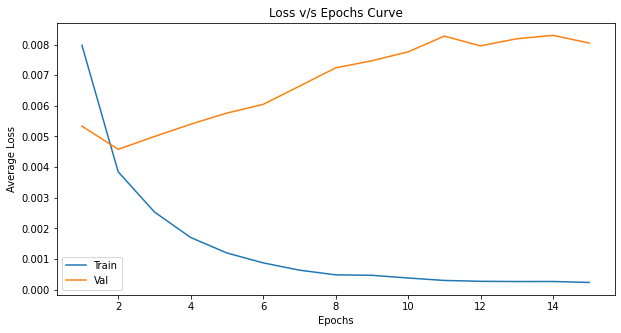

In [ ]:
plt.figure(figsize=(10,5))
plt.plot([j for j in range(1,16)],[output_train_1[i][1] for i in range(0,15)])
plt.plot([j for j in range(1,16)],[output_val_1[i][1] for i in range(0,15)])
plt.xlabel("Epochs")
plt.ylabel("Average Loss")
plt.title("Loss v/s Epochs Curve")
plt.legend(["Train","Val"])
plt.show()

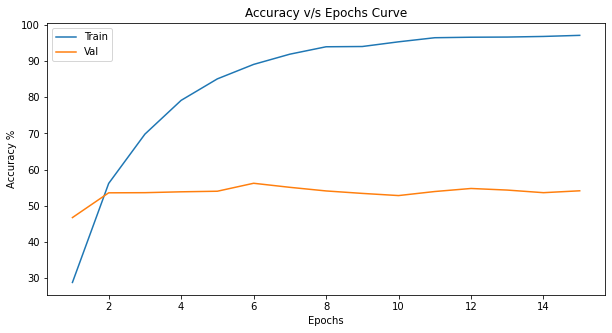

In [ ]:
plt.figure(figsize=(10,5))
plt.plot([j for j in range(1,16)],[output_train_1[i][2].cpu().numpy() for i in range(0,15)])
plt.plot([j for j in range(1,16)],[output_val_1[i][2].cpu().numpy() for i in range(0,15)])
plt.xlabel("Epochs")
plt.ylabel("Accuracy %")
plt.title("Accuracy v/s Epochs Curve")
plt.legend(["Train","Val"])
plt.show()

# 2.) Optimization via Center Loss

In [7]:
train, val = data_preparation(Train_Prepare, Val_Prepare, '/content/drive/MyDrive/DL_Assignment_2/tiny-imagenet-200/train', '/content/drive/MyDrive/DL_Assignment_2/tiny-imagenet-200/val', train_df, val_df, Batch_Size = 500, Shuffle = False)

## Pytorch-Compatible Class for Center-Loss

In [8]:
class CenterLoss(torch.nn.Module):
  
  def __init__(self, num_classes=10, feat_dim=2, batch_user = 128):
    super(CenterLoss, self).__init__()
    self.num_classes = num_classes
    self.feat_dim = feat_dim
    self.centers = torch.nn.Parameter(torch.randn(self.num_classes, self.feat_dim).cuda())
    self.batch_size=batch_user

  def forward(self, x, labels):
    distmat = torch.pow(x, 2).sum(dim=1, keepdim=True).expand(self.batch_size, self.num_classes) + \
              torch.pow(self.centers, 2).sum(dim=1, keepdim=True).expand(self.num_classes, self.batch_size).t()
    distmat.addmm_(1, -2, x, self.centers.t())
    classes = torch.arange(self.num_classes).long().cuda()
    labels = labels.unsqueeze(1).expand(self.batch_size, self.num_classes)
    mask = labels.eq(classes.expand(self.batch_size, self.num_classes))
    dist = distmat * mask.float()
    loss = dist.clamp(min=1e-12, max=1e+12).sum() / (2*self.batch_size)
    return loss

## Pytorch-Compatible Class for Feature-Extractor

In [12]:
class new_model(torch.nn.Module):
  def __init__(self, model_class, output_layer):
    super().__init__()
    self.output_layer = output_layer
    self.pretrained = model_class
    self.children_list = []
    for n,c in self.pretrained.named_children():
      self.children_list.append(c)
      if n == self.output_layer:
        break
    self.children_final = self.children_list[:-1]
    self.net = torch.nn.Sequential(*self.children_final)
    self.pretrained = None
      
  def forward(self,x):
    count=0
    for layer in self.net:
      count+=1
      if count==10:
        x = x.view(-1,512*1*1)
      x = layer(x)
    return x

## ResNet Model with n_dim=2 and batch_size=500 for Default Configurations

In [34]:
resnet_model_center = models.resnet18(pretrained=True)
n_input = resnet_model_center.fc.out_features
resnet_model_center.fc1 = torch.nn.Linear(n_input,2)
resnet_model_center.fc1_activation = torch.nn.LeakyReLU()
resnet_model_center.fc2 = torch.nn.Linear(2,50)
resnet_model_center.cuda()
model_loss = torch.nn.CrossEntropyLoss().cuda()
center_loss = CenterLoss(50, 2, 500)
params_center = list(resnet_model_center.parameters()) + list(center_loss.parameters())
optimizer_center = torch.optim.Adam(params_center, lr=0.01)

## Utility Function to train Pytorch-Model with varied Learning Rate, Alpha and Central-Learning Rate

In [10]:
def grad_change_center_lr(Loss_Function_model, Loss_Function_center, Optimizer, Label = None, Predicted = None, Features = None, alpha_chosen=0.1, lr_cent_user = 0.5, lr_optim_user = 0.1):
  cross_loss = Loss_Function_model(Predicted, Label)/500
  center_loss = Loss_Function_center(Features, Label)
  overall_loss = cross_loss + center_loss*alpha_chosen
  Optimizer.zero_grad()
  overall_loss.backward()
  for param in Loss_Function_center.parameters():
    param.grad.data *= (lr_cent_user / (alpha_chosen * lr_optim_user))
  Optimizer.step()
  return overall_loss, center_loss, cross_loss, Optimizer

def model_center_lr(Train_Loader, Test_Loader, Epochs, Model_Class=None, Model_Features=None, Loss_Function_model=None, Loss_Function_center=None, Optimizer=None, alpha=0.1, lr_cent=0.5, lr_optim = 0.1):
  outputs_train=[]
  outputs_test=[]
  for Epoch in tqdm(range(Epochs)):
    running_loss_train=0
    center_loss_train=0
    cross_loss_train=0
    running_loss_test=0
    center_loss_test=0
    cross_loss_test=0
    correct_train=0
    correct_test=0
    for (image, label) in Train_Loader:
      image = image.cuda()
      label = label.cuda()
      output_pred = Model_Class(image)
      model_feat = Model_Features(model_class = Model_Class, output_layer = 'fc1_activation')
      output_feat = model_feat(image)
      loss, cent, cross, Optimizer = grad_change_center_lr(Loss_Function_model = Loss_Function_model, Loss_Function_center = Loss_Function_center, Optimizer = Optimizer, Label = label, Predicted = output_pred, Features = output_feat, alpha_chosen=alpha, lr_cent_user = lr_cent, lr_optim_user = lr_optim)
      running_loss_train += loss.item()
      center_loss_train += cent.item()
      cross_loss_train += cross.item()
      predicted_train = output_pred.data.max(1, keepdim=True)[1]
      correct_train += predicted_train.eq(label.data.view_as(predicted_train)).sum()
      print(running_loss_train, center_loss_train, cross_loss_train)
    outputs_train.append((Epoch, running_loss_train, center_loss_train, cross_loss_train,100*correct_train/len(Train_Loader.dataset)))
    with torch.no_grad():
      for (image, label) in Test_Loader:
        image = image.cuda()
        label = label.cuda()
        out_pred = Model_Class(image)
        mod_feat = Model_Features(model_class = Model_Class, output_layer = 'fc1_activation')
        out_feat = mod_feat(image)
        cross_loss = Loss_Function_model(out_pred,label)/500
        cent_loss = Loss_Function_center(out_feat,label)
        overall_loss = cross_loss + cent_loss*alpha
        running_loss_test += overall_loss.item()
        center_loss_test += cent.item()
        cross_loss_test += cross.item()
        predicted_test = out_pred.data.max(1, keepdim=True)[1]
        correct_test += predicted_test.eq(label.data.view_as(predicted_test)).sum()
        print(running_loss_test, center_loss_test, cross_loss_test)
      outputs_test.append((Epoch, running_loss_test, center_loss_test, cross_loss_test, 100*correct_test/len(Test_Loader.dataset)))
  return Model_Class, outputs_train, outputs_test

## For Alpha=0.1

In [41]:
resnet_model_center_1,output_train_center_1,output_val_center_1 = model_center_lr(train,val,20,resnet_model_center,new_model,model_loss,center_loss,optimizer_center,alpha=0.1, lr_cent=0.5, lr_optim=0.01)

  0%|          | 0/20 [00:00<?, ?it/s]

0.02389788255095482 0.10261096060276031 0.013636786490678787
0.10544374212622643 0.7816441804170609 0.027279319241642952
0.12427199073135853 0.8336209058761597 0.0409098956733942
0.16848858632147312 1.139039784669876 0.054584601894021034
0.2142114881426096 1.4611113369464874 0.0681003462523222
0.23628821223974228 1.5449749529361725 0.08179070893675089
0.2661908119916916 1.7089785188436508 0.09529295191168785
0.2862298972904682 1.7737843468785286 0.10885145515203476
0.3043138664215803 1.8183082044124603 0.12248303834348917
0.33126337081193924 1.951630339026451 0.13610032945871353
0.34612725395709276 1.9643811313435435 0.14968913327902555
0.36052262503653765 1.9728386718779802 0.16323875077068806
0.3781708022579551 2.012204611673951 0.17695033363997936
0.40741538535803556 2.168055484071374 0.19060982950031757
0.42126896046102047 2.170883378246799 0.2041806150227785
0.43499159812927246 2.1731370624620467 0.21767788473516703
0.4520146194845438 2.2059188273269683 0.23142272885888815
0.46676

  5%|▌         | 1/20 [01:00<19:05, 60.27s/it]

0.156077416613698 0.3605055436491966 0.06833508610725403
0.021319271996617317 0.07690685242414474 0.013628586195409298
0.10194086469709873 0.7467837259173393 0.0272624921053648
0.12036976031959057 0.7945813871920109 0.04091162234544754
0.16339284367859364 1.08815011754632 0.054577833972871304
0.2077262829989195 1.396434459835291 0.068082838319242
0.22924473881721497 1.4748223014175892 0.0817625094205141
0.2554805129766464 1.6032808609306812 0.09515242837369442
0.278253898024559 1.6962946243584156 0.10862443596124649
0.2957641426473856 1.7351312339305878 0.12225101888179779
0.32393442653119564 1.8808191418647766 0.13585251290351152
0.33860464207828045 1.8918690346181393 0.14941773936152458
0.3534154575318098 1.9044026639312506 0.16297519207000732
0.3700732495635748 1.9340051226317883 0.1766727389767766
0.3999729584902525 2.0964058749377728 0.19033237174153328
0.41406721621751785 2.101577317342162 0.20390948560088873
0.42773688957095146 2.103395850979723 0.21739730518311262
0.44331839401

 10%|█         | 2/20 [01:53<16:52, 56.25s/it]

0.14857586659491062 0.2712431363761425 0.06832656916230917
0.01944536715745926 0.05820450931787491 0.013624916784465313
0.09929223358631134 0.7203140035271645 0.027260837145149708
0.11727938428521156 0.763665147125721 0.04091287311166525
0.15945105254650116 1.0487463846802711 0.05457641743123531
0.18809069134294987 1.1999619230628014 0.06809450220316648
0.20943515375256538 1.2766778096556664 0.08176737651228905
0.23221462778747082 1.3707010671496391 0.09514452423900366
0.2537841275334358 1.4518637284636497 0.10859775729477406
0.2704751919955015 1.4825991038233042 0.1222152840346098
0.2997254189103842 1.6392631474882364 0.13579910527914762
0.31489315163344145 1.6554558798670769 0.14934756513684988
0.32989627216011286 1.670019376091659 0.16289433650672436
0.34506604820489883 1.6849071886390448 0.176575331017375
0.3782200887799263 1.879886170849204 0.1902314703911543
0.39312872383743525 1.8934853179380298 0.20378019101917744
0.4066171254962683 1.8937156519968994 0.21724555920809507
0.4215

 15%|█▌        | 3/20 [02:45<15:22, 54.29s/it]

0.1423459891229868 0.19370472058653831 0.0682999799028039
0.01728322170674801 0.03661291301250458 0.013621930964291096
0.09336123429238796 0.6610544770956039 0.027255788445472717
0.11032172851264477 0.694283589720726 0.0408933712169528
0.14963713474571705 0.9508843868970871 0.05454869568347931
0.17131364159286022 1.0324240699410439 0.06807123497128487
0.1915109772235155 1.0977383106946945 0.0817371467128396
0.21148201078176498 1.164142556488514 0.0950677553191781
0.23284104093909264 1.2429721876978874 0.10854382254183292
0.2492252215743065 1.2707265634089708 0.12215256504714489
0.2785845249891281 1.428477244451642 0.13573680073022842
0.29364745784550905 1.4432619344443083 0.14932126458734274
0.30951961409300566 1.4670580625534058 0.16281380783766508
0.3242468871176243 1.4776520244777203 0.17648168466985226
0.35887282714247704 1.6873822025954723 0.19013460539281368
0.37445525359362364 1.7078002039343119 0.20367523189634085
0.3880366962403059 1.7090088725090027 0.2171358074992895
0.40292

 20%|██        | 4/20 [03:35<13:59, 52.45s/it]

0.13020425103604794 0.11964800767600536 0.06822978612035513
0.015490403398871422 0.018789712339639664 0.013611432164907455
0.08693713508546352 0.5969909466803074 0.027238041162490845
0.10271189175546169 0.6184311285614967 0.040868778713047504
0.13881374709308147 0.8430516645312309 0.0545085808262229
0.17276318930089474 1.048078067600727 0.06795538123697042
0.19132897444069386 1.0971949584782124 0.08160947635769844
0.2180143091827631 1.22877811267972 0.0951364953070879
0.23915495909750462 1.30525716021657 0.10862923972308636
0.254759781062603 1.3253790754824877 0.12222187034785748
0.2826046720147133 1.4683585185557604 0.1357688158750534
0.30133506283164024 1.5231039207428694 0.14902466721832752
0.3165339110419154 1.5403563659638166 0.16249827109277248
0.33042732812464237 1.5430522351525724 0.17612210102379322
0.3640236612409353 1.7425956963561475 0.18976408801972866
0.3796108774840832 1.763230740558356 0.20328779984265566
0.3961743377149105 1.7940243142656982 0.21677190344780684
0.41109

 25%|██▌       | 5/20 [04:24<12:50, 51.37s/it]

0.12819939106702805 0.08210623636841774 0.0681470986455679
0.014543667435646057 0.009473753161728382 0.013596292585134506
0.08191782981157303 0.5470342757180333 0.027214398607611656
0.09685378149151802 0.5602820366621017 0.04082557465881109
0.12974050268530846 0.7529196292161942 0.05444853473454714
0.16757740452885628 0.9969765245914459 0.06787974666804075
0.18473098054528236 1.0320355407893658 0.08152742125093937
0.20778828859329224 1.128210473805666 0.0949672358110547
0.2282463237643242 1.1984837986528873 0.10839793924242258
0.24350892938673496 1.2153020817786455 0.12197871692478657
0.26928615756332874 1.3375708032399416 0.13552907295525074
0.2840763982385397 1.350067931227386 0.149069600738585
0.3001268468797207 1.3759132260456681 0.1625355202704668
0.31446983106434345 1.382908423896879 0.17617898434400558
0.3461425434798002 1.563300912734121 0.18981244787573814
0.36146061960607767 1.581052168738097 0.20335539802908897
0.3772705467417836 1.6046555596403778 0.2168049868196249
0.39192

 30%|███       | 6/20 [05:14<11:52, 50.87s/it]

0.12108311429619789 0.04195190966129303 0.06806347984820604
0.013997246511280537 0.003994825761765242 0.013597764074802399
0.07750098872929811 0.5029456648044288 0.0272064208984375
0.09168963693082333 0.5088964095339179 0.040799994952976704
0.12203186564147472 0.6762897958979011 0.05440288595855236
0.15309550613164902 0.8531418582424521 0.06778131984174252
0.16923986189067364 0.8782581062987447 0.08141405135393143
0.18942495621740818 0.946345348842442 0.09479042235761881
0.20952233485877514 1.0132667990401387 0.10819565504789352
0.22437630966305733 1.0261542983353138 0.12176087964326143
0.24945711344480515 1.1416273824870586 0.13529437500983477
0.2647825302556157 1.159987736493349 0.1487837564200163
0.2807059558108449 1.1849318984895945 0.16221276577562094
0.2950176764279604 1.1917073498480022 0.1758469408378005
0.32662719674408436 1.3715111832134426 0.18947607651352882
0.34197750966995955 1.3900831094942987 0.20296919718384743
0.3579124314710498 1.4151395107619464 0.21639847848564386


 35%|███▌      | 7/20 [06:04<10:58, 50.63s/it]

0.11145337298512459 0.04232489038258791 0.06803703960031271
0.013699562288820744 0.0009469935321249068 0.013604862615466118
0.07157604489475489 0.4435848841094412 0.02721755299717188
0.08532260917127132 0.4452166829141788 0.040800937451422215
0.1122143566608429 0.5781965825590305 0.05439469497650862
0.1356863435357809 0.6791000638040714 0.06777633354067802
0.1508559249341488 0.6945031845825724 0.08140560239553452
0.16941049695014954 0.7462417745846324 0.09478631522506475
0.18819051794707775 0.8001895101624541 0.1081715626642108
0.20281997695565224 0.8109205469372682 0.12172791827470064
0.22636106237769127 0.9110941171529703 0.13525164686143398
0.24148263316601515 0.9275794338318519 0.14872468635439873
0.2569773430004716 0.9483473479631357 0.16214260458946228
0.2713370779529214 0.9557202776777558 0.17576504684984684
0.3028537156060338 1.1346572955953889 0.18938798364251852
0.3185339467599988 1.1563014464336447 0.20290379878133535
0.33533241506665945 1.1899821611004882 0.2163341958075761

 40%|████      | 8/20 [06:54<10:03, 50.28s/it]

0.10093378461897373 0.04725856240838766 0.06794255692511797
0.01382428128272295 0.0022481116466224194 0.013599470257759094
0.06630969513207674 0.391075465362519 0.027202146127820015
0.0798909654840827 0.3912567734369077 0.04076528549194336
0.10370900016278028 0.4937003194936551 0.0543389655649662
0.12701219227164984 0.5931353062042035 0.06769865937530994
0.14137358032166958 0.6005661367089488 0.08131696470081806
0.1577485352754593 0.6310131000936963 0.09464722312986851
0.17490165121853352 0.6686154427588917 0.10804010462015867
0.18919257633388042 0.6761294068419375 0.12157963309437037
0.21091474406421185 0.7582634674035944 0.1350883934646845
0.22582323290407658 0.7729325672262348 0.14852997194975615
0.2408698545768857 0.7893495378666557 0.16193489637225866
0.2551112100481987 0.7956614201539196 0.1755450638011098
0.2854799684137106 0.9632570599787869 0.18915425706654787
0.3006930388510227 0.9808330336236395 0.20260972995311022
0.3170971740037203 1.010869762452785 0.21601019147783518
0.3

 45%|████▌     | 9/20 [07:43<09:11, 50.09s/it]

0.09294851869344711 0.06023666821420193 0.06786288693547249
0.014193635433912277 0.005921056494116783 0.013601529411971569
0.06133807450532913 0.3414017762988806 0.02719789557158947
0.07508303597569466 0.34343584394082427 0.040739450603723526
0.09628822281956673 0.42005218332633376 0.05428300239145756
0.11141470447182655 0.4375359914265573 0.067661102861166
0.12534327618777752 0.440725211519748 0.08127075247466564
0.14036450535058975 0.4581602611579001 0.09454847685992718
0.15647148340940475 0.4851168212480843 0.10795979853719473
0.17070520762354136 0.49218646297231317 0.12148655857890844
0.19095276948064566 0.5596519173122942 0.13498757500201464
0.2052326202392578 0.5678186030127108 0.14845075737684965
0.21997937560081482 0.5813858429901302 0.1618407890200615
0.23437276855111122 0.5893391729332507 0.17543884925544262
0.26435261964797974 0.7531252563931048 0.1890400918200612
0.2797724474221468 0.7726836339570582 0.2025040816515684
0.29597879759967327 0.8010550090111792 0.21587329357862

 50%|█████     | 10/20 [08:33<08:19, 49.99s/it]

0.09065132774412632 0.07335915695875883 0.06776828784495592
0.014741497114300728 0.011490046046674252 0.013592492789030075
0.05707267485558987 0.2989161601290107 0.027181058190762997
0.07125422079116106 0.30556920589879155 0.040697299875319004
0.09008136112242937 0.35855623008683324 0.0542257372289896
0.1044059731066227 0.3684422397054732 0.06756174843758345
0.11808169633150101 0.36922443174989894 0.08115925267338753
0.13328733388334513 0.3882904395577498 0.09445828944444656
0.14856392703950405 0.4078320048865862 0.10778072569519281
0.16260570008307695 0.4131912922603078 0.12128657009452581
0.18103692773729563 0.4627796894055791 0.13475895766168833
0.195373366586864 0.472448006097693 0.14812856446951628
0.2096465853974223 0.48159349971683696 0.16148723382502794
0.22375179454684258 0.4868238627095707 0.1750694066286087
0.251505721360445 0.6285401343484409 0.1886517070233822
0.26658605225384235 0.6447215939988382 0.2021138919517398
0.2847041394561529 0.6919538195361383 0.2155087571591138

 55%|█████▌    | 11/20 [09:23<07:28, 49.87s/it]

0.08360083773732185 0.08665772154927254 0.06762113887816668
0.01541064865887165 0.0183250792324543 0.01357814110815525
0.054291004315018654 0.2713950164616108 0.027151504531502724
0.0690566273406148 0.2841798132285476 0.040638647973537445
0.08662381675094366 0.32493877317756414 0.05412994138896465
0.1001859987154603 0.3276093148160726 0.06742506939917803
0.11385480221360922 0.32851627410855144 0.08100317697972059
0.1279071094468236 0.3368201855337247 0.09422509279102087
0.14219124615192413 0.3462228247663006 0.10756896529346704
0.1561457635834813 0.35092667571734637 0.12105309776961803
0.1732576796784997 0.38738413609098643 0.13451926782727242
0.18692194763571024 0.38987428799737245 0.14793452061712742
0.2009773924946785 0.39716578798834234 0.1612608153373003
0.21492052730172873 0.40093838737811893 0.1748266899958253
0.24106198828667402 0.52676605747547 0.1883853841573
0.2558203777298331 0.5398612091084942 0.2018342586234212
0.27236197981983423 0.5719387823482975 0.21516810357570648
0.

 60%|██████    | 12/20 [10:13<06:39, 49.92s/it]

0.08142698369920254 0.1040689367800951 0.0675319554284215
0.016001833602786064 0.024297382682561874 0.013572095893323421
0.05053827352821827 0.233981903642416 0.02714008465409279
0.06611317675560713 0.25515125691890717 0.04059805255383253
0.08232893701642752 0.28264787048101425 0.05406415183097124
0.09566865302622318 0.2834096502047032 0.06732769031077623
0.10963807441294193 0.2874205631669611 0.08089601993560791
0.12356170080602169 0.2948642310220748 0.09407527931034565
0.13724034745246172 0.2984383082948625 0.10739651788026094
0.1514215562492609 0.3055739551782608 0.12086416222155094
0.16722316853702068 0.32905190251767635 0.13431797921657562
0.18069072905927896 0.32978507003281265 0.14771222323179245
0.19445488695055246 0.3343358557904139 0.16102130245417356
0.20822726096957922 0.33653619897086173 0.17457364220172167
0.23235197458416224 0.4424067811341956 0.1881112977862358
0.2467207983136177 0.45174633350688964 0.20154616609215736
0.2627274803817272 0.47889108408708125 0.2148383734

 65%|██████▌   | 13/20 [11:03<05:49, 49.96s/it]

0.08120756130665541 0.11452597565948963 0.06744076497852802
0.016515323892235756 0.02949649468064308 0.013565674424171448
0.04744337685406208 0.20319509878754616 0.027123866602778435
0.06386165879666805 0.2330802846699953 0.04055362939834595
0.07930881157517433 0.2531520929187536 0.053993601351976395
0.09261820465326309 0.2540687616565265 0.06721132714301348
0.10706018097698689 0.262909741664771 0.08076920546591282
0.12121675536036491 0.2731499770306982 0.09390175621956587
0.1345829777419567 0.27379680366721004 0.10720329638570547
0.149162077344954 0.2850989861181006 0.12065217737108469
0.16392081510275602 0.2983138900017366 0.1340894252061844
0.17733222246170044 0.2988821197068319 0.1474440097808838
0.19075996801257133 0.3003054419532418 0.16072942316532135
0.20438003912568092 0.3011056818650104 0.1742694703862071
0.22639930061995983 0.3861541040823795 0.1877838894724846
0.24037887807935476 0.3917709240340628 0.20120178535580635
0.25590555276721716 0.41443042882019654 0.21446250937879

 70%|███████   | 14/20 [11:52<04:58, 49.82s/it]

0.08245169278234243 0.11666825041174889 0.06733278278261423
0.016841236501932144 0.032821349799633026 0.013559102080762386
0.04476315155625343 0.17657119780778885 0.02710603177547455
0.061913758516311646 0.21404773741960526 0.04050898551940918
0.07703066151589155 0.23108110204339027 0.053922551684081554
0.0906193433329463 0.23521046619862318 0.06709829717874527
0.1055771978572011 0.24933389015495777 0.08064380940049887
0.12024213839322329 0.2650970369577408 0.09373243525624275
0.13359119836241007 0.2656682581291534 0.10702437348663807
0.148685066960752 0.28230690403142944 0.12045437749475241
0.16274304129183292 0.28863351844483986 0.1338796904310584
0.17618412245064974 0.2897617270355113 0.1472079511731863
0.18949183635413647 0.2901895769755356 0.1604728801175952
0.2030512411147356 0.2904918835265562 0.1740020541474223
0.22327249683439732 0.35776529170107096 0.1874959683045745
0.23700200021266937 0.36105201987084 0.200896798633039
0.2521026851609349 0.3797802481567487 0.214124660938978

 75%|███████▌  | 15/20 [12:42<04:09, 49.85s/it]

0.08500300534069538 0.11235895566642284 0.0672314828261733
0.016988759860396385 0.034367598593235016 0.013551999814808369
0.042412616312503815 0.1532439962029457 0.02708821650594473
0.06015386991202831 0.19689664989709854 0.040464204736053944
0.07527092844247818 0.21417712420225143 0.05385321564972401
0.08921871986240149 0.2223540861159563 0.0669833105057478
0.10471107717603445 0.2419628743082285 0.08051478862762451
0.1201515244320035 0.26584075950086117 0.09356744773685932
0.1337678274139762 0.2692867908626795 0.10683914739638567
0.14952875208109617 0.2928036618977785 0.1202483857050538
0.16318727750331163 0.2952367125544697 0.1336636058986187
0.1767963394522667 0.2983589805662632 0.14696044102311134
0.19007408525794744 0.29864469496533275 0.16020961571484804
0.20363717805594206 0.29909729887731373 0.1737274480983615
0.22211627010256052 0.3491946079302579 0.18719680979847908
0.23563975654542446 0.35059360414743423 0.20058039668947458
0.2501934627071023 0.3641666704788804 0.21377679612

 80%|████████  | 16/20 [13:32<03:19, 49.83s/it]

0.0891776904463768 0.10341578163206577 0.06714150309562683
0.016958346590399742 0.03411468490958214 0.013546877540647984
0.040408309549093246 0.1333455927670002 0.027073749341070652
0.05855124071240425 0.1812397688627243 0.040427262894809246
0.07391436211764812 0.20119083486497402 0.0537952771410346
0.08837593626230955 0.21484619658440351 0.06689131539314985
0.10433810483664274 0.2392443986609578 0.08041366282850504
0.12069808971136808 0.27265383396297693 0.09343270491808653
0.13479199074208736 0.2810115674510598 0.106690832413733
0.15129058063030243 0.312059230171144 0.1200846554711461
0.16481437720358372 0.31323689001146704 0.13349068630486727
0.17867943737655878 0.3190911585697904 0.14677031990140676
0.19207410048693419 0.3206907782005146 0.16000502090901136
0.2057254696264863 0.32209696352947503 0.17351577151566744
0.22272867988795042 0.3575874912785366 0.18696992844343185
0.2361482921987772 0.3580819570925087 0.20034009404480457
0.25020227767527103 0.3669044019188732 0.21351183485

 85%|████████▌ | 17/20 [14:22<02:29, 49.84s/it]

0.09406002052128315 0.0909050740301609 0.0670758169144392
0.016783567145466805 0.03239119052886963 0.013544447720050812
0.03862188011407852 0.11556090414524078 0.027065789327025414
0.05698414705693722 0.16582902520895004 0.04040124360471964
0.07274134643375874 0.18989606946706772 0.05375173781067133
0.08786251954734325 0.21035638265311718 0.06682687997817993
0.10423459485173225 0.23889837972819805 0.08034475520253181
0.12162088975310326 0.28281415067613125 0.09333947394043207
0.13635001983493567 0.29760641884058714 0.10658937692642212
0.15366691257804632 0.3369468813762069 0.11997222434729338
0.16727603040635586 0.33906427887268364 0.13336960226297379
0.18149080965667963 0.3486161467153579 0.14662919472903013
0.19510542321950197 0.35251846932806075 0.15985357575118542
0.20893285516649485 0.35572944302111864 0.17335991002619267
0.22467557806521654 0.3787104347720742 0.18680453393608332
0.23806196730583906 0.37900506309233606 0.20016146078705788
0.25168236903846264 0.3836706706788391 0.2

 90%|█████████ | 18/20 [15:12<01:39, 49.83s/it]

0.09913690760731697 0.0760149210691452 0.06702735554426908
0.01646546833217144 0.029219189658761024 0.013543548993766308
0.03707013465464115 0.10007957555353642 0.027062175795435905
0.05543203465640545 0.15049870498478413 0.04038216359913349
0.07165438868105412 0.17938388511538506 0.05371600016951561
0.08751507475972176 0.20730391331017017 0.06678468361496925
0.10419649630784988 0.23895774222910404 0.080300722271204
0.1225152388215065 0.29242980666458607 0.09327225759625435
0.1379514541476965 0.31431523337960243 0.10651993006467819
0.15612352453172207 0.36228687688708305 0.11989483702927828
0.16999688651412725 0.36711945151910186 0.13328494131565094
0.18462394829839468 0.38098538806661963 0.14652540907263756
0.1985411997884512 0.38798881508409977 0.1597423180937767
0.21263997349888086 0.3939388878643513 0.17324608471244574
0.22737283632159233 0.406874917447567 0.1866853442043066
0.2408001096919179 0.407687216589693 0.2000313876196742
0.2541139842942357 0.4094576603383757 0.213168217800

 95%|█████████▌| 19/20 [16:01<00:49, 49.74s/it]

0.10396675020456314 0.05876400042325258 0.06700374186038971
0.016024310141801834 0.02478569559752941 0.013545741327106953
0.03563324734568596 0.08569867722690105 0.027063379995524883
0.05376608856022358 0.13396241329610348 0.040369847789406776
0.07040482386946678 0.16712755151093006 0.053692069835960865
0.08694734051823616 0.20212197862565517 0.06673514470458031
0.10380902327597141 0.23556937836110592 0.080252087675035
0.12278646603226662 0.29580280743539333 0.0932061867788434
0.1389024741947651 0.3244148753583431 0.10646098759025335
0.1579214669764042 0.38090644031763077 0.11983082443475723
0.17217718437314034 0.38960891775786877 0.1332162944599986
0.18717241939157248 0.40717332996428013 0.14645508863031864
0.20136937871575356 0.41705850791186094 0.15966353006660938
0.2158397799357772 0.42674037255346775 0.1731657451018691
0.22983046527951956 0.4322954365052283 0.18660092446953058
0.24338767770677805 0.4344615258742124 0.19994152802973986
0.2565419562160969 0.4348120287468191 0.213060

100%|██████████| 20/20 [16:51<00:00, 50.59s/it]

0.10606526397168636 0.03962008748203516 0.066995183005929


## For Alpha = 0.01

In [46]:
resnet_model_center_2 = models.resnet18(pretrained=True)
resnet_model_center_2.fc1 = torch.nn.Linear(n_input,2)
resnet_model_center_2.fc1_activation = torch.nn.LeakyReLU()
resnet_model_center_2.fc2 = torch.nn.Linear(2,50)
resnet_model_center_2.cuda()
center_loss_2 = CenterLoss(50, 2, 500)
params_center_2 = list(resnet_model_center_2.parameters()) + list(center_loss_2.parameters())
optimizer_center_2 = torch.optim.Adam(params_center_2, lr=0.01)
resnet_model_center_2,output_train_center_2,output_val_center_2 = model_center_lr(train,val,20,resnet_model_center_2,new_model,model_loss,center_loss_2,optimizer_center_2,alpha=0.01, lr_cent=0.5, lr_optim=0.01)

  0%|          | 0/20 [00:00<?, ?it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f863ff74d40>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f863ff74d40>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    i

0.07894561439752579 5.081034183502197 0.0281352736055851
25.251778103411198 2519.103006839752 0.06074952334165573
25.457807771861553 2537.8824219703674 0.07898503728210926
32.2789194509387 3218.186987400055 0.09705161862075329
33.399901024997234 3328.4294877052307 0.11560826748609543
34.185968808829784 3405.7065720558167 0.12890522181987762
36.42429368942976 3628.315763950348 0.14113817550241947
40.054201774299145 3989.779448032379 0.15640957932919264
42.83510725945234 4265.238554477692 0.18272412661463022
43.20301028341055 4300.824110507965 0.19477160833775997
43.294952012598515 4307.423025608063 0.22072418592870235
43.70875937491655 4347.117792606354 0.23758388869464397
44.75757712870836 4450.0374093055725 0.2572054658085108
45.9350361302495 4565.4699120521545 0.2803394254297018
46.31339684873819 4601.009932041168 0.30329993180930614
46.37370753288269 4605.824802398682 0.31546191312372684
46.41181197017431 4607.280771970749 0.3390066549181938
46.708895705640316 4634.820219755173 0.36

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f863ff74d40>
Traceback (most recent call last):
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f863ff74d40>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
AssertionError: can only test a child process
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

0.03234408423304558 4.093787670135498 0.011280287988483906
0.07129410281777382 8.187575340270996 0.02256057597696781
0.10638030245900154 12.281363010406494 0.03384086396545172
0.14406868442893028 16.375150680541992 0.04512115195393562


  5%|▌         | 1/20 [00:49<15:46, 49.82s/it]

0.17991486564278603 20.46893835067749 0.05640143994241953


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f863ff74d40>
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f863ff74d40>
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    if w.is_alive():
    assert self._parent_pid == os.getpid(), 'can only test a child process'
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in

0.010188362561166286 0.17321577668190002 0.008456205017864704
0.07962468918412924 5.052327543497086 0.029101415537297726
0.1704576751217246 12.515768438577652 0.04529999289661646
0.18468813132494688 12.641306787729263 0.0582750653848052
0.24519828986376524 17.574403673410416 0.06945425644516945
0.27482353802770376 19.38139370083809 0.08100960310548544
0.3004044136032462 20.635909110307693 0.09404532425105572
0.34925328847020864 24.366642266511917 0.10558686964213848
0.3783931424841285 25.546106725931168 0.1229320801794529
0.4034976689144969 26.937313824892044 0.13412453513592482
0.43172292690724134 28.34033051133156 0.14831962529569864
0.4649961991235614 30.339772015810013 0.16159848403185606
0.47854530811309814 30.529477015137672 0.17325054295361042
0.5053350180387497 31.390735045075417 0.19142767414450645
0.5832677707076073 37.53443755209446 0.20792340487241745
0.6432083435356617 42.48393000662327 0.21836905647069216
0.6863963939249516 45.02188028395176 0.23617760743945837
0.71258080

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f863ff74d40>
Traceback (most recent call last):
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f863ff74d40>
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
    if w.is_alive():
  File "/usr/lib/pytho

0.031426288187503815 1.0877567529678345 0.011117693036794662
0.06184889189898968 2.175513505935669 0.022235386073589325
0.09839794598519802 3.2632702589035034 0.03335307911038399
0.13369831629097462 4.351027011871338 0.04447077214717865


 10%|█         | 2/20 [01:40<15:01, 50.08s/it]

0.16565479896962643 5.438783764839172 0.05558846518397331


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f863ff74d40>
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f863ff74d40>
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child

0.011407982558012009 0.32149067521095276 0.00819307565689087
0.08711550012230873 6.198778063058853 0.025127720087766647
0.13848328962922096 9.933455377817154 0.039148734882473946
0.1627596616744995 11.094535261392593 0.05181430745869875
0.20549965649843216 14.273245722055435 0.0627671992406249
0.21959871239960194 14.561561286449432 0.0739830993115902
0.24987243302166462 16.354443848133087 0.0863279951736331
0.27068399079144 17.32197278738022 0.09746426343917847
0.29620950296521187 18.336491763591766 0.11284458637237549
0.31391268596053123 18.999634981155396 0.12391633726656437
0.34089842438697815 20.37557625770569 0.13714266195893288
0.37386059761047363 22.466273069381714 0.1491978680714965
0.3884036745876074 22.799740076065063 0.16040627472102642
0.4385742973536253 26.068153858184814 0.1778927631676197
0.47800341807305813 28.57571506500244 0.19224627315998077
0.5149637628346682 31.227782487869263 0.2026859438046813
0.5778257865458727 35.90960383415222 0.21872975956648588
0.59716369956

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f863ff74d40>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f863ff74d40>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

0.02213367447257042 0.7439324259757996 0.010630468837916851
0.0444612093269825 1.4878648519515991 0.021260937675833702
0.06750310957431793 2.2317972779273987 0.03189140651375055
0.09120176360011101 2.9757297039031982 0.042521875351667404


 15%|█▌        | 3/20 [02:29<14:09, 49.95s/it]

0.11423589289188385 3.719662129878998 0.053152344189584255


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f863ff74d40>
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f863ff74d40>
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    self._shutdown_workers()
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    if w.is_alive():
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
  File "/usr/lib/pytho

0.025907443836331367 1.6974514722824097 0.0089329294860363
0.07476571388542652 5.109638094902039 0.023669333197176456
0.11749139241874218 8.074153542518616 0.036749858409166336
0.1354698482900858 8.625883519649506 0.04921101499348879
0.16776172257959843 10.791760385036469 0.05984411854296923
0.18000751361250877 10.902624189853668 0.07098127156496048
0.210590448230505 12.796242415904999 0.08262802474200726
0.22641772776842117 13.31139624118805 0.09330376610159874
0.2699631489813328 16.07386577129364 0.10922449268400669
0.2826894586905837 16.258659049868584 0.12010286934673786
0.29949603136628866 16.667028948664665 0.13282574247568846
0.3159821545705199 17.219028994441032 0.1437918646261096
0.3296256558969617 17.515153273940086 0.15447412338107824
0.3806762145832181 21.122427329421043 0.16945194453001022
0.41767210606485605 23.482963904738426 0.1828424697741866
0.43870313186198473 24.545382604002953 0.19324930850416422
0.49916012678295374 29.056304559111595 0.20859708450734615
0.51236411

 20%|██        | 4/20 [03:19<13:18, 49.91s/it]

0.1112342569977045 1.6667787730693817 0.0536833330988884
0.022775907069444656 1.2768367528915405 0.010007538832724094
0.06314654275774956 4.010374188423157 0.023042798973619938
0.10755807533860207 7.233028054237366 0.035227793268859386
0.1242151539772749 7.68628191947937 0.047352333553135395
0.1561280656605959 9.81978988647461 0.0579301668331027
0.16761764977127314 9.863508701324463 0.06898256298154593
0.19534072745591402 11.52361249923706 0.08010460343211889
0.21178836282342672 12.07945030927658 0.0909938607364893
0.2435092916712165 13.872032225131989 0.10478896833956242
0.2559240199625492 14.00588621199131 0.11586515698581934


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f863ff74d40>
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f863ff74d40>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    self._shutdown_workers()
    assert self._parent_pid == os.getpid(), 'can only test a child process'
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
AssertionError: can only test a child process
    if w.is_alive():
  File "/usr/lib/pytho

0.2747729253023863 14.69823969900608 0.1277905274182558
0.3007224779576063 16.215737596154213 0.13856510166078806
0.31415397860109806 16.480637088418007 0.1493476079776883
0.3693635631352663 20.615240588784218 0.16321115847676992
0.3896864876151085 21.403168335556984 0.17565480526536703
0.4035570062696934 21.701394602656364 0.18654306139796972
0.4562707431614399 25.590827986598015 0.20036246627569199
0.47771449014544487 26.505212172865868 0.2126623708754778
0.5183441638946533 29.218649968504906 0.22615766618400812
0.546825461089611 30.92906330525875 0.23753483034670353
0.5614151414483786 31.178720206022263 0.249627941288054
0.5823810156434774 32.14863792061806 0.26089463848620653
0.6087052896618843 33.68507555127144 0.2718545366078615
0.6253008935600519 34.058124125003815 0.28471965435892344
0.7085618693381548 41.269645273685455 0.295865417458117
0.7220041789114475 41.47865629196167 0.3072176165878773
0.7586242891848087 43.79880142211914 0.32063627801835537
0.7753131687641144 44.309934

 25%|██▌       | 5/20 [04:09<12:26, 49.76s/it]

0.13183936476707458 1.2931327521800995 0.051350872963666916
0.019160497933626175 0.8842514753341675 0.01031798217445612
0.06365996226668358 4.139642119407654 0.022263539023697376
0.12447065860033035 9.05449664592743 0.033925690688192844
0.14151877351105213 9.570931136608124 0.045809460803866386
0.16160487197339535 10.52631264925003 0.0563417449593544
0.17277877125889063 10.54487438313663 0.06733002699911594
0.1974691143259406 11.93078382126987 0.07816127594560385
0.21559259202331305 12.709574533626437 0.08849684707820415


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f863ff74d40>
Traceback (most recent call last):
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f863ff74d40>
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    self._shutdown_workers()
    assert self._parent_pid == os.getpid(), 'can only test a child process'
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
AssertionError: can only test a child process
  File "/usr/lib/pytho

0.23694935347884893 13.60687936656177 0.10088056046515703
0.252196641638875 14.068686766549945 0.11150977481156588
0.26486003305763006 14.172774327918887 0.12313229031860828
0.28401525411754847 15.03710157983005 0.13364423904567957
0.2961825719103217 15.18247195892036 0.14435785356909037
0.3543215123936534 19.69371864013374 0.15738432854413986
0.3678769627586007 19.85775856487453 0.1692993799224496
0.3805639371275902 20.05209277383983 0.18004301190376282
0.4153854139149189 22.205826742574573 0.19332715030759573
0.4284240761771798 22.33311635069549 0.20509291626513004
0.4637345829978585 24.563053188845515 0.21810405608266592
0.49189269822090864 26.269606886431575 0.2291966350749135
0.5081698810681701 26.71175199560821 0.24105236679315567
0.5234162593260407 27.11285242252052 0.25228774081915617
0.5404679318889976 27.839501468464732 0.2620729235932231
0.5534288920462132 27.914259558543563 0.2742863027378917
0.6231292150914669 33.844079142436385 0.2846884336322546
0.639780554920435 34.4049

 30%|███       | 6/20 [04:59<11:37, 49.80s/it]

0.11023557186126709 2.645544707775116 0.04945492371916771
0.02345905266702175 1.2939739227294922 0.010519313625991344
0.05675148777663708 3.5107626914978027 0.02164386212825775
0.1231334786862135 9.031964302062988 0.03281383868306875
0.14014703780412674 9.527324855327606 0.04487379267811775
0.15154624544084072 9.645444795489311 0.0550918010994792
0.16657069697976112 10.061495259404182 0.06595574878156185
0.18499887362122536 10.81688429415226 0.07683003507554531
0.2026211954653263 11.54773111641407 0.08714388776570559


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f863ff74d40>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f863ff74d40>
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    assert self._parent_pid == os.getpid(), 'can only test a child process'
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    self._shutdown_workers()
    if w.is_alive():
AssertionError: can only test a child process
  File "/usr/lib/pytho

0.22634194418787956 12.725215390324593 0.09908979386091232
0.23888900224119425 12.915566101670265 0.1097333449870348
0.2508712811395526 12.967791642993689 0.12119336891919374
0.2669142661616206 13.535138692706823 0.1315628830343485
0.2779907202348113 13.576596658676863 0.14222475793212652
0.31386156659573317 15.955494564026594 0.15430662594735622
0.33080030884593725 16.497901301831007 0.16582130081951618
0.3448601746931672 16.806801956146955 0.1767921606078744
0.3789596566930413 18.961989801377058 0.18933976534754038
0.39203596115112305 19.11688468977809 0.2008671211078763
0.42255818471312523 20.945809584110975 0.21310009434819221
0.4493742398917675 22.543256741017103 0.2239416791126132
0.46706945076584816 23.147628765553236 0.23559316992759705
0.4809205811470747 23.41022739931941 0.24681831430643797
0.4963764399290085 23.972430925816298 0.25665213726460934
0.5086276456713676 24.01797356083989 0.2684479169547558
0.5695240832865238 29.062523502856493 0.2788988584652543
0.583629872649908

 35%|███▌      | 7/20 [05:48<10:46, 49.72s/it]

0.09993032552301884 4.73225474357605 0.04737956449389458
0.024090269580483437 1.3854986429214478 0.010235283523797989
0.0571922454982996 3.6584888696670532 0.020607356913387775
0.11115157045423985 7.973524212837219 0.03141632676124573
0.12541462946683168 8.20333744585514 0.04338125325739384
0.13587061315774918 8.291709743440151 0.05295351427048445
0.15102787129580975 8.733982287347317 0.06368804723024368
0.16703389957547188 9.295972369611263 0.07407417427748442
0.1875442322343588 10.297109507024288 0.08457313571125269


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f863ff74d40>
Traceback (most recent call last):
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f863ff74d40>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in

0.2102304995059967 11.411615394055843 0.09611434396356344
0.22254088055342436 11.560585342347622 0.10693502519279718
0.23536635655909777 11.715560115873814 0.11821075342595577
0.2539050439372659 12.584440626204014 0.1280606361106038
0.2647000141441822 12.606374425813556 0.1386362686753273
0.3039045110344887 15.38369576446712 0.15006755199283361
0.3194701634347439 15.823219222947955 0.16123796999454498
0.33298046700656414 16.074498696252704 0.17223547864705324
0.3657584171742201 18.146457953378558 0.18429383728653193
0.3800850734114647 18.474461091682315 0.19534046202898026
0.4110979028046131 20.39414824359119 0.20715641882270575
0.440768051892519 22.34344924800098 0.21733355894684792
0.45785013400018215 22.887142850086093 0.22897870559245348
0.47050042264163494 23.03305451385677 0.24016987811774015
0.48654012382030487 23.637519164010882 0.2501649335026741
0.49833669885993004 23.654545284807682 0.2617912469431758
0.5546660199761391 28.248464561998844 0.2721813768148422
0.569335021078586

 40%|████      | 8/20 [06:39<09:59, 49.94s/it]

0.09591733664274216 4.632004201412201 0.047846571542322636
0.023355752229690552 1.2817833423614502 0.010537919588387012
0.05530690401792526 3.4808454513549805 0.020498448982834816
0.1024705246090889 7.173004627227783 0.03074047714471817
0.11604318860918283 7.381430983543396 0.042228877544403076
0.13247902784496546 7.987104713916779 0.052607979625463486
0.14503411576151848 8.177535340189934 0.06325876154005527
0.16315898671746254 8.944769605994225 0.07371129002422094
0.1802360936999321 9.599299415946007 0.08424310013651848


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f863ff74d40>
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f863ff74d40>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    self._shutdown_workers()
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    assert self._parent_pid == os.getpid(), 'can only test a child process'
    if w.is_alive():
AssertionError: can only test a child process
  File "/usr/lib/pytho

0.20644360408186913 11.094524845480919 0.09549835603684187
0.21790963131934404 11.16784305870533 0.1062312014400959
0.23124112840741873 11.388009294867516 0.11736103612929583
0.25071180518716574 12.334713324904442 0.12736467365175486
0.2619429212063551 12.408580526709557 0.13785711769014597
0.30519205890595913 15.632679209113121 0.14886526763439178
0.31798263266682625 15.814666658639908 0.15983596723526716
0.33019979763776064 15.942988842725754 0.1707699103280902
0.3595953630283475 17.70052143931389 0.18259014934301376
0.3712491039186716 17.767674960196018 0.19357235543429852
0.40147668682038784 19.63067201524973 0.20516996923834085
0.42599822022020817 21.056648291647434 0.21543174143880606
0.44425670243799686 21.73626170307398 0.22689408902078867
0.4562251102179289 21.82057759165764 0.2380193378776312
0.47076888382434845 22.284478276968002 0.2479241043329239
0.48289203085005283 22.361181147396564 0.25928022246807814
0.5353757869452238 26.583619959652424 0.2695395899936557
0.5507721109

 45%|████▌     | 9/20 [07:28<09:08, 49.86s/it]

0.09344833716750145 5.93685507774353 0.04412453155964613
0.022233009338378906 1.191684603691101 0.01031616423279047
0.052824001759290695 3.300350069999695 0.019820502027869225
0.09432738646864891 6.425192952156067 0.030075459741055965
0.1072164373472333 6.548384666442871 0.041732593439519405
0.12129410542547703 6.919474840164185 0.05209936015307903
0.135850939899683 7.322458326816559 0.06262635998427868
0.15246541053056717 7.996034026145935 0.07250507455319166
0.17332305759191513 9.067251086235046 0.08265055157244205


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f863ff74d40>
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f863ff74d40>
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child

0.19742824882268906 10.376741886138916 0.09366083610802889
0.20912938937544823 10.498084753751755 0.10414854809641838
0.22278325073421001 10.758556813001633 0.11519768834114075
0.24123124033212662 11.604585021734238 0.12518539559096098
0.25201794039458036 11.637591194361448 0.13564203400164843
0.2912738425657153 14.506162475794554 0.14621222577989101
0.3043798180297017 14.732604395598173 0.1570537816733122
0.31670711748301983 14.869401555508375 0.1680131098255515
0.3450776319950819 16.57239268347621 0.17935371212661266
0.3579728212207556 16.78787935897708 0.19009403511881828
0.38824513368308544 18.678590428084135 0.20145923644304276
0.4152001906186342 20.364141833037138 0.2115587806329131
0.43522939644753933 21.227282714098692 0.22295657824724913
0.4474976910278201 21.346876431256533 0.23402893543243408
0.45964309480041265 21.633394081145525 0.2433091625571251
0.47257044445723295 21.808333415538073 0.2544871186837554
0.5223654424771667 25.75849224999547 0.2647805269807577
0.53776386100

 50%|█████     | 10/20 [08:18<08:18, 49.84s/it]

0.0963827334344387 6.189820766448975 0.04536626394838095
0.023437734693288803 1.2585325241088867 0.010852410458028316
0.05388278141617775 3.341935873031616 0.02046342473477125
0.08807365596294403 5.720433950424194 0.030869318172335625
0.10040773078799248 5.776855401694775 0.04263917822390795
0.11676490493118763 6.365245454013348 0.053112451918423176
0.129613870754838 6.584445916116238 0.06376941315829754
0.14523455686867237 7.093854568898678 0.0742960125207901
0.1644531972706318 8.001884661614895 0.08443435188382864


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f863ff74d40>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f863ff74d40>
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
    assert self._parent_pid == os.getpid(), 'can only test a child process'
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in

0.19128243811428547 9.582782946527004 0.09545460995286703
0.2032869067043066 9.746307529509068 0.10582383256405592
0.21916836127638817 10.211855538189411 0.11704980675131083
0.2439512349665165 11.703889735043049 0.12691233772784472
0.2562859635800123 11.876879416406155 0.13751717004925013
0.3010887149721384 15.331027708947659 0.1477784365415573
0.312711738049984 15.38977874070406 0.1588139496743679
0.3248223774135113 15.499640606343746 0.16982597019523382
0.350702203810215 16.960196636617184 0.1811002353206277
0.3622323675081134 17.010585993528366 0.19212650507688522
0.39159806724637747 18.79360470175743 0.20366201736032963
0.4169200109317899 20.289972752332687 0.21402028109878302
0.44040845800191164 21.497161954641342 0.22543683648109436
0.45427925046533346 21.774437487125397 0.23653487395495176
0.47057520505040884 22.40990674495697 0.24647613614797592
0.48989302199333906 23.216232120990753 0.2577306991443038
0.5371015919372439 26.885996162891388 0.26824162993580103
0.5608141692355275

 55%|█████▌    | 11/20 [09:08<07:28, 49.86s/it]

0.12408732995390892 8.121865391731262 0.049685025587677956
0.02922534942626953 1.8214353322982788 0.01101099792867899
0.06542379781603813 4.447220683097839 0.020951593294739723
0.08874423056840897 5.687198877334595 0.03187224455177784
0.10633455589413643 6.261070489883423 0.04372385423630476
0.13443321362137794 7.992782473564148 0.05450539290904999
0.1459117028862238 8.024352200329304 0.0656681852415204
0.16499900072813034 8.799817092716694 0.07700083497911692
0.18284403160214424 9.483385153114796 0.08801018446683884


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f863ff74d40>
Traceback (most recent call last):
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f863ff74d40>
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
    assert self._parent_pid == os.getpid(), 'can only test a child process'
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in

0.20518461242318153 10.560371823608875 0.09958089981228113
0.21709033753722906 10.638025425374508 0.11071008909493685
0.23415204603224993 11.157936237752438 0.1225726893171668
0.26232283283025026 12.891376040875912 0.133409078232944
0.2797543974593282 13.521846376359463 0.14453594014048576
0.3452862249687314 18.982358060777187 0.15546265430748463
0.3610960552468896 19.391569279134274 0.16718037240207195
0.38466390687972307 20.614474080502987 0.17851917538791895
0.40922009479254484 21.909147284924984 0.1901286318898201
0.42834028881043196 22.64573010057211 0.20188299752771854
0.4424274358898401 22.830146484076977 0.21412598062306643
0.4603187870234251 23.514419727027416 0.22517459839582443
0.47348684072494507 23.644165463745594 0.23704519495368004
0.4851225642487407 23.6716322414577 0.2484062509611249
0.501143048517406 24.237894725054502 0.2587641105055809
0.5194041868671775 24.866262923926115 0.27074156794697046
0.5633635325357318 28.159913551062346 0.2817644076421857
0.599671768955886

 60%|██████    | 12/20 [09:58<06:38, 49.87s/it]

0.10785275883972645 1.6654866933822632 0.05201096646487713
0.025518449023365974 1.4149779081344604 0.011368670500814915
0.05002347566187382 2.8182085752487183 0.02184139098972082
0.07992331124842167 4.631174564361572 0.03361156675964594
0.09726132079958916 5.115122884511948 0.04611009266227484
0.13174263015389442 7.430258363485336 0.05744004622101784
0.14696389436721802 7.758787512779236 0.06937601882964373
0.17253094166517258 9.079960942268372 0.08173133246600628
0.196813452988863 10.344491720199585 0.09336853679269552


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f863ff74d40>
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f863ff74d40>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
Traceback (most recent call last):
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child

0.21823511645197868 11.228766441345215 0.10594745259732008
0.23583386093378067 11.812007665634155 0.11771378386765718
0.2487272685393691 11.830395793542266 0.13042331021279097
0.2649462753906846 12.296688800677657 0.14197938703000546
0.2774877641350031 12.364537393674254 0.15384238958358765
0.3156991582363844 15.071103489026427 0.1649881238117814
0.32864685636013746 15.105651447549462 0.17759034223854542
0.34906411450356245 16.032841930165887 0.18873569462448359
0.36840653140097857 16.73862529732287 0.2010202780365944
0.38718169275671244 17.356619963422418 0.21361549198627472
0.400841704569757 17.422008158639073 0.22662162221968174
0.42140229512006044 18.308323742821813 0.23831905703991652
0.43366688396781683 18.310809708666056 0.2505587860941887
0.44727754313498735 18.51134356064722 0.262164106592536
0.46085137873888016 18.895617566537112 0.27189520187675953
0.4958023615181446 21.14695318741724 0.28433282766491175
0.5360189005732536 24.083731971215457 0.2951815780252218
0.557070044800

 65%|██████▌   | 13/20 [10:48<05:49, 49.89s/it]

0.10273858532309532 3.3849728107452393 0.0505561800673604
0.022690411657094955 1.2324943542480469 0.010365468449890614
0.0462095532566309 2.6267279386520386 0.019942274317145348
0.06995658576488495 3.8500486612319946 0.031456099823117256
0.08535634353756905 4.15504777431488 0.0438058665022254
0.11109008826315403 5.657469034194946 0.054515399038791656
0.12351940292865038 5.735966242849827 0.06615974195301533


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f863ff74d40>
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f863ff74d40>
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    self._shutdown_workers()
    if w.is_alive():
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    if w.is_alive():
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: 

0.13884849566966295 6.1520096734166145 0.07732840068638325
0.1635397793725133 7.602742739021778 0.0875123543664813
0.18543649185448885 8.56011713296175 0.09983532223850489
0.19687250163406134 8.632656790316105 0.1105459351092577
0.20934630278497934 8.645267754793167 0.1228936268016696
0.2288459287956357 9.534216672182083 0.13350376300513744
0.24073873553425074 9.587038446217775 0.1448683524504304
0.29054408613592386 13.54152100160718 0.1551288766786456
0.30271204840391874 13.550675372593105 0.16720529552549124
0.3177035888656974 13.962905297987163 0.178074536845088
0.3358392147347331 14.582657764665782 0.19001263845711946
0.34937140345573425 14.744890744797885 0.2019224977120757
0.36562812700867653 15.117980952374637 0.21444831974804401
0.3846799451857805 15.956095750443637 0.22511899005621672
0.3988115070387721 16.15943632554263 0.23721714597195387
0.41023809369653463 16.22358703892678 0.24800222553312778
0.42472857516258955 16.712253394536674 0.25760604348033667
0.4401648882776499 17

 70%|███████   | 14/20 [11:38<05:00, 50.01s/it]

0.10095737315714359 2.200569659471512 0.05139580462127924
0.020134212449193 0.8914409875869751 0.011219802312552929
0.04968001879751682 2.8870409727096558 0.020809607580304146
0.07061238773167133 3.8018004298210144 0.03259438183158636
0.08986561559140682 4.485040724277496 0.04501520749181509
0.1262498889118433 7.07434755563736 0.05550641193985939
0.14097839687019587 7.3379450142383575 0.06759894546121359


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f863ff74d40>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f863ff74d40>
    if w.is_alive():
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f863ff74d40>
Traceback (most recent call last):
    self._shutdown_workers()
  File "/usr/local/lib/python3

0.17400491330772638 9.508871346712112 0.07891619950532913
0.1963689113035798 10.589051872491837 0.09047839231789112
0.21786437649279833 11.493561536073685 0.1029287613928318
0.23342375550419092 11.916844308376312 0.11425531283020973
0.24653297010809183 11.934361150488257 0.12718935869634151
0.26202750857919455 12.327772488817573 0.13874978385865688
0.2739848028868437 12.379179252311587 0.15019301045686007
0.3125643152743578 15.118437303230166 0.1613799436017871
0.3255129437893629 15.154769526794553 0.17396525014191866
0.3424131404608488 15.650879548862576 0.1859043464064598
0.3638389203697443 16.570147203281522 0.1981374491006136
0.38340403139591217 17.268089877441525 0.21072313375771046
0.39744672924280167 17.372501531615853 0.22372171469032764
0.4210554398596287 18.615521589294076 0.23490022402256727
0.4343832600861788 18.68397189863026 0.2475435407832265
0.4504108168184757 19.161414282396436 0.25879667326807976
0.4671410582959652 19.788312213495374 0.26925793569535017
0.480416707694

 75%|███████▌  | 15/20 [12:28<04:09, 49.90s/it]

0.09838667139410973 0.49453359097242355 0.05181998945772648
0.020458238199353218 0.9060521125793457 0.011397717520594597
0.03968198597431183 1.8443095088005066 0.021238891407847404
0.0694588515907526 3.6315208077430725 0.03314364515244961
0.08404331188648939 3.8277660608291626 0.045765653252601624
0.11143402848392725 5.446314215660095 0.05697088874876499
0.12600451614707708 5.724065989255905 0.06876385863870382


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f863ff74d40>
Traceback (most recent call last):
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f863ff74d40>
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
Traceback (most recent call last):
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child

0.144730425439775 6.422827988862991 0.08050214871764183
0.17146663088351488 7.9785875380039215 0.09168075863271952
0.18821779545396566 8.411521345376968 0.10410258453339338
0.20336667727679014 8.808150082826614 0.11528517864644527
0.2163776308298111 8.83537415228784 0.12802389170974493
0.23041861224919558 9.111795907840133 0.1393006555736065
0.24206644017249346 9.158934881910682 0.15047709364444017
0.27580896113067865 11.434876492246985 0.161460199393332
0.2884816462174058 11.470678584650159 0.17377486359328032
0.30476547311991453 11.917631732299924 0.1855891589075327
0.32118149753659964 12.343973712995648 0.19774176366627216
0.33880438562482595 12.862384276464581 0.21018054708838463
0.3517952198162675 12.878972087055445 0.2230055034160614
0.3766545979306102 14.291078839451075 0.23374381475150585
0.38915597926825285 14.301484347321093 0.24614114128053188
0.4031879920512438 14.582330734468997 0.2573646903038025
0.4137124950066209 14.707033031620085 0.2666421700268984
0.4260493954643607 

 80%|████████  | 16/20 [13:18<03:19, 49.93s/it]

0.08931047283113003 0.5780484154820442 0.050708879716694355
0.017595550045371056 0.6356348395347595 0.01123920176178217
0.03938041999936104 1.8375164866447449 0.021005255170166492
0.06452526897192001 3.178516924381256 0.03274010121822357
0.07899778615683317 3.3755638152360916 0.045242149382829666
0.1067939018830657 5.050844386219978 0.056285458616912365
0.1210460513830185 5.326132252812386 0.06778472941368818


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f863ff74d40>
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f863ff74d40>
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    if w.is_alive():
    self._shutdown_workers()
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

0.14097988605499268 6.20504803955555 0.07892940565943718
0.1692506279796362 7.946569040417671 0.08978493884205818
0.1853577345609665 8.334053978323936 0.10201719589531422
0.2011416330933571 8.807645127177238 0.11306518316268921
0.21408396400511265 8.853032104671001 0.12555364426225424
0.2268676245585084 9.016671694815159 0.1367009086534381
0.2378700701519847 9.022662850096822 0.14764344226568937
0.2721170661970973 11.375448198989034 0.1583625841885805
0.28434581868350506 11.389090907759964 0.17045491002500057
0.2997544165700674 11.750959170050919 0.18224482517689466
0.3164654020220041 12.22339163441211 0.194231485016644
0.3333160765469074 12.675170701928437 0.20656436868011951
0.3460616646334529 12.684917383827269 0.21921249013394117
0.3686387939378619 13.84566801134497 0.2301821131259203
0.381171946413815 13.873563441447914 0.2424363112077117
0.3957053478807211 14.199196281842887 0.25371338427066803
0.40580898243933916 14.3033426431939 0.26277555525302887
0.41786078456789255 14.328714

 85%|████████▌ | 17/20 [14:08<02:30, 50.01s/it]

0.08381442911922932 0.45990176498889923 0.04957875236868858
0.015931013971567154 0.4643218517303467 0.011287796311080456
0.038741499185562134 1.7743580341339111 0.020997921004891396
0.06209706515073776 2.95200777053833 0.03257699031382799
0.07598528172820807 3.103047788143158 0.0449548065662384
0.10152207221835852 4.556824266910553 0.055953833274543285
0.11477248463779688 4.751217603683472 0.06726031191647053


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f863ff74d40>
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f863ff74d40>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    if w.is_alive():
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    if w.is_alive():
    assert self._parent_pid == os.getpid(), 'can only test a child process'
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in

0.13325716648250818 5.516147315502167 0.07809569779783487
0.1601449204608798 7.1384682059288025 0.08876024279743433
0.1754851145669818 7.466772049665451 0.10081739816814661
0.19091056194156408 7.915854573249817 0.11175202019512653
0.20376256853342056 7.974604055285454 0.12401653174310923
0.21579841896891594 8.08550000935793 0.13494342286139727
0.22657725773751736 8.08769009821117 0.14570036064833403
0.26065183989703655 10.452288134023547 0.15612896252423525
0.27272199653089046 10.46589332073927 0.16806306689977646
0.2868902003392577 10.713807307183743 0.1797521309927106
0.3036142149940133 11.202437452971935 0.19158984441310167
0.31900990661233664 11.528626672923565 0.2037236439064145
0.3316766945645213 11.548839293420315 0.21618830598890781
0.35327532421797514 12.642612777650356 0.22684920020401478
0.3655548356473446 12.663073288276792 0.23892410658299923
0.3792897779494524 12.922280507162213 0.25006697699427605
0.3880649395287037 12.972310354933143 0.2583418404683471
0.399987512268126

 90%|█████████ | 18/20 [14:57<01:39, 49.79s/it]

0.0811128318309784 0.7990087568759918 0.048101525753736496
0.015228739008307457 0.40857529640197754 0.011142986826598644
0.03887773118913174 1.8296053409576416 0.020581677556037903
0.059837862849235535 2.798559010028839 0.03185227233916521
0.0740857943892479 3.034311071038246 0.043742683716118336
0.09954290837049484 4.498208180069923 0.05456082709133625
0.11234104726463556 4.632944792509079 0.06601160019636154


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f863ff74d40>
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f863ff74d40>
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child

0.13049774710088968 5.403435796499252 0.07646339014172554
0.15641626063734293 6.869876712560654 0.0877174949273467
0.17072447296231985 7.123508006334305 0.09948939457535744
0.1855332525447011 7.554441392421722 0.10998884029686451
0.19812325853854418 7.624547429382801 0.12187778577208519
0.210116533562541 7.750069864094257 0.13261583633720875
0.22102839965373278 7.777860350906849 0.1432497976347804
0.25747633446007967 10.391789622604847 0.15355844143778086
0.26957277953624725 10.44221344590187 0.16515064798295498
0.2835852447897196 10.693604290485382 0.17664920538663864
0.3008805140852928 11.253840625286102 0.18834211211651564
0.3164414297789335 11.654730349779129 0.19989413022994995
0.3290096176788211 11.685054974630475 0.21215907204896212
0.3483821740373969 12.571487622335553 0.2226673010736704
0.36043593287467957 12.586077648214996 0.23457515984773636
0.3730693329125643 12.743520903401077 0.24563412740826607
0.38104705046862364 12.747730790171772 0.2535697463899851
0.3929877923801541

 95%|█████████▌| 19/20 [15:47<00:49, 49.75s/it]

0.08071226812899113 1.3150720298290253 0.0479675829410553
0.014520978555083275 0.336666464805603 0.011154313571751118
0.039133936166763306 1.8525532484054565 0.020608403719961643
0.05767379514873028 2.5913177132606506 0.03176061809062958
0.07191199529916048 2.8370572328567505 0.04354142304509878
0.09607692155987024 4.157033562660217 0.054506585001945496
0.10861115343868732 4.272117778658867 0.06588997505605221


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f863ff74d40>
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f863ff74d40>
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    self._shutdown_workers()
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
Exception ignored in: <function _MultiProce

0.1250638384371996 4.853214129805565 0.07653169706463814
0.1505265962332487 6.274345502257347 0.08778314013034105
0.16392159275710583 6.45819965004921 0.09933959506452084
0.1783865885809064 6.871971756219864 0.10966686997562647
0.19075691141188145 6.93799515068531 0.12137695867568254
0.20288180280476809 7.077241316437721 0.1321093887090683
0.21384723205119371 7.12703288719058 0.14257690217345953
0.25086065102368593 9.803133379667997 0.15282931551337242
0.26293782517313957 9.869414310902357 0.16424368042498827
0.2765708602964878 10.085752215236425 0.1757133360952139
0.29327251575887203 10.5948507450521 0.18732400704175234
0.30755467619746923 10.899915214627981 0.1985555225983262
0.32002036459743977 10.93088166974485 0.2107115462422371
0.3394248355180025 11.853729715570807 0.2208875361829996
0.35144147276878357 11.874192481860518 0.23269954603165388
0.36366190388798714 11.999714052304626 0.24366476107388735
0.37268215976655483 12.03298163972795 0.2523523410782218
0.38488833233714104 12.1

100%|██████████| 20/20 [16:37<00:00, 49.87s/it]

0.07964557409286499 1.1273552477359772 0.04732983186841011


## For Alpha = 0.001

In [47]:
resnet_model_center_3 = models.resnet18(pretrained=True)
resnet_model_center_3.fc1 = torch.nn.Linear(n_input,2)
resnet_model_center_3.fc1_activation = torch.nn.LeakyReLU()
resnet_model_center_3.fc2 = torch.nn.Linear(2,50)
resnet_model_center_3.cuda()
center_loss_3 = CenterLoss(50, 2, 500)
params_center_3 = list(resnet_model_center_3.parameters()) + list(center_loss_3.parameters())
optimizer_center_3 = torch.optim.Adam(params_center_3, lr=0.01)
resnet_model_center_3,output_train_center_3,output_val_center_3 = model_center_lr(train,val,20,resnet_model_center_3,new_model,model_loss,center_loss_3,optimizer_center_3,alpha=0.001, lr_cent=0.5, lr_optim=0.01)

  0%|          | 0/20 [00:00<?, ?it/s]

0.032492056488990784 4.356784343719482 0.0281352736055851
2.1728440672159195 2115.8147921562195 0.05702917464077473


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f863ff74d40>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f863ff74d40>
AssertionError: can only test a child process
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
Exception ignored in: <function _MultiProce

2.222831964492798 2146.534360408783 0.07629750482738018
2.453826889395714 2357.998975276947 0.09582780487835407
2.5458993390202522 2423.5116782188416 0.12238754518330097
2.7233727648854256 2588.4057517051697 0.13496690057218075
2.946009822189808 2794.9494071006775 0.15106028504669666
3.15525009483099 2988.0001730918884 0.1672497820109129
3.313175968825817 3136.8886466026306 0.1762871751561761
3.4066378250718117 3210.9899954795837 0.1956476802006364
3.4668139778077602 3250.840470790863 0.215973355807364
3.597250025719404 3357.4708800315857 0.2397789927199483
3.6851618103682995 3423.921983242035 0.26123966556042433
3.8069543950259686 3522.8513045310974 0.2841029269620776
3.8751481734216213 3567.6235060691833 0.30752450320869684
3.901255689561367 3576.703103542328 0.3245524214580655
3.9464984089136124 3600.277045726776 0.3462211983278394
4.017534635961056 3649.8220591545105 0.36771240923553705
4.094187118113041 3702.0857729911804 0.39210117142647505
4.142405491322279 3734.4238505363464 0.

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f863ff74d40>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    if w.is_alive():
    assert self._parent_pid == os.getpid(), 'can only test a child process'
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f863ff74d40>
AssertionError: can only test a child process
Traceback (most recent call last):
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f863ff74d40>
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
Traceback (most recent call last):
  File "/usr/local/lib/python3

0.0407777139917016 1.4030376076698303 0.04481508582830429
0.05396546609699726 1.8707168102264404 0.05975344777107239


  5%|▌         | 1/20 [00:49<15:49, 49.96s/it]

0.06732646934688091 2.3383960127830505 0.07469180971384048
0.01446815486997366 3.6991448402404785 0.010769009590148926
0.026794638484716415 5.9356443881988525 0.020858993753790855


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f863ff74d40>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f863ff74d40>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

0.03861629404127598 7.377785682678223 0.031238507479429245
0.049214464612305164 7.658269852399826 0.04155619349330664
0.06475314870476723 9.76952788233757 0.05498361960053444
0.07883461378514767 12.83183428645134 0.06600277870893478
0.0925325583666563 17.010325878858566 0.07552223093807697
0.10267098341137171 17.218522638082504 0.08545245882123709
0.11675322894006968 19.473543256521225 0.09727968368679285
0.13114572130143642 22.37314447760582 0.10877257492393255
0.14220438338816166 23.048664659261703 0.11915571708232164
0.1576650757342577 25.093758910894394 0.13257131539285183
0.17887282371520996 34.69665178656578 0.1441761702299118
0.19167866092175245 35.08245185017586 0.15659620705991983
0.20430780109018087 36.728491455316544 0.16757930722087622
0.2148742089048028 36.763563599437475 0.17811064328998327
0.2266544820740819 37.71600201353431 0.18893847800791264
0.24450228456407785 43.10515072569251 0.2013971321284771
0.2591972155496478 43.997102823108435 0.21520011126995087
0.2715150220

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f863ff74d40>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f863ff74d40>
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f863ff74d40>
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/

0.03415373247116804 0.09560564160346985 0.033064465038478374
0.045053363777697086 0.12747418880462646 0.04408595338463783


 10%|█         | 2/20 [01:39<14:59, 49.96s/it]

0.05612041428685188 0.15934273600578308 0.05510744173079729
0.012320825830101967 1.867850661277771 0.01045297458767891
0.0302268136292696 10.11788785457611 0.020108924247324467


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f863ff74d40>
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f863ff74d40>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProce

0.04202904645353556 12.02108085155487 0.030007964000105858
0.052319662645459175 12.494029223918915 0.039825632236897945
0.06434006430208683 13.112261712551117 0.051227801479399204
0.07478342391550541 13.477807581424713 0.06130561511963606
0.08838210813701153 17.193412363529205 0.07118869479745626
0.09808302111923695 17.55097284913063 0.08053204696625471
0.10977273155003786 19.456131607294083 0.09031659830361605
0.12135136686265469 21.233180791139603 0.10011818446218967
0.13178107235580683 21.662055253982544 0.11011901590973139
0.14566209632903337 22.787955403327942 0.12287413980811834
0.16108644846826792 27.99246847629547 0.13309397920966148
0.17438303027302027 30.0243262052536 0.14435870293527842
0.18499778117984533 30.70804238319397 0.15428973734378815
0.19645243883132935 32.73987698554993 0.1637125601992011
0.20775693841278553 33.81562399864197 0.17394131235778332
0.2202710062265396 35.77427160739899 0.18449673242866993
0.2333494182676077 36.41914117336273 0.19693027529865503
0.2447

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f863ff74d40>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f863ff74d40>
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
Traceback (most recent call last):
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    assert self._parent_pid == os.getpid(), 'can only test a child process'
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
AssertionError: can only test a child process
    if w.is_alive():
Exception ignored in: 

0.030645408667623997 0.16852955147624016 0.03677115775644779
0.0411633150652051 0.22470606863498688 0.04902821034193039


 15%|█▌        | 3/20 [02:30<14:11, 50.11s/it]

0.05128972698003054 0.2808825857937336 0.06128526292741299
0.015121547505259514 4.620265483856201 0.01050128135830164
0.025558417662978172 4.926749765872955 0.020631667226552963


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f863ff74d40>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f863ff74d40>
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
Traceback (most recent call last):
    assert self._parent_pid == os.getpid(), 'can only test a child process'
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f863ff74d40>
    self._shutdown_workers()
Traceback (most recent call last):
  File "/usr/local/lib/python3

0.03690898418426514 5.705032825469971 0.031203950755298138
0.047975948080420494 6.243511617183685 0.041732436046004295
0.0595325268805027 7.396943151950836 0.05213558301329613
0.07279583904892206 9.791485846042633 0.06300435215234756
0.08548461180180311 12.010487616062164 0.07347412314265966
0.09743210859596729 13.4739630818367 0.08395814429968596
0.10902480874210596 14.254286289215088 0.09477052092552185
0.12071980722248554 15.321551203727722 0.10539825446903706
0.13172382675111294 15.51027923822403 0.1162135461345315
0.1436262372881174 17.677048981189728 0.12594918627291918
0.16417926363646984 27.434748947620392 0.1367445131763816
0.17416052427142859 27.484508119523525 0.1466760141775012
0.1867412030696869 29.393355332314968 0.15734784584492445
0.1973050767555833 29.532934956252575 0.16777214035391808
0.2080259956419468 29.977122150361538 0.17804887238889933
0.22275896277278662 34.76462300866842 0.1879943385720253
0.23284209240227938 35.15694534033537 0.19768514577299356
0.2445733007

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f863ff74d40>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f863ff74d40>
AssertionError: can only test a child process
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f863ff74d40>
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/d

0.031098783016204834 0.3337709829211235 0.031572396866977215
0.04132942296564579 0.4450279772281647 0.04209652915596962


 20%|██        | 4/20 [03:20<13:25, 50.31s/it]

0.05167464632540941 0.5562849715352058 0.052620661444962025
0.011847463436424732 1.4208765029907227 0.010426586493849754
0.025352044962346554 4.965160131454468 0.02038688398897648


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f863ff74d40>
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f863ff74d40>
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
    if w.is_alive():
AssertionError: can only test a child process
  File "/usr/lib/pytho

0.03751292359083891 6.772133827209473 0.030740789137780666
0.048337566666305065 7.326972842216492 0.04101059306412935
0.060109544545412064 8.989141464233398 0.05112040229141712
0.07295567076653242 11.478868007659912 0.06147680152207613
0.08466906007379293 12.96144962310791 0.07170760910958052
0.09545491077005863 13.804343700408936 0.0816505653783679
0.10602784343063831 14.531163930892944 0.0914966780692339
0.11719619669020176 15.708834052085876 0.10148736089468002
0.12756635900586843 16.054455041885376 0.1115119019523263
0.13968840334564447 18.620564937591553 0.12106783594936132
0.1588516803458333 27.304836750030518 0.1315468419343233
0.16860547568649054 27.346835177391768 0.14125863928347826
0.18048114236444235 29.192427318543196 0.15128871332854033
0.19089000392705202 29.474800925701857 0.16141520161181688
0.20119965821504593 29.97666249796748 0.17122299410402775
0.21571233682334423 34.77220664545894 0.18094012793153524
0.22660449612885714 35.91514561697841 0.19068934861570597
0.2390

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f863ff74d40>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f863ff74d40>
Traceback (most recent call last):
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f863ff74d40>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/

0.03261062316596508 3.279305577278137 0.029957070015370846
0.04341921489685774 4.37240743637085 0.03994276002049446


 25%|██▌       | 5/20 [04:10<12:33, 50.23s/it]

0.05439488962292671 5.465509295463562 0.049928450025618076


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f863ff74d40>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f863ff74d40>
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
Traceback (most recent call last):
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
AssertionError: can only test a child process
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
Exception ignored in: 

0.01551610603928566 5.197391510009766 0.010318714193999767
0.02614161092787981 5.748122751712799 0.020393487997353077
0.03708747308701277 6.8562957644462585 0.030231176875531673
0.048031690530478954 7.6408737897872925 0.040390816517174244
0.05857588164508343 8.131433606147766 0.05044444743543863
0.07122975960373878 10.65572464466095 0.06057403422892094
0.08247328642755747 11.86363410949707 0.07060965150594711
0.09537879657000303 14.994977474212646 0.08038381766527891
0.10651646088808775 16.52176022529602 0.08999469876289368
0.11822227574884892 18.66758131980896 0.09955469239503145
0.12858017720282078 18.889001220464706 0.10969117376953363
0.1398064475506544 20.497890681028366 0.11930855456739664
0.15919345803558826 29.889678210020065 0.12930377572774887
0.16941959783434868 30.17974293231964 0.13923985045403242
0.18275508657097816 33.49199664592743 0.1492630848661065
0.1959699233993888 36.361392855644226 0.15960852522403002
0.20560528617352247 36.60005280375481 0.1690052282065153
0.2173

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f863ff74d40>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f863ff74d40>
    if w.is_alive():
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    self._shutdown_workers()
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
Exception ignored in: <function _MultiProce

0.009713133797049522 1.020843744277954 0.009697300381958485
0.020179440267384052 2.041687488555908 0.01939460076391697
0.0306694395840168 3.0625312328338623 0.029091901145875454
0.04073421657085419 4.083374977111816 0.03878920152783394


 30%|███       | 6/20 [05:00<11:42, 50.17s/it]

0.050608716905117035 5.1042187213897705 0.04848650190979242


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f863ff74d40>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f863ff74d40>
Traceback (most recent call last):
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    assert self._parent_pid == os.getpid(), 'can only test a child process'
    self._shutdown_workers()
AssertionError: can only test a child process
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
Exception ignored in: <function _MultiProce

0.014120955020189285 4.211555480957031 0.009909399785101414
0.02422253228724003 4.596082806587219 0.019626449793577194
0.034516699612140656 5.130934357643127 0.029385765083134174
0.044535654596984386 5.334447577595711 0.039201206527650356
0.05850572511553764 9.548158839344978 0.04895756579935551
0.0722078625112772 13.564463809132576 0.05864339787513018
0.08363661263138056 15.278790429234505 0.06835782155394554
0.09421868622303009 16.136693492531776 0.07808199245482683
0.10419773031026125 16.432458445429802 0.08776527177542448
0.11446687672287226 17.154582306742668 0.09731229394674301
0.12456022668629885 17.217182390391827 0.10734304413199425
0.13633545115590096 19.445157282054424 0.11689029354602098
0.1539574097841978 27.209755651652813 0.1267476538196206
0.16369438637048006 27.255602210760117 0.13643878418952227
0.17529866751283407 28.879004329442978 0.14641966298222542
0.1862603724002838 29.701809495687485 0.15655856300145388
0.19574494194239378 29.841076910495758 0.16590386535972357

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f863ff74d40>
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f863ff74d40>
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    if w.is_alive():
    assert self._parent_pid == os.getpid(), 'can only test a child process'
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in

0.010976863093674183 1.1296864748001099 0.009570137597620487
0.021641275845468044 2.2593729496002197 0.019140275195240974
0.032295117154717445 3.3890594244003296 0.02871041279286146
0.04288456588983536 4.5187458992004395 0.03828055039048195


 35%|███▌      | 7/20 [05:50<10:51, 50.10s/it]

0.05343054328113794 5.648432374000549 0.047850687988102436


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f863ff74d40>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f863ff74d40>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
    self._shutdown_workers()
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
Exception ignored in: <function _MultiProce

0.014233588241040707 4.623301029205322 0.00961028691381216
0.024290272034704685 5.114943087100983 0.019175328314304352
0.03485746216028929 6.114269912242889 0.028743191622197628
0.04512389935553074 6.810810923576355 0.03831308800727129
0.054925947450101376 7.321493864059448 0.047604452818632126
0.06679684389382601 9.739625930786133 0.0570572167634964
0.07793150935322046 11.387490153312683 0.06654401775449514
0.08975951094180346 13.691953539848328 0.07606755569577217
0.10026343539357185 14.664492011070251 0.08559894189238548
0.11103579588234425 16.08095932006836 0.0949548352509737
0.12112481985241175 16.412393897771835 0.10471242479979992
0.13177860155701637 17.689417093992233 0.11408918350934982
0.14885867200791836 24.992779940366745 0.12386589031666517
0.15852469578385353 25.182914659380913 0.13334177900105715
0.17057307343930006 27.581072971224785 0.1429919982329011
0.18186062294989824 29.063178464770317 0.15279744192957878
0.1914470475167036 29.343864545226097 0.16210318077355623
0.

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f863ff74d40>
Traceback (most recent call last):
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f863ff74d40>
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
Traceback (most recent call last):
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    self._shutdown_workers()
    assert self._parent_pid == os.getpid(), 'can only test a child process'
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
AssertionError: can only test a child process
    if w.is_alive():
Exception ignored in: 

0.010315777733922005 0.4712521731853485 0.009279470890760422
0.02068517915904522 0.942504346370697 0.018558941781520844
0.03101289551705122 1.4137565195560455 0.027838412672281265
0.041278344579041004 1.885008692741394 0.03711788356304169


 40%|████      | 8/20 [06:41<10:01, 50.15s/it]

0.051519712433218956 2.3562608659267426 0.04639735445380211


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f863ff74d40>
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f863ff74d40>
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f863ff74d40>
Traceback (most recent call last):
    self._shutdown_workers()
  File "/usr/local/lib/python3

0.01345045305788517 4.033524036407471 0.009416928514838219
0.023269394412636757 4.449102491140366 0.01882029138505459
0.03368963487446308 5.480015128850937 0.028209619224071503
0.04403857421129942 6.471333354711533 0.03756724018603563
0.053884752094745636 6.946407467126846 0.04693834390491247
0.06503530219197273 8.703882366418839 0.05633141938596964
0.07597371283918619 10.34028235077858 0.0656334301456809
0.08753274567425251 12.611293703317642 0.07492145150899887
0.09782566502690315 13.64282539486885 0.08418283890932798
0.10848202183842659 15.212661176919937 0.09326936025172472
0.11802403628826141 15.525704264640808 0.10249833203852177
0.12862267065793276 17.000884890556335 0.11162178590893745
0.14518818352371454 24.019498705863953 0.12116868514567614
0.15448344312608242 24.221537098288536 0.13026190642267466
0.16588891670107841 26.346309885382652 0.13954260665923357
0.17669786512851715 27.635455831885338 0.14906240906566381
0.18610452767461538 27.88176964223385 0.15822275821119547
0.1

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f863ff74d40>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f863ff74d40>
    self._shutdown_workers()
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f863ff74d40>
Traceback (most recent call last):
    self._shutdown_workers()
  File "/usr/local/lib/python3

0.010350512340664864 0.20250684022903442 0.00918487273156643
0.02050836570560932 0.40501368045806885 0.01836974546313286
0.030581711791455746 0.6075205206871033 0.027554618194699287
0.04064605198800564 0.8100273609161377 0.03673949092626572


 45%|████▌     | 9/20 [07:31<09:11, 50.14s/it]

0.05064736120402813 1.0125342011451721 0.045924363657832146


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f863ff74d40>
Traceback (most recent call last):
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f863ff74d40>
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    assert self._parent_pid == os.getpid(), 'can only test a child process'
    if w.is_alive():
AssertionError: can only test a child process
  File "/usr/lib/pytho

0.012759923003613949 3.4408607482910156 0.0093190623447299
0.022596018388867378 3.9864816665649414 0.018609536811709404
0.03318755142390728 5.288960814476013 0.02789859101176262
0.04391883686184883 6.772063493728638 0.037146774120628834
0.05366812366992235 7.161652654409409 0.04650647193193436
0.0639892527833581 8.171575278043747 0.055817678570747375
0.07458046264946461 9.594434231519699 0.06498602963984013
0.08546027541160583 11.407572478055954 0.07405270356684923
0.09534590039402246 11.975937396287918 0.08336996380239725
0.1056064311414957 13.106043368577957 0.09250038862228394
0.115303760394454 13.617163687944412 0.10168659780174494
0.1248281691223383 14.44627359509468 0.1103818966075778
0.14019125886261463 20.379945546388626 0.11981131415814161
0.14908246230334044 20.38172912481241 0.12870073411613703
0.15995442122220993 22.183551429538056 0.13777087070047855
0.17042324412614107 23.328181861666963 0.14709506276994944
0.17968945112079382 23.62954470398836 0.15605990681797266
0.19015

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f863ff74d40>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f863ff74d40>
Traceback (most recent call last):
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f863ff74d40>
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/d

0.009431278333067894 0.3232319951057434 0.00890684500336647
0.018881114199757576 0.6464639902114868 0.01781369000673294
0.028293420560657978 0.9696959853172302 0.02672053501009941
0.037645237520337105 1.2929279804229736 0.03562738001346588


 50%|█████     | 10/20 [08:21<08:21, 50.17s/it]

0.047022972255945206 1.616159975528717 0.04453422501683235


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f863ff74d40>
Traceback (most recent call last):
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f863ff74d40>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    assert self._parent_pid == os.getpid(), 'can only test a child process'
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
AssertionError: can only test a child process
    if w.is_alive():
  File "/usr/lib/pytho

0.011514570564031601 2.287909746170044 0.009226660244166851
0.020861166529357433 2.42319355905056 0.01843797229230404
0.03053939901292324 2.880786255002022 0.027658612467348576
0.04032447841018438 3.4983745366334915 0.036826103925704956
0.0502190962433815 4.061911299824715 0.04615718498826027
0.06091803405433893 5.489049270749092 0.05542898457497358
0.07154159899801016 6.996636584401131 0.06454496178776026
0.08207684755325317 8.632400467991829 0.07344444654881954
0.0917053734883666 8.907790914177895 0.08279758226126432
0.10147100500762463 9.584121003746986 0.09188688360154629
0.11085048411041498 9.62759593874216 0.10122288763523102
0.12163820676505566 11.494938768446445 0.11014326754957438
0.13659279979765415 17.08665982633829 0.11950613930821419
0.1457968419417739 17.189904622733593 0.1286069368943572
0.1560952477157116 18.305526427924633 0.13778972066938877
0.16604992281645536 18.870625846087933 0.14717929624021053
0.17530399188399315 19.021379850804806 0.15628261119127274
0.18616696

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f863ff74d40>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f863ff74d40>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    assert self._parent_pid == os.getpid(), 'can only test a child process'
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in

0.009689660742878914 0.23162396252155304 0.008569150231778622
0.019361188635230064 0.4632479250431061 0.017138300463557243
0.02888148557394743 0.6948718875646591 0.025707450695335865
0.03837494179606438 0.9264958500862122 0.03427660092711449


 55%|█████▌    | 11/20 [09:12<07:32, 50.28s/it]

0.047841357067227364 1.1581198126077652 0.04284575115889311


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f863ff74d40>
Traceback (most recent call last):
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f863ff74d40>
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
    self._shutdown_workers()
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f863ff74d40>
Traceback (most recent call last):
  File "/usr/local/lib/python3

0.011549084447324276 2.444688081741333 0.009104396216571331
0.02086193487048149 2.642150118947029 0.01821978483349085
0.030504969879984856 3.170947387814522 0.02733402233570814
0.04026809334754944 3.8442626744508743 0.036423830315470695
0.050146608613431454 4.46195824444294 0.04568464960902929
0.060781000182032585 5.904437497258186 0.05487656220793724
0.07152008917182684 7.611062362790108 0.063909025862813
0.08158018440008163 8.98427577316761 0.07259590737521648
0.09132045228034258 9.46194575726986 0.0818585054948926
0.10110410023480654 10.489086970686913 0.09061501175165176
0.11033439170569181 10.618512868881226 0.09971587732434273
0.12065023742616177 12.26159930229187 0.10838863626122475
0.13497340492904186 17.3022243976593 0.11767117865383625
0.14416292496025562 17.460084691643715 0.1267028385773301
0.1543497797101736 18.57116700708866 0.13577861059457064
0.164491998963058 19.32230694591999 0.1451696902513504
0.1737573267892003 19.519302085042 0.1542380228638649
0.18419554363936186 

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f863ff74d40>
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f863ff74d40>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child

0.009657937102019787 0.1649952232837677 0.008838715963065624
0.019301244989037514 0.3299904465675354 0.01767743192613125
0.028715549036860466 0.4949856698513031 0.026516147889196873
0.038114819675683975 0.6599808931350708 0.0353548638522625


 60%|██████    | 12/20 [10:02<06:41, 50.22s/it]

0.04748384468257427 0.8249761164188385 0.04419357981532812


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f863ff74d40>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f863ff74d40>
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f863ff74d40>
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/

0.011175267398357391 2.154430866241455 0.009020836092531681
0.020382894203066826 2.335077628493309 0.0180478161200881
0.030020462349057198 2.9489797800779343 0.027071482501924038
0.03991205617785454 3.8244719952344894 0.036087583750486374
0.04965032823383808 4.375986263155937 0.045274341478943825
0.059868572279810905 5.480183526873589 0.05438838806003332
0.07034201268106699 6.995546981692314 0.06334646511822939
0.08046163525432348 8.390990898013115 0.0720706433057785
0.09005643799901009 8.736814990639687 0.08131962176412344
0.09963362477719784 9.623747423291206 0.09000987559556961
0.10886375419795513 9.794755756855011 0.09906899649649858
0.1189844161272049 11.278338611125946 0.10770607553422451
0.13283307384699583 15.969206035137177 0.11686386540532112
0.14186541363596916 16.077744632959366 0.12578766699880362
0.15204088296741247 17.196450978517532 0.13484442979097366
0.16206996981054544 17.883757025003433 0.14418621081858873
0.17125848960131407 18.019755586981773 0.15323873236775398
0

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f863ff74d40>
Traceback (most recent call last):
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f863ff74d40>
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
Traceback (most recent call last):
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child

0.0099455825984478 0.16858786344528198 0.008737180382013321
0.01982204057276249 0.33717572689056396 0.017474360764026642
0.02927779220044613 0.505763590335846 0.026211541146039963
0.038777549751102924 0.6743514537811279 0.034948721528053284


 65%|██████▌   | 13/20 [10:52<05:50, 50.12s/it]

0.04820865672081709 0.8429393172264099 0.043685901910066605


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f863ff74d40>
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f863ff74d40>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
Traceback (most recent call last):
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    self._shutdown_workers()
    if w.is_alive():
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
    if w.is_alive():
  File "/usr/lib/pytho

0.011079538613557816 2.119774103164673 0.008959764614701271
0.02028654608875513 2.3534218221902847 0.01793312467634678
0.02993219904601574 3.009304717183113 0.02692289464175701
0.03972862847149372 3.8656981736421585 0.0358629310503602
0.04938117414712906 4.3810408264398575 0.04500013403594494
0.05945754423737526 5.416577473282814 0.05404096748679876
0.0698916632682085 6.952821746468544 0.06293884199112654
0.07974578160792589 8.126461401581764 0.07161932066082954
0.08936182502657175 8.5039651542902 0.08085785992443562
0.0990215577185154 9.491258516907692 0.08953029941767454
0.1082530040293932 9.680611744523048 0.09857239294797182
0.11827668081969023 11.047317638993263 0.10722936410456896
0.1314324550330639 15.15706504881382 0.11627539061009884
0.14055890403687954 15.280113525688648 0.12527879141271114
0.15064148884266615 16.300985164940357 0.13434050418436527
0.16056966222822666 16.903591938316822 0.1436660708859563
0.1697984216734767 17.062345542013645 0.15273607708513737
0.17980530112

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f863ff74d40>
Traceback (most recent call last):
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f863ff74d40>
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    self._shutdown_workers()
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

0.00952192209661007 0.17733225226402283 0.008647547103464603
0.019427428022027016 0.35466450452804565 0.017295094206929207
0.028918861411511898 0.5319967567920685 0.02594264131039381
0.038522337563335896 0.7093290090560913 0.034590188413858414


 70%|███████   | 14/20 [11:42<05:01, 50.26s/it]

0.048002270981669426 0.8866612613201141 0.04323773551732302


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f863ff74d40>
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f863ff74d40>
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child

0.010839639231562614 1.968267560005188 0.008871371857821941
0.0201711505651474 2.288381904363632 0.017882768996059895
0.03043215535581112 3.2778765857219696 0.027154278941452503
0.04000962618738413 3.964242607355118 0.0360453836619854
0.04958872217684984 4.444062024354935 0.04514466039836407
0.06011405307799578 5.922676354646683 0.05419137701392174
0.07005351595580578 7.053691178560257 0.06299982499331236
0.08040746487677097 8.308875113725662 0.07209859043359756
0.09016680624336004 8.880570024251938 0.0812862366437912
0.09994559548795223 9.688506215810776 0.09025708958506584
0.10944463592022657 9.95858696103096 0.09948604926466942
0.11926463432610035 10.920943170785904 0.10834369156509638
0.1326514147222042 15.355793863534927 0.11729562096297741
0.14141605887562037 15.365954716689885 0.1260501043871045
0.15195191837847233 16.907423813827336 0.1350444946438074
0.16197119187563658 17.68682559300214 0.14428436663001776
0.17114296462386847 17.84751356113702 0.15329545177519321
0.1807848745

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f863ff74d40>
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f863ff74d40>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    assert self._parent_pid == os.getpid(), 'can only test a child process'
    if w.is_alive():
AssertionError: can only test a child process
  File "/usr/lib/pytho

0.010591701604425907 0.20917609333992004 0.008446660824120045
0.02134899701923132 0.4183521866798401 0.01689332164824009
0.03125383984297514 0.6275282800197601 0.025339982472360134
0.041239649057388306 0.8367043733596802 0.03378664329648018


 75%|███████▌  | 15/20 [12:32<04:11, 50.28s/it]

0.051096356473863125 1.0458804666996002 0.042233304120600224


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f863ff74d40>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f863ff74d40>
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
Traceback (most recent call last):
AssertionError: can only test a child process
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f863ff74d40>
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/d

0.011008921079337597 2.1415205001831055 0.008867400698363781
0.02034338191151619 2.6888474225997925 0.017654534429311752
0.03130668867379427 4.830288529396057 0.02647639997303486
0.041041579097509384 5.709740877151489 0.035331837832927704
0.050498911179602146 6.173579454421997 0.04432533122599125
0.06065088976174593 7.431042194366455 0.05321984738111496
0.07114743161946535 9.059750318527222 0.06208768114447594
0.08202020078897476 10.998833417892456 0.07102136686444283
0.09208026248961687 11.924459099769592 0.08015580289065838
0.10209988057613373 12.537625253200531 0.08956225495785475
0.11159980297088623 12.728331536054611 0.09887147136032581
0.12174814287573099 14.026851147413254 0.10772129148244858
0.13439795468002558 17.71804329752922 0.11667991057038307
0.14343533013015985 17.884220629930496 0.12555110827088356
0.15380871761590242 19.17211404442787 0.1346366023644805
0.16400923859328032 20.177628308534622 0.14383160881698132
0.1733525525778532 20.348550215363503 0.15300400089472532


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f863ff74d40>
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f863ff74d40>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    if w.is_alive():
    self._shutdown_workers()
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
  File "/usr/lib/pytho

0.009596739895641804 0.3026246428489685 0.007919459603726864
0.019929866306483746 0.605249285697937 0.015838919207453728
0.0297445897012949 0.9078739285469055 0.02375837881118059
0.03916130121797323 1.210498571395874 0.031677838414907455


 80%|████████  | 16/20 [13:23<03:21, 50.27s/it]

0.04883125703781843 1.5131232142448425 0.03959729801863432


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f863ff74d40>
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f863ff74d40>
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f863ff74d40>
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
Traceback (most recent call last):
  File "/usr/local/lib/python3

0.010968508198857307 2.004750967025757 0.008963757194578648
0.020121712237596512 2.4106922149658203 0.017711020074784756
0.029685446992516518 3.459885835647583 0.026225561276078224
0.04007541574537754 4.894123315811157 0.035181292332708836
0.049716887064278126 5.526024341583252 0.04419086221605539
0.05927506648004055 6.03707230091095 0.05323799327015877
0.06968104746192694 7.410308003425598 0.06227073818445206
0.0793966306373477 8.473653435707092 0.07092297542840242
0.08911051135510206 9.291081428527832 0.07981942780315876
0.09902195911854506 10.288180887699127 0.08873377554118633
0.10868273116648197 10.751074016094208 0.09793165419250727
0.1182853290811181 11.850473463535309 0.1064348528161645
0.13045014441013336 15.023067772388458 0.11542707402259111
0.13928061164915562 15.221364676952362 0.12405924405902624
0.149419117718935 16.374241411685944 0.13304487336426973
0.15957288816571236 17.25061708688736 0.14232226833701134
0.16864442359656096 17.330354928970337 0.1513140657916665
0.178

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f863ff74d40>
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f863ff74d40>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
AssertionError: can only test a child process
    assert self._parent_pid == os.getpid(), 'can only test a child process'
    if w.is_alive():
  File "/usr/lib/pytho

0.009075839072465897 0.6304188370704651 0.00813367497175932
0.018066443502902985 1.2608376741409302 0.01626734994351864
0.027017843909561634 1.8912565112113953 0.024401024915277958
0.03586479648947716 2.5216753482818604 0.03253469988703728


 85%|████████▌ | 17/20 [14:13<02:31, 50.42s/it]

0.04476685356348753 3.1520941853523254 0.040668374858796597


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f863ff74d40>
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f863ff74d40>
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in

0.009797359816730022 1.140018343925476 0.008657341822981834
0.018933981657028198 1.5476229190826416 0.01738635916262865
0.0289674773812294 2.914726138114929 0.0260527515783906
0.03999493457376957 5.196498274803162 0.03479843679815531
0.05014421697705984 6.464523077011108 0.04367969464510679
0.05948817729949951 6.767239362001419 0.05272093880921602
0.06948332116007805 8.057321935892105 0.061425999738276005
0.07904498185962439 8.967221647500992 0.07007776107639074
0.08832198660820723 9.466381460428238 0.0788556057959795
0.09836237318813801 10.903260976076126 0.08745911251753569
0.10793123673647642 11.563078254461288 0.09636815916746855
0.11756830010563135 12.887760251760483 0.10468054097145796
0.1289518689736724 15.500903457403183 0.11345096677541733
0.13701060973107815 15.534039843827486 0.12147657107561827
0.1471018623560667 16.743403661996126 0.13035845942795277
0.15673745889216661 17.488854814320803 0.1392486048862338
0.16597927827388048 17.85473110154271 0.14812454767525196
0.175401

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f863ff74d40>
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f863ff74d40>
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    if w.is_alive():
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
  File "/usr/lib/pytho

0.008966343477368355 0.6006267666816711 0.00803693663328886
0.017889882437884808 1.2012535333633423 0.01607387326657772
0.02693022508174181 1.8018803000450134 0.02411080989986658
0.03579199220985174 2.4025070667266846 0.03214774653315544


 90%|█████████ | 18/20 [15:04<01:41, 50.50s/it]

0.04477749299257994 3.0031338334083557 0.0401846831664443


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f863ff74d40>
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f863ff74d40>
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: 

0.009709271602332592 0.9540112614631653 0.008755260147154331
0.018847554922103882 1.4320090115070343 0.017415545880794525
0.029210584238171577 3.112769275903702 0.026097814552485943
0.040536779910326004 5.726466566324234 0.034810313023626804
0.05120941624045372 7.4329973757267 0.04377641808241606
0.06066499464213848 7.952865451574326 0.05271212849766016
0.07118269521743059 9.718677133321762 0.06146401725709438
0.07965798862278461 9.851159423589706 0.0698068281635642
0.0890492107719183 10.111785680055618 0.07893742434680462
0.09936739969998598 11.7321917116642 0.08763520698994398
0.10993939638137817 13.362443953752518 0.09657695144414902
0.12049603927880526 15.531118899583817 0.10496491938829422
0.13096902053803205 17.213943630456924 0.1137550761923194
0.1397204576060176 17.817436009645462 0.12190302088856697
0.14934048522263765 18.44066408276558 0.1308998204767704
0.15928111877292395 19.338629335165024 0.13994248863309622
0.16929906327277422 20.327874392271042 0.14897118788212538
0.179

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f863ff74d40>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f863ff74d40>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
    if w.is_alive():
AssertionError: can only test a child process
  File "/usr/lib/pytho

0.008634286001324654 3.194378614425659 0.008126329630613327
0.017308765091001987 6.388757228851318 0.016252659261226654
0.02623028215020895 9.583135843276978 0.02437898889183998
0.03495478257536888 12.777514457702637 0.03250531852245331


 95%|█████████▌| 19/20 [15:55<00:50, 50.48s/it]

0.04384297784417868 15.971893072128296 0.040631648153066635


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f863ff74d40>
Traceback (most recent call last):
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f863ff74d40>
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
Traceback (most recent call last):
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
Exception ignored in: 

0.009216057136654854 0.46786245703697205 0.008748195134103298
0.01800400484353304 0.6515737920999527 0.01735243108123541
0.027672666124999523 1.5870978385210037 0.026085568591952324
0.039031230844557285 4.292019799351692 0.034739211201667786
0.050465320236980915 6.714847043156624 0.04375047329813242
0.06097043678164482 8.374473884701729 0.05259596277028322
0.07269605994224548 11.31586940586567 0.06138019077479839
0.08180575910955667 11.625472262501717 0.07018028665333986
0.09103632345795631 11.764084115624428 0.07927223946899176
0.10071911383420229 12.541437819600105 0.08817767631262541
0.11101018358021975 13.779079630970955 0.09723110403865576
0.12221792433410883 16.70901007950306 0.10550891421735287
0.1326370919123292 18.313567116856575 0.11432352475821972
0.1437961347401142 21.428085759282112 0.12236804887652397
0.1533862203359604 21.849265322089195 0.1315369550138712
0.16267147660255432 21.915017992258072 0.1407564589753747
0.1720300056040287 22.342349261045456 0.1496876571327448
0

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f863ff74d40>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f863ff74d40>
Traceback (most recent call last):
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f863ff74d40>
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in 

0.008637980557978153 0.19062241911888123 0.008833391591906548
0.017409266903996468 0.38124483823776245 0.017666783183813095
0.026114913634955883 0.5718672573566437 0.026500174775719643
0.034857477992773056 0.7624896764755249 0.03533356636762619


100%|██████████| 20/20 [16:45<00:00, 50.27s/it]

0.04358457215130329 0.9531120955944061 0.04416695795953274


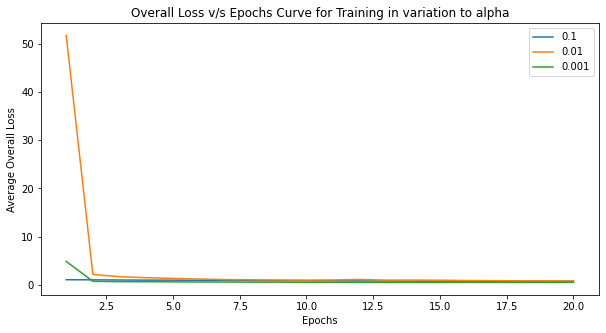

In [49]:
plt.figure(figsize=(10,5))
plt.plot([j for j in range(1,21)],[output_train_center_1[i][1] for i in range(0,20)])
plt.plot([j for j in range(1,21)],[output_train_center_2[i][1] for i in range(0,20)])
plt.plot([j for j in range(1,21)],[output_train_center_3[i][1] for i in range(0,20)])
plt.xlabel("Epochs")
plt.ylabel("Average Overall Loss")
plt.title("Overall Loss v/s Epochs Curve for Training in variation to alpha")
plt.legend(["0.1","0.01","0.001"])
plt.show()

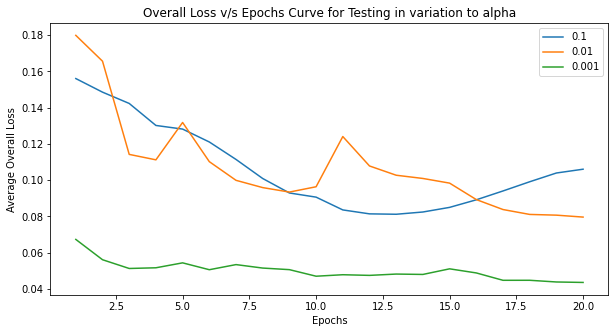

In [50]:
plt.figure(figsize=(10,5))
plt.plot([j for j in range(1,21)],[output_val_center_1[i][1] for i in range(0,20)])
plt.plot([j for j in range(1,21)],[output_val_center_2[i][1] for i in range(0,20)])
plt.plot([j for j in range(1,21)],[output_val_center_3[i][1] for i in range(0,20)])
plt.xlabel("Epochs")
plt.ylabel("Average Overall Loss")
plt.title("Overall Loss v/s Epochs Curve for Testing in variation to alpha")
plt.legend(["0.1","0.01","0.001"])
plt.show()

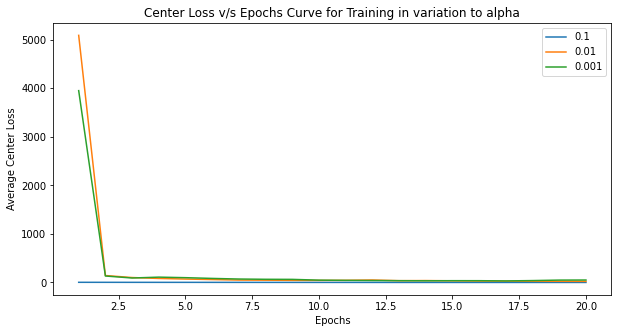

In [51]:
plt.figure(figsize=(10,5))
plt.plot([j for j in range(1,21)],[output_train_center_1[i][2] for i in range(0,20)])
plt.plot([j for j in range(1,21)],[output_train_center_2[i][2] for i in range(0,20)])
plt.plot([j for j in range(1,21)],[output_train_center_3[i][2] for i in range(0,20)])
plt.xlabel("Epochs")
plt.ylabel("Average Center Loss")
plt.title("Center Loss v/s Epochs Curve for Training in variation to alpha")
plt.legend(["0.1","0.01","0.001"])
plt.show()

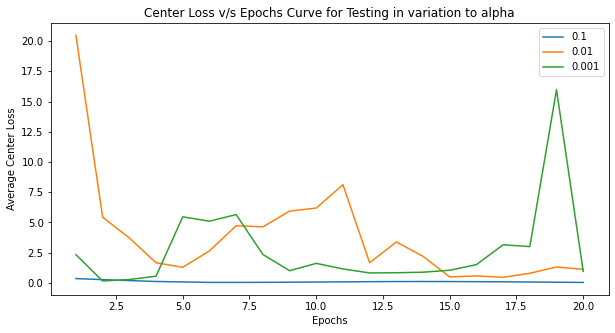

In [52]:
plt.figure(figsize=(10,5))
plt.plot([j for j in range(1,21)],[output_val_center_1[i][2] for i in range(0,20)])
plt.plot([j for j in range(1,21)],[output_val_center_2[i][2] for i in range(0,20)])
plt.plot([j for j in range(1,21)],[output_val_center_3[i][2] for i in range(0,20)])
plt.xlabel("Epochs")
plt.ylabel("Average Center Loss")
plt.title("Center Loss v/s Epochs Curve for Testing in variation to alpha")
plt.legend(["0.1","0.01","0.001"])
plt.show()

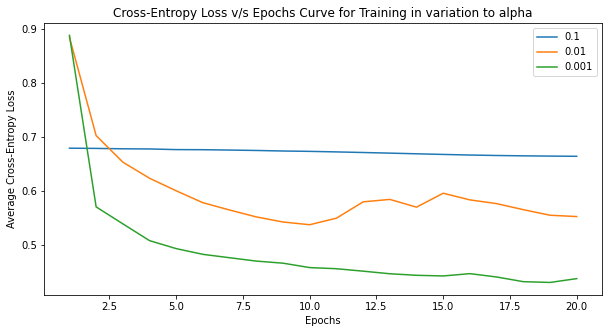

In [53]:
plt.figure(figsize=(10,5))
plt.plot([j for j in range(1,21)],[output_train_center_1[i][3] for i in range(0,20)])
plt.plot([j for j in range(1,21)],[output_train_center_2[i][3] for i in range(0,20)])
plt.plot([j for j in range(1,21)],[output_train_center_3[i][3] for i in range(0,20)])
plt.xlabel("Epochs")
plt.ylabel("Average Cross-Entropy Loss")
plt.title("Cross-Entropy Loss v/s Epochs Curve for Training in variation to alpha")
plt.legend(["0.1","0.01","0.001"])
plt.show()

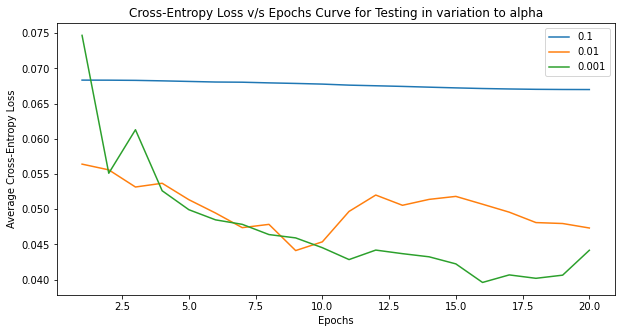

In [54]:
plt.figure(figsize=(10,5))
plt.plot([j for j in range(1,21)],[output_val_center_1[i][3] for i in range(0,20)])
plt.plot([j for j in range(1,21)],[output_val_center_2[i][3] for i in range(0,20)])
plt.plot([j for j in range(1,21)],[output_val_center_3[i][3] for i in range(0,20)])
plt.xlabel("Epochs")
plt.ylabel("Average Cross-Entropy Loss")
plt.title("Cross-Entropy Loss v/s Epochs Curve for Testing in variation to alpha")
plt.legend(["0.1","0.01","0.001"])
plt.show()

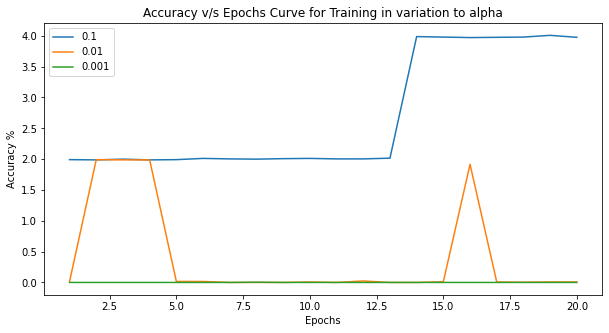

In [55]:
plt.figure(figsize=(10,5))
plt.plot([j for j in range(1,21)],[output_train_center_1[i][4].cpu().numpy() for i in range(0,20)])
plt.plot([j for j in range(1,21)],[output_train_center_2[i][4].cpu().numpy() for i in range(0,20)])
plt.plot([j for j in range(1,21)],[output_train_center_3[i][4].cpu().numpy() for i in range(0,20)])
plt.xlabel("Epochs")
plt.ylabel("Accuracy %")
plt.title("Accuracy v/s Epochs Curve for Training in variation to alpha")
plt.legend(["0.1","0.01","0.001"])
plt.show()

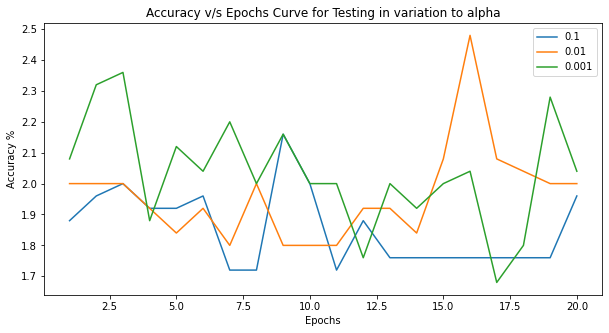

In [56]:
plt.figure(figsize=(10,5))
plt.plot([j for j in range(1,21)],[output_val_center_1[i][4].cpu().numpy() for i in range(0,20)])
plt.plot([j for j in range(1,21)],[output_val_center_2[i][4].cpu().numpy() for i in range(0,20)])
plt.plot([j for j in range(1,21)],[output_val_center_3[i][4].cpu().numpy() for i in range(0,20)])
plt.xlabel("Epochs")
plt.ylabel("Accuracy %")
plt.title("Accuracy v/s Epochs Curve for Testing in variation to alpha")
plt.legend(["0.1","0.01","0.001"])
plt.show()

## For lr_cent = 0.4 and Alpha = 0.1

In [12]:
resnet_model_center_0_4 = models.resnet18(pretrained=True)
n_input = resnet_model_center_0_4.fc.out_features
resnet_model_center_0_4.fc1 = torch.nn.Linear(n_input,2)
resnet_model_center_0_4.fc1_activation = torch.nn.LeakyReLU()
resnet_model_center_0_4.fc2 = torch.nn.Linear(2,50)
resnet_model_center_0_4.cuda()
model_loss = torch.nn.CrossEntropyLoss().cuda()
center_loss_0_4 = CenterLoss(50, 2, 500)
params_center_0_4 = list(resnet_model_center_0_4.parameters()) + list(center_loss_0_4.parameters())
optimizer_center_0_4 = torch.optim.Adam(params_center_0_4, lr=0.005)
resnet_model_center_0_4,output_train_center_0_4,output_val_center_0_4 = model_center_lr(train,val,20,resnet_model_center_0_4,new_model,model_loss,center_loss_0_4,optimizer_center_0_4,alpha=0.1, lr_cent=0.4, lr_optim=0.01)

  0%|          | 0/20 [00:00<?, ?it/s]

0.3343765437602997 3.062412738800049 0.0281352736055851
40.47577974200249 404.1943097114563 0.05634830519556999
44.73086902499199 446.541100025177 0.07675858028233051
47.89523121714592 478.02061319351196 0.09316939115524292
50.82326862215996 507.15622186660767 0.10764598846435547
51.93461439013481 518.0681147575378 0.12780248932540417
53.35300549864769 532.03045129776 0.14995990321040154
56.755228132009506 565.907534122467 0.16447400767356157
61.620162576437 614.4119744300842 0.17896392941474915
64.67608532309532 644.7268242835999 0.20340167544782162
66.29204973578453 660.7542309761047 0.2166254734620452
67.28725925087929 670.480872631073 0.23917079996317625
69.6939586699009 694.3029017448425 0.26366730127483606
72.98612108826637 726.9784121513367 0.2882784837856889
75.27784386277199 749.6650214195251 0.31134015414863825
75.73787659406662 754.1338858604431 0.3244864344596863
76.13402944803238 757.955409526825 0.3384869145229459
77.9432583451271 775.9334654808044 0.3499101949855685
78.7

  5%|▌         | 1/20 [1:12:51<23:04:15, 4371.34s/it]

0.9775487631559372 2.188386768102646 0.07188933901488781
0.22681601345539093 2.124156951904297 0.014400317333638668
0.7229835540056229 6.8620758056640625 0.03677594941109419
0.8322475254535675 7.828971683979034 0.04935033340007067
1.0913996696472168 10.300507366657257 0.06134890578687191
1.3344410210847855 12.604000866413116 0.07404091581702232
1.5698889940977097 14.733323395252228 0.09655663184821606
2.0882784575223923 19.705190002918243 0.117759445682168
2.1693591326475143 20.341565668582916 0.1352025531232357
2.2504531890153885 21.032509863376617 0.14720218814909458
2.3114973828196526 21.435197919607162 0.1679775770753622
2.9920574948191643 28.117041677236557 0.180353288538754
3.056617386639118 28.57990774512291 0.19862657133489847
3.1072868928313255 28.864894449710846 0.22079740557819605
3.138422453776002 28.969074428081512 0.2415149686858058
3.33035328425467 30.70320898294449 0.2600323362275958
3.435611614957452 31.64124685525894 0.271486877463758
3.470641950145364 31.860293716192

 10%|█         | 2/20 [1:14:04<9:12:52, 1842.94s/it] 

1.3079732954502106 14.286386966705322 0.07143502123653889
0.04084252193570137 0.2684653699398041 0.013995985500514507
0.14652923867106438 1.1390222609043121 0.03262700978666544
0.23323369398713112 1.8831834495067596 0.0449153408408165
0.5708916820585728 5.139609783887863 0.05693068169057369
0.5891679730266333 5.19860615581274 0.06930733565241098
0.8727638330310583 7.835620544850826 0.08920175116509199
1.2826685812324286 11.738679550588131 0.10880060587078333
1.598882993683219 14.736616514623165 0.1252213167026639
1.7417877819389105 16.04747297614813 0.1370404539629817
1.8077336307615042 16.51669042557478 0.1560645615682006
2.260575896129012 20.92181795090437 0.16839408222585917
2.4283240791410208 22.428561978042126 0.18546786811202765
2.544813958927989 23.3964389488101 0.20517004933208227
2.59655792824924 23.72708260267973 0.22384965512901545
2.7422801684588194 25.01672636717558 0.2406075233593583
2.7975012492388487 25.455953769385815 0.25190586410462856
2.909503487870097 26.4474686309

 15%|█▌        | 3/20 [1:15:17<4:53:13, 1034.90s/it]

1.070213958621025 2.748447060585022 0.07015364244580269
0.07202833890914917 0.5807908177375793 0.013949255459010601
0.1707807332277298 1.3983427286148071 0.0309464605525136
0.34059302508831024 2.9749799966812134 0.043095026165246964
0.6016791611909866 5.464974284172058 0.0551817212253809
0.6383149363100529 5.70879265666008 0.0674356585368514
0.8179898299276829 7.320788234472275 0.08591099921613932
1.2215534187853336 11.176371186971664 0.10391627345234156
1.3117485828697681 11.924411028623581 0.11930744908750057
1.351552251726389 12.20561996102333 0.1309902248904109
1.4030730165541172 12.544324159622192 0.14864057023078203
1.8793494440615177 17.18435311317444 0.16091408021748066
1.91160798817873 17.351392939686775 0.17646864149719477
1.9456283673644066 17.508922055363655 0.1947361072525382
1.9639041721820831 17.52043009735644 0.21186110842972994
2.1947011500597 19.6719882581383 0.22750225756317377
2.2241314835846424 19.852872679010034 0.23884414695203304
2.3596986569464207 21.0825038645

 20%|██        | 4/20 [1:16:30<2:54:42, 655.13s/it] 

0.549867570400238 2.4541568756103516 0.06921249441802502
0.08925987780094147 0.752728283405304 0.013987045735120773
0.17727544158697128 1.4756576418876648 0.029709668830037117
0.38048941642045975 3.386788070201874 0.041810610331594944
0.6659228876233101 6.116416871547699 0.05428119655698538
0.9205049052834511 8.538465917110443 0.06665830034762621
1.1963917687535286 11.124634206295013 0.08392833452671766
1.3686788752675056 12.683355391025543 0.1003433233126998
1.5742228105664253 14.59608393907547 0.11461440287530422
1.5983290672302246 14.720081932842731 0.12632086034864187
1.6584908664226532 15.159341014921665 0.14255675021559
1.853935495018959 16.988453425467014 0.15509013086557388
1.9956127107143402 18.258730448782444 0.16973964497447014
2.0261667370796204 18.40014149993658 0.18615256622433662
2.051803920418024 18.50213398039341 0.2015905026346445
2.2675926722586155 20.515299454331398 0.21606269851326942
2.295682154595852 20.681035175919533 0.2275786092504859
2.4583070799708366 22.181

 25%|██▌       | 5/20 [1:17:44<1:51:22, 445.48s/it]

0.6901407092809677 2.1918393671512604 0.06981292739510536
0.196658194065094 1.8245224952697754 0.014205952174961567
0.45385631918907166 4.256340265274048 0.02822228893637657
0.471248896792531 4.309410929679871 0.04030780028551817
0.7853950578719378 7.319661974906921 0.05342882592231035
0.8154843561351299 7.492393687367439 0.06624495331197977
0.9281806163489819 8.468110159039497 0.08136956486850977
1.1381071619689465 10.418606355786324 0.09624648466706276
1.2538069821894169 11.435531452298164 0.11025379132479429
1.2947693057358265 11.723270073533058 0.12244225014001131
1.3771832175552845 12.399435594677925 0.13723960891366005
1.6489889807999134 14.986491039395332 0.1503398260101676
1.7407356165349483 15.764736071228981 0.16426196042448282
1.8121752329170704 16.329810574650764 0.17919412534683943
1.8920216523110867 16.987587049603462 0.19326288998126984
1.936886005103588 17.297080352902412 0.20717791188508272
1.9849054738879204 17.655567064881325 0.21934870537370443
2.0383372455835342 18

 30%|███       | 6/20 [1:18:57<1:14:22, 318.78s/it]

0.553518995642662 0.14401717111468315 0.06956581491976976
0.07432974129915237 0.6036107540130615 0.013968665152788162
0.22896484285593033 2.0111122131347656 0.027853612788021564
0.2578914035111666 2.175993949174881 0.04029199946671724
0.45912562496960163 4.052866607904434 0.05383896455168724
0.48207282088696957 4.150199241936207 0.06705289799720049
0.6244006957858801 5.425970382988453 0.08180365711450577
0.8277592863887548 7.314305134117603 0.09632876981049776
0.9734671171754599 8.631833739578724 0.11028373334556818
1.001847205683589 8.790015034377575 0.12284569256007671
1.088214872404933 9.513297729194164 0.1368850888684392
1.2757541071623564 11.253269486129284 0.15042714960873127
1.392962759360671 12.28826218098402 0.16413653083145618
1.455134829506278 12.766606204211712 0.17847419623285532
1.53503399156034 13.427864842116833 0.19224749598652124
1.6020173113793135 13.959205083549023 0.20609679073095322
1.6638847012072802 14.451486490666866 0.21873603761196136
1.7403135020285845 15.07

 35%|███▌      | 7/20 [1:20:10<51:39, 238.40s/it]  

0.5248157680034637 0.1208971906453371 0.06919617298990488
0.06560013443231583 0.5176153779029846 0.013838598504662514
0.21310188621282578 1.8544915318489075 0.0276527376845479
0.23537227883934975 1.9503926932811737 0.04033301491290331
0.42222458496689796 3.6838376224040985 0.05384082533419132
0.4392753653228283 3.7213399969041348 0.06714136805385351
0.6115504316985607 5.295203622430563 0.08203007187694311
0.8582778982818127 7.6175574623048306 0.09652214962989092
1.017053734511137 9.066246207803488 0.11042910907417536
1.0444219131022692 9.213232483714819 0.12309866026043892
1.1303727570921183 9.93468889221549 0.1369038624688983
1.3010516557842493 11.505507793277502 0.1505008777603507
1.429951647296548 12.65761574730277 0.16419006790965796
1.4908943120390177 13.127387281507254 0.17815557960420847
1.5722105670720339 13.805431183427572 0.19166744407266378
1.6352255064994097 14.299075927585363 0.20531791262328625
1.7029192168265581 14.851126100867987 0.21780660189688206
1.731695981696248 15

 40%|████      | 8/20 [1:21:23<37:09, 185.81s/it]

0.48304351419210434 0.4522912949323654 0.06894601508975029
0.08099760860204697 0.6717783808708191 0.013819771818816662
0.2475283518433571 2.2013915181159973 0.027389205060899258
0.26117802038788795 2.2108045127242804 0.04009757377207279
0.49042489007115364 4.3673177268356085 0.05369312409311533
0.5120986495167017 4.450104376301169 0.06708821840584278
0.6245287004858255 5.433881005272269 0.08114060293883085
0.8114276323467493 7.1637539472430944 0.09505223575979471
0.9326143506914377 8.235074957832694 0.10910685174167156
0.9569603782147169 8.350287256762385 0.12193164974451065
1.035930735990405 9.00294023565948 0.13563671056181192
1.215118182823062 10.657381949946284 0.14937997795641422
1.323194233700633 11.599978564307094 0.16319636534899473
1.3827559296041727 12.057294009253383 0.1770265158265829
1.463051276281476 12.722532449290156 0.19079801999032497
1.5324251297861338 13.276095924898982 0.20481552090495825
1.5981379393488169 13.805105863139033 0.2176273362711072
1.6278086118400097 1

 45%|████▌     | 9/20 [1:22:36<27:35, 150.53s/it]

0.46450843662023544 0.12852754443883896 0.06829164456576109
0.0650014653801918 0.511883020401001 0.01381316315382719
0.21410537511110306 1.8694641590118408 0.027158960700035095
0.23117243684828281 1.9146898090839386 0.03970345761626959
0.4445124212652445 3.912921577692032 0.05322025064378977
0.46638395451009274 3.9988144487142563 0.06650249660015106
0.5834281053394079 5.032138213515282 0.08021427318453789
0.7563983555883169 6.626005038619041 0.0937978383153677
0.8924774285405874 7.850421413779259 0.10743527114391327
0.9228661153465509 8.027119144797325 0.12015418522059917
1.001693593338132 8.68023906648159 0.13366967253386974
1.1731088031083345 10.260001882910728 0.14710860326886177
1.2789780590683222 11.182378217577934 0.16074022185057402
1.3272423055022955 11.52904711663723 0.17433757707476616
1.3875526692718267 11.996924266219139 0.1878602234646678
1.4580386485904455 12.565467163920403 0.20149191562086344
1.505497818812728 12.908266887068748 0.2146711153909564
1.5446248929947615 13.

 50%|█████     | 10/20 [1:23:49<21:07, 126.78s/it]

0.4499141648411751 0.31922392547130585 0.06858326494693756
0.07231405377388 0.5870327353477478 0.013610783033072948
0.2217271775007248 1.947422444820404 0.026984937489032745
0.23604258988052607 1.963494598865509 0.03969313483685255
0.44791938457638025 3.947576105594635 0.05316177383065224
0.4706285083666444 4.0414555966854095 0.06648294813930988
0.5921974116936326 5.117439478635788 0.08045346476137638
0.7575752073898911 6.634268492460251 0.09414836298674345
0.8720099488273263 7.640437215566635 0.10796622931957245
0.9073480265215039 7.86640939116478 0.1207070890814066
0.978603539057076 8.442804962396622 0.13432304188609123
1.1479633869603276 10.000559002161026 0.1479074712842703
1.2462262632325292 10.844521433115005 0.1617741035297513
1.2934574456885457 11.18095138669014 0.1753622917458415
1.3618324073031545 11.728450328111649 0.18898736126720905
1.4255223767831922 12.226363450288773 0.20288601703941822
1.4874879019334912 12.721226841211319 0.21536520309746265
1.516441016457975 12.87780

 55%|█████▌    | 11/20 [1:25:02<16:32, 110.23s/it]

0.42788177728652954 0.1798100769519806 0.06862850394099951
0.06273842602968216 0.4898664951324463 0.013751772232353687
0.2053871676325798 1.7829110622406006 0.027096062898635864
0.2198336562141776 1.8008190002292395 0.039751757867634296
0.4178610583767295 3.6475815381854773 0.05310289841145277
0.437319683842361 3.710137164220214 0.06630596052855253
0.543140540830791 4.633545434102416 0.07978598773479462
0.7156730545684695 6.2243985291570425 0.09323317930102348
0.8357726959511638 7.2884538527578115 0.10692728497087955
0.8568759029731154 7.371077103540301 0.11976816598325968
0.9267732864245772 7.93579469434917 0.1331937862560153
1.0778037076815963 9.311019403859973 0.1467017363756895
1.1701516648754478 10.09912453405559 0.16023918148130178
1.21446234267205 10.407195372506976 0.17374277487397194
1.2804776011034846 10.932335896417499 0.18724398221820593
1.3427884308621287 11.419286204501987 0.20085978135466576
1.3920941082760692 11.780177040025592 0.21407637372612953
1.4178931703791022 11.

 60%|██████    | 12/20 [1:26:15<13:10, 98.86s/it] 

0.40931227803230286 0.2702655456960201 0.06865230854600668
0.06139645725488663 0.4770469665527344 0.01369176059961319
0.2001313790678978 1.731152057647705 0.0270161684602499
0.21390507649630308 1.742118664085865 0.03969320561736822
0.43115615379065275 3.779878444969654 0.05316828936338425
0.45128370355814695 3.8493590727448463 0.06634777691215277
0.5461159748956561 4.6630734577775 0.0798086067661643
0.711215446703136 6.179136194288731 0.093301797285676
0.8260893700644374 7.189811386168003 0.10710820090025663
0.8499535908922553 7.300621367990971 0.11989142280071974
0.911949242465198 7.785111017525196 0.1334381103515625
1.0572753502056003 9.10317987948656 0.1469573164358735
1.1419295249506831 9.812476642429829 0.16068181209266186
1.1812864346429706 10.070946879684925 0.1741916984319687
1.2428404381498694 10.550987102091312 0.18774167820811272
1.3037130376324058 11.020956732332706 0.20161731727421284
1.3524917354807258 11.376402623951435 0.21485142596065998
1.3756400616839528 11.475231036

 65%|██████▌   | 13/20 [1:27:28<10:37, 91.06s/it]

0.39717090129852295 0.2343970164656639 0.06836841814219952
0.05876839905977249 0.4519640803337097 0.01357198879122734
0.19807056337594986 1.711590588092804 0.02691148966550827
0.21156548149883747 1.7201387183740735 0.039551595225930214
0.40958076901733875 3.56754641700536 0.05282612144947052
0.428397461771965 3.6245690817013383 0.06594054773449898
0.5227825939655304 4.43453558627516 0.07932902872562408
0.6861573159694672 5.934662067331374 0.09269109927117825
0.7937155812978745 6.87290742341429 0.10642483085393906
0.811967933550477 6.926464308984578 0.11932149436324835
0.8753031883388758 7.426103820092976 0.13269279431551695
1.0114949587732553 8.653624524362385 0.14613249339163303
1.0963559839874506 9.36679928470403 0.15967603586614132
1.13581239618361 9.627211977727711 0.17309118062257767
1.1992536056786776 10.127282907254994 0.18652529548853636
1.2578239310532808 10.578318377025425 0.1999920764937997
1.3064382057636976 10.931723733432591 0.21326581481844187
1.325742207467556 10.992996

 70%|███████   | 14/20 [1:28:41<08:34, 85.67s/it]

0.38728341460227966 0.3149229660630226 0.06871671881526709
0.05753418058156967 0.43949976563453674 0.013584204949438572
0.19967810064554214 1.7270328104496002 0.026974824257194996
0.21291844733059406 1.7311131111346185 0.039807140827178955
0.4077999759465456 3.5463663688860834 0.05316333193331957
0.42722384817898273 3.60932402824983 0.06629143748432398
0.515042619779706 4.35383873200044 0.0796587411314249
0.6768111456185579 5.837077071424574 0.0931034293025732
0.7728689033538103 6.660552968736738 0.10681359469890594
0.7891597170382738 6.693458703812212 0.11981383431702852
0.8476213607937098 7.142680821474642 0.13335326500236988
0.9781694803386927 8.31292956834659 0.1468765027821064
1.0577782113105059 8.971531388815492 0.16062505077570677
1.0939955357462168 9.198533622082323 0.17414215207099915
1.1565338987857103 9.687963185366243 0.18773755710572004
1.213523844256997 10.118765143211931 0.20164730586111546
1.2595875952392817 10.445293245371431 0.21505824755877256
1.2772216834127903 10.4

 75%|███████▌  | 15/20 [1:29:54<06:49, 81.84s/it]

0.3744247332215309 0.3224457800388336 0.06832634098827839
0.05628467723727226 0.4270751476287842 0.013577163219451904
0.19635040685534477 1.6941155195236206 0.026938862167298794
0.2096049003303051 1.6981180179864168 0.0397931057959795
0.422217782586813 3.6908851135522127 0.053129266016185284
0.44140053167939186 3.7519429307430983 0.06620623357594013
0.5230003632605076 4.434386668726802 0.0795616889372468
0.6790506578981876 5.8615497928112745 0.09289566799998283
0.7647767104208469 6.581390915438533 0.10663760732859373
0.7796879578381777 6.6001609936356544 0.1196718467399478
0.831105375662446 6.980559326708317 0.13304943311959505
0.9563309643417597 8.09863505512476 0.1464674500748515
1.029976623132825 8.699241198599339 0.1600524913519621
1.0631015207618475 8.896361447870731 0.17346536368131638
1.1199034582823515 9.329913206398487 0.18691212218254805
1.1733106765896082 9.728146143257618 0.20049604773521423
1.2163912486284971 10.0249258056283 0.21389865223318338
1.2336773313581944 10.06517

 80%|████████  | 16/20 [1:31:07<05:16, 79.01s/it]

0.35980594903230667 0.2577242814004421 0.06907852366566658
0.05471452325582504 0.41077205538749695 0.013637316413223743
0.18888749927282333 1.6172543466091156 0.027162060141563416
0.2023116024211049 1.6218504500575364 0.04012655280530453
0.39946640748530626 3.4590259385295212 0.05356381181627512
0.4186030561104417 3.519335762131959 0.06666947714984417
0.49674990121275187 4.1670768414624035 0.0800422104075551
0.6490810448303819 5.5553355370648205 0.09354747273027897
0.7336448514834046 6.2635816489346325 0.10728666000068188
0.7475914424285293 6.271770352032036 0.12041438091546297
0.7993009751662612 6.653209650423378 0.13397998549044132
0.9175150161609054 7.699862682726234 0.14752872101962566
0.9883401906117797 8.270603084471077 0.16127985529601574
1.0179860619828105 8.431400963570923 0.1748459367081523
1.0724788894876838 8.84004465630278 0.18847439344972372
1.125512263737619 9.231126347091049 0.2023996002972126
1.1659706262871623 9.500530132558197 0.2159175844863057
1.1819730130955577 9.

 85%|████████▌ | 17/20 [1:32:20<03:51, 77.29s/it]

0.3537796437740326 0.3570815175771713 0.0681957183405757
0.05392230674624443 0.40332356095314026 0.013589948415756226
0.1922830007970333 1.653026968240738 0.026980298571288586
0.20587413106113672 1.660606156103313 0.03981351014226675
0.39948365185409784 3.464684377424419 0.053015210665762424
0.4197733672335744 3.53659291844815 0.06611407082527876
0.4924145611003041 4.1294392524287105 0.07947062700986862
0.6419913591817021 5.492018359713256 0.09278950560837984
0.7202532859519124 6.137229341082275 0.10653033386915922
0.7343037566170096 6.145937723107636 0.11970996670424938
0.7818450285121799 6.486927968449891 0.1331522148102522
0.8965582801029086 7.500025850720704 0.14655567612499
0.9640470100566745 8.038552028127015 0.16019178926944733
0.9910724898800254 8.17470928747207 0.17360154166817665
1.0421624733135104 8.551386979408562 0.1870237560942769
1.0928183300420642 8.92227288801223 0.20059101935476065
1.1331965615972877 9.192891892977059 0.21390735171735287
1.1482420088723302 9.210914692

 90%|█████████ | 18/20 [1:33:33<02:32, 76.11s/it]

0.3455419987440109 0.3732556104660034 0.06905008107423782
0.04933398962020874 0.3565964996814728 0.013674335554242134
0.18765825033187866 1.6043758690357208 0.02722066268324852
0.20121083967387676 1.6093998737633228 0.04027085192501545
0.39242839626967907 3.3876167125999928 0.05366672482341528
0.4132602382451296 3.4637925438582897 0.06688098423182964
0.48024272359907627 3.9998258762061596 0.08026013895869255
0.6284486446529627 5.347023885697126 0.09374625887721777
0.6985600981861353 5.911033194512129 0.10745677631348372
0.7119883261620998 5.912826259853318 0.12070569768548012
0.7562081962823868 6.219303866149858 0.13427780661731958
0.8660217076539993 7.1825716097373515 0.14776454120874405
0.9283746480941772 7.668651481391862 0.16150949709117413
0.9521534442901611 7.77101053786464 0.17505238763988018
1.0023822896182537 8.136464168550447 0.18873587157577276
1.0531701482832432 8.505901982309297 0.20257994905114174
1.0880227647721767 8.71908297133632 0.21611446794122458
1.1024831095710397 

 95%|█████████▌| 19/20 [1:34:48<01:15, 75.54s/it]

0.33789483457803726 0.3978436440229416 0.06842026486992836
0.05442136526107788 0.40709248185157776 0.01371211651712656
0.18409352004528046 1.568562537431717 0.027237264439463615
0.19768692180514336 1.5739776049740613 0.04028915986418724
0.39373786374926567 3.401007190812379 0.053637138567864895
0.41648419573903084 3.4959235568530858 0.06689183413982391
0.47867605462670326 3.982856132555753 0.0803904365748167
0.622512836009264 5.286995865870267 0.09381324239075184
0.6928618885576725 5.851873733568937 0.10767450742423534
0.7071669716387987 5.861701037269086 0.12099685985594988
0.7544938158243895 6.198772843461484 0.13461652118712664
0.8635120820254087 7.154202695470303 0.1480917977169156
0.9245281349867582 7.626413221936673 0.16188679821789265
0.953416520729661 7.778885151725262 0.17552799172699451
0.9837045911699533 7.947223003488034 0.18898227531462908
1.0267330836504698 8.241350080352277 0.20259806141257286
1.0623786132782698 8.466642464976758 0.21571435406804085
1.0798140317201614 8.

100%|██████████| 20/20 [1:36:01<00:00, 288.09s/it]

0.3175651803612709 0.1821046881377697 0.0691887317225337


## For lr_cent = 0.3 and Alpha = 0.1

In [14]:
resnet_model_center_0_3 = models.resnet18(pretrained=True)
resnet_model_center_0_3.fc1 = torch.nn.Linear(n_input,2)
resnet_model_center_0_3.fc1_activation = torch.nn.LeakyReLU()
resnet_model_center_0_3.fc2 = torch.nn.Linear(2,50)
resnet_model_center_0_3.cuda()
center_loss_0_3 = CenterLoss(50, 2, 500)
params_center_0_3 = list(resnet_model_center_0_3.parameters()) + list(center_loss_0_3.parameters())
optimizer_center_0_3 = torch.optim.Adam(params_center_0_3, lr=0.005)
resnet_model_center_0_3,output_train_center_0_3,output_val_center_0_3 = model_center_lr(train,val,20,resnet_model_center_0_3,new_model,model_loss,center_loss_0_3,optimizer_center_0_3,alpha=0.1, lr_cent=0.3, lr_optim=0.01)

  0%|          | 0/20 [00:00<?, ?it/s]

0.40943804383277893 3.8130276203155518 0.0281352736055851
87.74454393982887 876.8545925617218 0.05907635949552059
92.89383020997047 928.1658833026886 0.07723344303667545
94.18802538514137 940.9197294712067 0.09604390524327755
99.25905695557594 991.4788954257965 0.11115881707519293
100.71115484833717 1005.8005335330963 0.13109285477548838
101.80828967690468 1016.6215965747833 0.14612136501818895
102.23836746811867 1020.7101571559906 0.16734309028834105
108.95051565766335 1087.6702859401703 0.1834782948717475
114.75091400742531 1145.5389459133148 0.19701026659458876
118.37760391831398 1181.611516714096 0.21644299756735563
118.83409681916237 1186.0564210414886 0.22844547219574451
119.18625274300575 1189.3378677368164 0.2524567171931267
120.15228798985481 1198.756510734558 0.27662763372063637
121.75198748707771 1214.5086603164673 0.3011121153831482
124.08573868870735 1237.707127571106 0.31501633673906326
125.69095316529274 1253.5658292770386 0.33436062559485435
126.53116819262505 1261.7438

  5%|▌         | 1/20 [01:32<29:25, 92.90s/it]

1.6983645856380463 15.677165985107422 0.06233891472220421
0.24962835013866425 2.317751169204712 0.017853235825896263
0.3456709384918213 3.1494919061660767 0.030721749179065228
0.42963196337223053 3.855879783630371 0.044043983332812786
0.49576763063669205 4.283148169517517 0.06745280791074038
0.5945249199867249 5.12029629945755 0.08249528426676989
1.19331294298172 10.936188995838165 0.09969404805451632
1.3382977098226547 12.263932883739471 0.11190442088991404
1.6622636765241623 15.292495906352997 0.1330141006037593
1.9947448521852493 18.48692387342453 0.14605246391147375
2.5367765575647354 23.795386970043182 0.15723789669573307
2.871346279978752 26.98721545934677 0.17262476682662964
3.005164697766304 28.19907981157303 0.18525675404816866
3.43606273829937 32.24995404481888 0.21106735337525606
3.662714511156082 34.288247644901276 0.23388975765556097
3.695911418646574 34.379588425159454 0.25795258674770594
4.022963117808104 37.52948409318924 0.2700147219002247
4.098888780921698 38.11951547

 10%|█         | 2/20 [02:47<24:34, 81.89s/it]

0.7406168580055237 19.4475519657135 0.061406674794852734
0.07092028856277466 0.5412593483924866 0.016794349998235703
0.4777500331401825 4.4846311211586 0.029286906123161316
0.5949221476912498 5.525517165660858 0.04237041715532541
0.8208091780543327 7.564039409160614 0.06440522614866495
0.9179406687617302 8.388485252857208 0.07909213285893202
1.6242096945643425 15.289998352527618 0.0952098285779357
2.282634489238262 21.754800617694855 0.10715438798069954
2.702272318303585 25.766256630420685 0.12564660422503948
2.8321172669529915 26.9395369887352 0.13816351909190416
3.7437717989087105 35.9447221159935 0.1492995172739029
3.8087737187743187 36.443392634391785 0.16443438082933426
4.333908818662167 41.56936824321747 0.1769719049334526
4.735740564763546 45.35887920856476 0.19985253550112247
5.146454833447933 49.25738775730133 0.2207159623503685
5.383384741842747 51.40989863872528 0.24239478819072247
5.400545934215188 51.46260169520974 0.25428567454218864
5.607298294082284 53.37115803733468 0.

 15%|█▌        | 3/20 [04:01<22:12, 78.40s/it]

0.7163053154945374 12.480450868606567 0.061634890735149384
0.024155836552381516 0.08414936065673828 0.015740901231765747
0.16858592256903648 1.4070162773132324 0.027884287759661674
0.18961796537041664 1.4872994348406792 0.04088801518082619
0.39348531141877174 3.3376649543642998 0.05971881188452244
0.42959480360150337 3.555820994079113 0.07401270233094692
0.840712059289217 7.513807587325573 0.08933129999786615
1.1018454320728779 10.008584789931774 0.10098693612962961
1.3990510888397694 12.806146435439587 0.11843643616884947
1.4452615454792976 13.145895056426525 0.13067202921956778
1.880722500383854 17.38866477459669 0.14185599517077208
1.9380162581801414 17.813782684504986 0.156637960113585
2.5049506053328514 23.35848092287779 0.16910247690975666
2.7338733300566673 25.441924564540386 0.18968082778155804
2.829792805016041 26.210647396743298 0.2087280210107565
2.9328627213835716 27.033875815570354 0.2294750977307558
2.9571643620729446 27.15883233398199 0.2412810865789652
3.325169876217842

 20%|██        | 4/20 [05:15<20:28, 76.77s/it]

0.8961022347211838 17.071975469589233 0.06185232661664486
0.03553882613778114 0.20264939963817596 0.015273886732757092
0.10044894739985466 0.7315447777509689 0.027294471859931946
0.1161537654697895 0.7595644015818834 0.040197327733039856
0.2597914822399616 2.0182467717677355 0.05796680226922035
0.32642655447125435 2.5401623863726854 0.07241030968725681
0.6163348741829395 5.291107477620244 0.08722410816699266
0.8156176544725895 7.167678298428655 0.09884980041533709
1.0375606454908848 9.231321277096868 0.1144284950569272
1.0899203084409237 9.633616330102086 0.1265586530789733
1.4097209237515926 12.719190003350377 0.13780190981924534
1.495187621563673 13.425805630162358 0.15260704327374697
2.02900717779994 18.639349522069097 0.16507225017994642
2.228872235864401 20.449786843732 0.18389357533305883
2.2816503308713436 20.796895625069737 0.20196079183369875
2.372450802475214 21.500742794945836 0.222376543097198
2.3986684922128916 21.64396414346993 0.23427209816873074
2.6990806106477976 24.49

 25%|██▌       | 5/20 [06:29<18:56, 75.76s/it]

1.125089943408966 20.11603355407715 0.06228610873222351
0.09427203238010406 0.7867997884750366 0.015592056326568127
0.1567464843392372 1.2911558747291565 0.02763089630752802
0.18471891060471535 1.4412112832069397 0.04059778153896332
0.34187066927552223 2.8343207240104675 0.05843859910964966
0.4321563355624676 3.5949376821517944 0.07266256958246231
0.6747104339301586 5.871135115623474 0.08759692218154669
0.8435102365911007 7.4420905113220215 0.09930119104683399
1.0690880827605724 9.541920185089111 0.11489605810493231
1.1217594258487225 9.94608423113823 0.12715099472552538
1.3577003441751003 12.191616982221603 0.13853864092379808
1.4664062671363354 13.12977620959282 0.15342864207923412
1.9263580553233624 17.60431072115898 0.16592696588486433
2.13131907209754 19.463340371847153 0.1849850108847022
2.162353079766035 19.593694508075714 0.20298360381275415
2.194364797323942 19.736333027482033 0.22073146793991327
2.266945715993643 20.34135915338993 0.23280977364629507
2.4612404368817806 22.138

 30%|███       | 6/20 [07:43<17:31, 75.08s/it]

0.8181432783603668 6.8969422578811646 0.06277211010456085
0.08929693698883057 0.7458474636077881 0.014712190255522728
0.19965407997369766 1.7299214601516724 0.026661932468414307
0.23567738756537437 1.9607729762792587 0.03960008826106787
0.3292389027774334 2.7414502948522568 0.055093864910304546
0.4083254747092724 3.3955102413892746 0.06877444218844175
0.6908516995608807 6.079043194651604 0.08294735662639141
0.942950677126646 8.482404753565788 0.09471017401665449
1.1944394819438457 10.854741379618645 0.1089653130620718
1.2561025619506836 11.351397141814232 0.12096281629055738
1.4049206674098969 12.726455315947533 0.13227510079741478
1.5321448594331741 13.857444867491722 0.14640033897012472
2.0148209780454636 18.557812318205833 0.15903971996158361
2.2588856518268585 20.826834067702293 0.17620221804827452
2.2928544878959656 21.003785490989685 0.1924759102985263
2.399697981774807 21.898396134376526 0.20985834021121264
2.6063042506575584 23.840197682380676 0.222284447401762
2.67829824239015

 35%|███▌      | 7/20 [08:57<16:10, 74.68s/it]

0.8170598298311234 7.0063018798828125 0.06389503367245197
0.03467980772256851 0.20244033634662628 0.014435773715376854
0.06975065171718597 0.43316638469696045 0.026434010826051235
0.14023908227682114 1.0070545077323914 0.03953362815082073
0.18557725846767426 1.3072915971279144 0.054848095402121544
0.31045716255903244 2.4201631247997284 0.06844084337353706
0.6316647753119469 5.489621847867966 0.0827025668695569
0.9498788043856621 8.550985783338547 0.09478020295500755
1.284509263932705 11.760265797376633 0.10848264768719673
1.3069153521209955 11.862944796681404 0.12062083557248116
1.4907296244055033 13.583103135228157 0.13241927325725555
1.5532178673893213 14.067489102482796 0.14646891690790653
2.1984183583408594 20.39310832321644 0.15910745970904827
2.4321272764354944 22.570320323109627 0.17509516887366772
2.526383141055703 23.36197479069233 0.1901855831965804
2.725751781836152 25.200816228985786 0.20567008387297392
3.1209739092737436 29.028082206845284 0.2181655950844288
3.152267673984

 40%|████      | 8/20 [10:11<14:54, 74.50s/it]

0.5569460541009903 3.5579532384872437 0.06343238055706024
0.03573299199342728 0.21592137217521667 0.014140852726995945
0.16540458053350449 1.3910526931285858 0.026299303397536278
0.1808958174660802 1.4152638483792543 0.03936942480504513
0.27922405768185854 2.2535519767552614 0.0538688525557518
0.34125823248177767 2.737789051607251 0.0674793180078268
0.6109342621639371 5.296165840700269 0.08131768275052309
0.8812447534874082 7.877699511125684 0.09347480535507202
1.1996283875778317 10.923578636720777 0.10727049503475428
1.2680780859664083 11.48557342775166 0.11952071264386177
1.338015933521092 12.063617007806897 0.13165420200675726
1.532972981221974 13.873583929613233 0.14561454113572836
1.9700286881998181 18.115333693102002 0.1584952576085925
2.0595664056017995 18.86042590625584 0.17352374736219645
2.123323325999081 19.35332645662129 0.1879906076937914
2.2795083420351148 20.765383856371045 0.2029698844999075
2.6661454932764173 24.50234474427998 0.2159109404310584
2.694580645300448 24.64

 45%|████▌     | 9/20 [11:25<13:37, 74.29s/it]

0.5372462496161461 1.9950227439403534 0.06371214054524899
0.03842651844024658 0.2436952143907547 0.014056997373700142
0.15780621021986008 1.3128503113985062 0.02652117609977722
0.17334769293665886 1.3366593085229397 0.03968175873160362
0.27031010761857033 2.1637878380715847 0.05393132381141186
0.3263084180653095 2.588538493961096 0.06745456531643867
0.6170121319591999 5.358387794345617 0.08117335103452206
0.8863161988556385 7.930326785892248 0.0932835154235363
1.1630894728004932 10.562444534152746 0.10684499889612198
1.2553333826363087 11.363235142081976 0.1190098449587822
1.3003712892532349 11.690705921500921 0.13130067382007837
1.522935539484024 13.780311491340399 0.14490436110645533
1.8648992478847504 17.070304062217474 0.1578688295558095
1.928749367594719 17.561348106712103 0.1726145427674055
1.978042647242546 17.912304904311895 0.1868121437728405
2.0985788106918335 18.970737483352423 0.2015050482004881
2.456089675426483 22.418686654418707 0.21422098949551582
2.4768615905195475 22.

 50%|█████     | 10/20 [12:38<12:21, 74.11s/it]

0.569659486413002 0.6304770708084106 0.06355417426675558
0.07084766775369644 0.5685772895812988 0.01398993656039238
0.26804883033037186 2.4144716262817383 0.026601663790643215
0.3022851198911667 2.627629041671753 0.03952221293002367
0.4485471397638321 3.9507951736450195 0.053467621095478535
0.48785587400197983 4.208217173814774 0.0670341532677412
0.766046367585659 6.85287407040596 0.0807589553296566
0.9346669092774391 8.41337063908577 0.09332984127104282
1.141365148127079 10.345050245523453 0.10686010494828224
1.2229313775897026 11.034357756376266 0.11949558090418577
1.2631366811692715 11.310052812099457 0.13213137816637754
1.5020519457757473 13.562498271465302 0.14580208715051413
1.7717327736318111 16.128454625606537 0.15888726152479649
1.820934347808361 16.474269419908524 0.1735073570162058
1.8584468103945255 16.70892323553562 0.18755443766713142
1.9341210760176182 17.32100023329258 0.20202100183814764
2.190673593431711 19.754593268036842 0.21521419659256935
2.2055417578667402 19.766

 55%|█████▌    | 11/20 [13:52<11:06, 74.00s/it]

0.5762661844491959 0.8406378328800201 0.06409682799130678
0.07068406045436859 0.5675067901611328 0.013933376409113407
0.292282834649086 2.656400442123413 0.02664277795702219
0.32607441395521164 2.8640122562646866 0.03967317659407854
0.4974426403641701 4.4385218769311905 0.053590442053973675
0.5397070348262787 4.726147875189781 0.0670922389253974
0.8134590685367584 7.326069816946983 0.08085207361727953
0.929700218141079 8.36206541955471 0.09349365998059511
1.0816351547837257 9.745862111449242 0.10704892314970493
1.150364525616169 10.305767104029655 0.11978779826313257
1.2077365405857563 10.753196492791176 0.13241687417030334
1.4050077684223652 12.588621631264687 0.1461455849930644
1.6595198400318623 15.002151027321815 0.15930472034960985
1.7302447445690632 15.561982467770576 0.17404648382216692
1.7574948873370886 15.69496537744999 0.18799833580851555
1.8297696616500616 16.274626925587654 0.2023069579154253
2.0791865792125463 18.635968402028084 0.21558972261846066
2.0949151627719402 18.6

 60%|██████    | 12/20 [15:06<09:51, 74.00s/it]

0.5378135070204735 0.9708745032548904 0.06413743365556002
0.058879509568214417 0.4500003159046173 0.013879479840397835
0.2666739523410797 2.399933248758316 0.02668062597513199
0.2993280962109566 2.5959332287311554 0.039734773337841034
0.47042692452669144 4.16841784119606 0.05358513258397579
0.5102090314030647 4.431284606456757 0.06708056200295687
0.7783470824360847 6.974807441234589 0.08086632005870342
0.857403077185154 7.641416609287262 0.09326139744371176
0.9846682026982307 8.778477132320404 0.10682046320289373
1.0473313108086586 9.276286244392395 0.11970265489071608
1.1189686730504036 9.865062534809113 0.13246239256113768
1.2787025645375252 11.325301587581635 0.14617236889898777
1.5518104508519173 13.925284802913666 0.15928192902356386
1.6356963962316513 14.620054423809052 0.1736909095197916
1.6614232249557972 14.738449782133102 0.1875782022252679
1.748504128307104 15.466784507036209 0.2018256327137351
2.033957924693823 18.190408259630203 0.21491705067455769
2.0515801571309566 18.22

 65%|██████▌   | 13/20 [16:20<08:37, 73.93s/it]

0.4965943470597267 1.2865538895130157 0.06449044682085514
0.04799678921699524 0.3403944671154022 0.013957338407635689
0.24214059114456177 2.153176039457321 0.026822982355952263
0.265127457678318 2.25088170170784 0.040039281360805035
0.4244975075125694 3.706970125436783 0.053800483234226704
0.45727095007896423 3.899328127503395 0.06733812391757965
0.7208428084850311 6.3977421671152115 0.08106857631355524
0.8054239675402641 7.1155965477228165 0.09386429563164711
0.9126090630888939 8.051245167851448 0.10748452786356211
0.9742923341691494 8.538260146975517 0.12046630028635263
1.0541579835116863 9.208739444613457 0.13328402023762465
1.1948340646922588 10.479412600398064 0.14689278230071068
1.4631157033145428 13.030431315302849 0.16007254645228386
1.5493820495903492 13.751780971884727 0.1742039304226637
1.5768774505704641 13.888094753026962 0.18806795310229063
1.667549004778266 14.654030114412308 0.20214596949517727
1.9574537184089422 17.419178992509842 0.21553580556064844
1.9795952662825584

 70%|███████   | 14/20 [17:33<07:22, 73.82s/it]

0.5188962742686272 1.0324222594499588 0.06360951345413923
0.05487953498959541 0.41180866956710815 0.013698668219149113
0.27292031422257423 2.464751660823822 0.026445157825946808
0.31022026762366295 2.7074195593595505 0.03947831876575947
0.44963740929961205 3.9638845175504684 0.05324895866215229
0.4843846224248409 4.176537126302719 0.0667309109121561
0.7364226840436459 6.558094829320908 0.0806132098659873
0.8212336637079716 7.278362184762955 0.09339745249599218
0.9108100421726704 8.032621890306473 0.10754785221070051
0.9705079682171345 8.499929010868073 0.12051506526768208
1.0280207730829716 8.944514721632004 0.13356930017471313
1.163378182798624 10.160398095846176 0.14733836241066456
1.4068571515381336 12.462899774312973 0.16056716348975897
1.4943447522819042 13.19427564740181 0.1749171745032072
1.5166027154773474 13.279507741332054 0.18865192774683237
1.5898418184369802 13.87189482152462 0.2026523184031248
1.8621270712465048 16.46195910871029 0.21593113616108894
1.8837683573365211 16.

 75%|███████▌  | 15/20 [18:47<06:08, 73.73s/it]

0.437206968665123 2.148893177509308 0.06491621024906635
0.024917293339967728 0.1099277064204216 0.013924521394073963
0.18693673983216286 1.60094802826643 0.026841935701668262
0.21469201892614365 1.7479334846138954 0.03989867027848959
0.40245137363672256 3.4854007735848427 0.053911290131509304
0.42727748304605484 3.598282068967819 0.06744926888495684
0.682744599878788 6.016082018613815 0.0811363747343421
0.7798541486263275 6.856648236513138 0.0941893020644784
0.8871951103210449 7.792520493268967 0.10794303566217422
0.9522697106003761 8.31162366271019 0.12110731471329927
1.00894271209836 8.74727600812912 0.13421508017927408
1.1566693224012852 10.087785542011261 0.14789073821157217
1.3779987432062626 12.168548166751862 0.16114388778805733
1.4612386114895344 12.85801637172699 0.1754369307309389
1.4866752345114946 12.973784886300564 0.18929670192301273
1.562972852960229 13.597685657441616 0.20320424158126116
1.8224795553833246 16.05696614831686 0.2167828930541873
1.843451950699091 16.131081

 80%|████████  | 16/20 [20:00<04:54, 73.62s/it]

0.40823720395565033 2.3046033084392548 0.06526767276227474
0.025979895144701004 0.12121693789958954 0.013858200050890446
0.17762555554509163 1.5075102299451828 0.026874534785747528
0.1947076916694641 1.545282319188118 0.04017946217209101
0.32296115159988403 2.6909012347459793 0.053871036507189274
0.34513478353619576 2.7773576006293297 0.06739903055131435
0.6021650023758411 5.209943555295467 0.08117064274847507
0.6925606988370419 5.982997380197048 0.09426095802336931
0.7969767488539219 6.890434168279171 0.10793332662433386
0.8653649799525738 7.440775357186794 0.12128743529319763
0.9257497116923332 7.915283732116222 0.1342213312163949
1.0730106607079506 9.251083545386791 0.14790230244398117
1.2808253541588783 11.196165971457958 0.16120875999331474
1.3552941381931305 11.80115281790495 0.1751788565889001
1.3746236599981785 11.858359791338444 0.18878768011927605
1.4510615728795528 12.483713366091251 0.20269023533910513
1.712995644658804 14.96777556091547 0.21621807664632797
1.73609008640050

 85%|████████▌ | 17/20 [21:13<03:39, 73.26s/it]

0.39334047585725784 2.1462535858154297 0.06510940846055746
0.02187548205256462 0.08056646585464478 0.013818835839629173
0.16382677480578423 1.3696233630180359 0.026864429004490376
0.17954987101256847 1.3931318018585443 0.04023668169975281
0.28941853903234005 2.3558307979255915 0.05383545160293579
0.3125338423997164 2.452408330515027 0.0672930022701621
0.5548599828034639 4.738315599039197 0.08102841675281525
0.6465866286307573 5.52443309314549 0.09414331149309874
0.7521493602544069 6.443497674539685 0.10779958683997393
0.8157004732638597 6.947017090395093 0.12099875882267952
0.8720694426447153 7.380885826423764 0.1339808562770486
1.0245192144066095 8.769347297027707 0.1475844830274582
1.2173713836818933 10.564676271751523 0.1609037509188056
1.282718824222684 11.079305158928037 0.1747883027419448
1.3019167929887772 11.135270619764924 0.18838972598314285
1.3686835542321205 11.664721930399537 0.202211351133883
1.6185705438256264 14.029288494959474 0.21564168017357588
1.6392373405396938 14.

 90%|█████████ | 18/20 [22:26<02:26, 73.12s/it]

0.37837137281894684 2.335144579410553 0.06510209292173386
0.01910097524523735 0.052587274461984634 0.013842247426509857
0.15759677812457085 1.3068928755819798 0.026907476596534252
0.17420229502022266 1.339146926999092 0.04028758779168129
0.28160458244383335 2.2776866108179092 0.05383590515702963
0.30261378176510334 2.353174217045307 0.06729634385555983
0.5496361125260592 4.6861875131726265 0.08101735357195139
0.637551935389638 5.434052236378193 0.09414669685065746
0.7392525542527437 6.314959652721882 0.10775657463818789
0.8097456488758326 6.886417396366596 0.12110389489680529
0.8558498676866293 7.215723879635334 0.1342774648219347
1.012639096006751 8.647413022816181 0.147897781804204
1.1872770246118307 10.260229714214802 0.16125403251498938
1.2516552414745092 10.765661247074604 0.17508909478783607
1.268488334491849 10.798275396227837 0.18866077344864607
1.3264211993664503 11.240321442484856 0.2023890344426036
1.5489938389509916 13.329551979899406 0.2160386173054576
1.5691998712718487 1

 95%|█████████▌| 19/20 [23:39<01:13, 73.24s/it]

0.3632534220814705 2.1982277929782867 0.06499124225229025
0.01843905821442604 0.046210359781980515 0.013818022795021534
0.15591349080204964 1.2900545112788677 0.02690803073346615
0.17242290824651718 1.3215349651873112 0.04026940185576677
0.2771846577525139 2.233928833156824 0.05379176791757345
0.29687928408384323 2.296730902045965 0.06720618810504675
0.5393778756260872 4.584713842719793 0.08090647775679827
0.6217575594782829 5.277029182761908 0.09405462723225355
0.715339869260788 6.076905217021704 0.10764932818710804
0.7852358147501945 6.642493572086096 0.12098643835633993
0.8302289731800556 6.960551228374243 0.1341738309711218
0.9835606552660465 8.357989516109228 0.14776168204843998
1.1476188339293003 9.864916648715734 0.16112713795155287
1.2123490460217 10.374271776527166 0.17492183297872543
1.228084709495306 10.39653523080051 0.18843115027993917
1.282738160341978 10.806481225416064 0.20209000166505575
1.4965423755347729 12.807795388624072 0.21576279494911432
1.5165735054761171 12.87

100%|██████████| 20/20 [24:52<00:00, 74.64s/it]

0.3492656499147415 2.095029056072235 0.06500068120658398


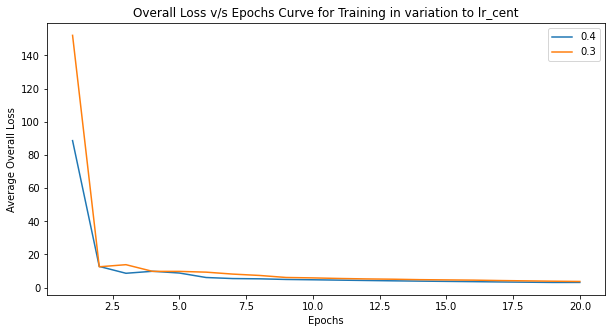

In [15]:
plt.figure(figsize=(10,5))
plt.plot([j for j in range(1,21)],[output_train_center_0_4[i][1] for i in range(0,20)])
plt.plot([j for j in range(1,21)],[output_train_center_0_3[i][1] for i in range(0,20)])
plt.xlabel("Epochs")
plt.ylabel("Average Overall Loss")
plt.title("Overall Loss v/s Epochs Curve for Training in variation to lr_cent")
plt.legend(["0.4","0.3"])
plt.show()

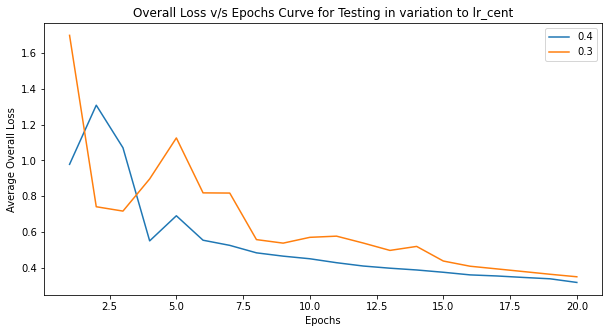

In [16]:
plt.figure(figsize=(10,5))
plt.plot([j for j in range(1,21)],[output_val_center_0_4[i][1] for i in range(0,20)])
plt.plot([j for j in range(1,21)],[output_val_center_0_3[i][1] for i in range(0,20)])
plt.xlabel("Epochs")
plt.ylabel("Average Overall Loss")
plt.title("Overall Loss v/s Epochs Curve for Testing in variation to lr_cent")
plt.legend(["0.4","0.3"])
plt.show()

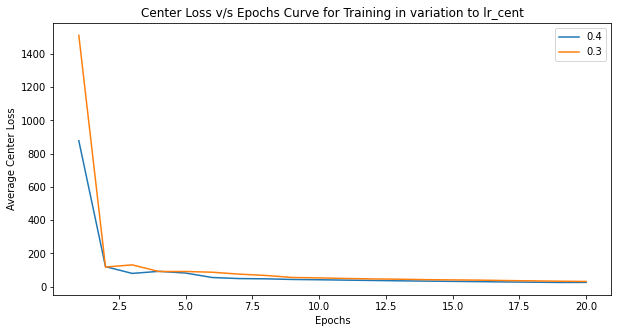

In [17]:
plt.figure(figsize=(10,5))
plt.plot([j for j in range(1,21)],[output_train_center_0_4[i][2] for i in range(0,20)])
plt.plot([j for j in range(1,21)],[output_train_center_0_3[i][2] for i in range(0,20)])
plt.xlabel("Epochs")
plt.ylabel("Average Center Loss")
plt.title("Center Loss v/s Epochs Curve for Training in variation to lr_cent")
plt.legend(["0.4","0.3"])
plt.show()

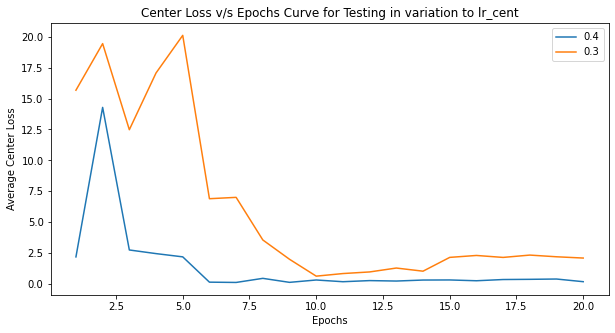

In [18]:
plt.figure(figsize=(10,5))
plt.plot([j for j in range(1,21)],[output_val_center_0_4[i][2] for i in range(0,20)])
plt.plot([j for j in range(1,21)],[output_val_center_0_3[i][2] for i in range(0,20)])
plt.xlabel("Epochs")
plt.ylabel("Average Center Loss")
plt.title("Center Loss v/s Epochs Curve for Testing in variation to lr_cent")
plt.legend(["0.4","0.3"])
plt.show()

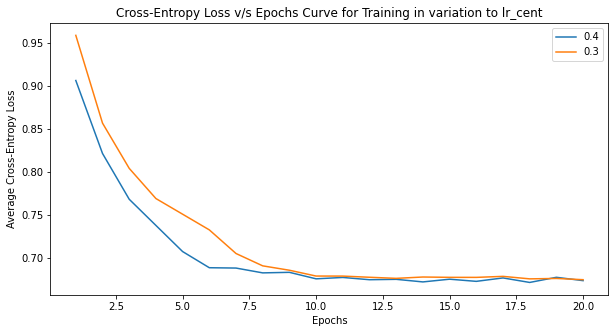

In [19]:
plt.figure(figsize=(10,5))
plt.plot([j for j in range(1,21)],[output_train_center_0_4[i][3] for i in range(0,20)])
plt.plot([j for j in range(1,21)],[output_train_center_0_3[i][3] for i in range(0,20)])
plt.xlabel("Epochs")
plt.ylabel("Average Cross-Entropy Loss")
plt.title("Cross-Entropy Loss v/s Epochs Curve for Training in variation to lr_cent")
plt.legend(["0.4","0.3"])
plt.show()

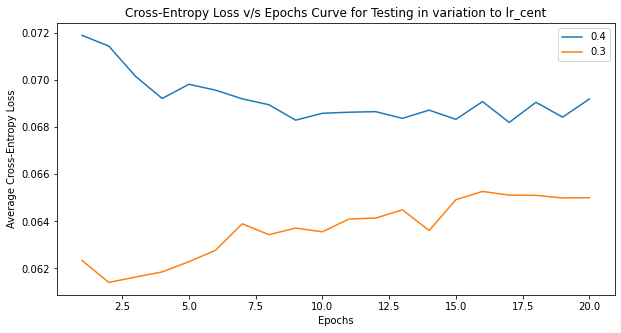

In [20]:
plt.figure(figsize=(10,5))
plt.plot([j for j in range(1,21)],[output_val_center_0_4[i][3] for i in range(0,20)])
plt.plot([j for j in range(1,21)],[output_val_center_0_3[i][3] for i in range(0,20)])
plt.xlabel("Epochs")
plt.ylabel("Average Cross-Entropy Loss")
plt.title("Cross-Entropy Loss v/s Epochs Curve for Testing in variation to lr_cent")
plt.legend(["0.4","0.3"])
plt.show()

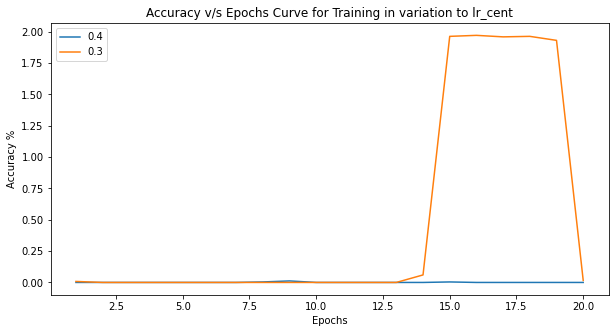

In [21]:
plt.figure(figsize=(10,5))
plt.plot([j for j in range(1,21)],[output_train_center_0_4[i][4].cpu().numpy() for i in range(0,20)])
plt.plot([j for j in range(1,21)],[output_train_center_0_3[i][4].cpu().numpy() for i in range(0,20)])
plt.xlabel("Epochs")
plt.ylabel("Accuracy %")
plt.title("Accuracy v/s Epochs Curve for Training in variation to lr_cent")
plt.legend(["0.4","0.3"])
plt.show()

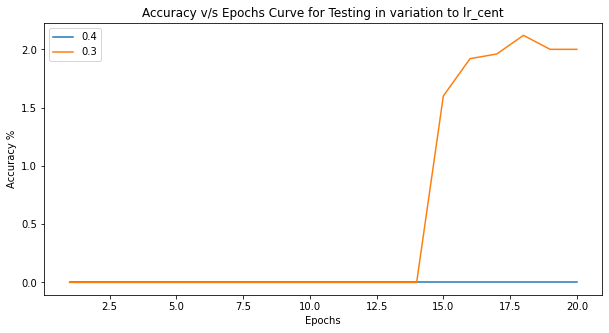

In [22]:
plt.figure(figsize=(10,5))
plt.plot([j for j in range(1,21)],[output_val_center_0_4[i][4].cpu().numpy() for i in range(0,20)])
plt.plot([j for j in range(1,21)],[output_val_center_0_3[i][4].cpu().numpy() for i in range(0,20)])
plt.xlabel("Epochs")
plt.ylabel("Accuracy %")
plt.title("Accuracy v/s Epochs Curve for Testing in variation to lr_cent")
plt.legend(["0.4","0.3"])
plt.show()

# 3.) Optimization via Triplet Loss

In [6]:
train_triplet, val_triplet = data_preparation(Train_Prepare, Val_Prepare, '/content/drive/MyDrive/DL_Assignment_2/tiny-imagenet-200/train', '/content/drive/MyDrive/DL_Assignment_2/tiny-imagenet-200/val', train_df, val_df, Batch_Size = 500, Shuffle = True)

## Pytorch-Compatible Class for Triplet Loss

In [7]:
class Triplet_Loss(torch.nn.Module):
  def __init__(self, margin_alpha):
    super(Triplet_Loss, self).__init__()
    self.margin = margin_alpha
    self.dist_p = 1000
    self.dist_n = 1000
    self.loss_sum = 0
  
  def dist_calc(self,x1,x2):
    x1_ed = (x1[0].item() - x2[0].item())**2
    x2_ed = (x1[1].item() - x2[1].item())**2
    return x1_ed + x2_ed

  def forward(self, Feature_Matrix, Label_Vector):
    for i in range(0,Label_Vector.shape[0]-1):
      for j in range(i+1,Label_Vector.shape[0]):
        dist = self.dist_calc(Feature_Matrix[i],Feature_Matrix[j])
        if (Label_Vector[i]==Label_Vector[j]) and (self.dist_p > dist):
          self.dist_p = dist
        if (Label_Vector[i]!=Label_Vector[j]) and (self.dist_n > dist):
          self.dist_n = dist
      if (self.dist_p - self.dist_n + self.margin)>0:
        self.loss_sum += self.dist_p - self.dist_n + self.margin
      else:
        self.loss_sum += 0
    loss = self.loss_sum
    return loss

## For Margin = 0.5

In [20]:
resnet_model_triplet = models.resnet18(pretrained=True)
n_input = resnet_model_triplet.fc.out_features
resnet_model_triplet.fc1 = torch.nn.Linear(n_input,2)
resnet_model_triplet.fc1_activation = torch.nn.LeakyReLU()
resnet_model_triplet.fc2 = torch.nn.Linear(2,50)
resnet_model_triplet.cuda()
model_loss = torch.nn.CrossEntropyLoss().cuda()
triplet_loss = Triplet_Loss(0.5)
params_triplet = list(resnet_model_triplet.parameters()) + list(triplet_loss.parameters())
optimizer_triplet = torch.optim.Adam(params_triplet, lr=0.01)

## Utility Functions to train a Pytorch-Model with varied Margin and Learning Rate

In [17]:
def grad_change_triplet_lr(Loss_Function_model, Loss_Function_triplet, Optimizer, Label = None, Predicted = None, Features = None, lambda_chosen=0.1, lr_triplet_user = 0.5, lr_optim_user = 0.1):
  cross_loss = Loss_Function_model(Predicted, Label)/500
  triplet_loss = Loss_Function_triplet(Features, Label)/500
  overall_loss = cross_loss + triplet_loss*lambda_chosen
  Optimizer.zero_grad()
  overall_loss.backward()
  for param in Loss_Function_triplet.parameters():
    param.grad.data *= (lr_triplet_user / (lambda_chosen * lr_optim_user))
  Optimizer.step()
  return overall_loss, triplet_loss, cross_loss, Optimizer

def model_triplet_lr(Train_Loader, Test_Loader, Epochs, Model_Class=None, Model_Features=None, Loss_Function_model=None, Loss_Function_triplet=None, Optimizer=None, lambda_param=0.1, lr_triplet=0.5, lr_optim = 0.1):
  outputs_train=[]
  outputs_test=[]
  for Epoch in tqdm(range(Epochs)):
    running_loss_train=0
    triplet_loss_train=0
    cross_loss_train=0
    running_loss_test=0
    triplet_loss_test=0
    cross_loss_test=0
    correct_train=0
    correct_test=0
    for (image, label) in Train_Loader:
      image = image.cuda()
      label = label.cuda()
      output_pred = Model_Class(image)
      model_feat = Model_Features(model_class = Model_Class, output_layer = 'fc1_activation')
      output_feat = model_feat(image)
      loss, cent, cross, Optimizer = grad_change_triplet_lr(Loss_Function_model = Loss_Function_model, Loss_Function_triplet = Loss_Function_triplet, Optimizer = Optimizer, Label = label, Predicted = output_pred, Features = output_feat, lambda_chosen=lambda_param, lr_triplet_user = lr_triplet, lr_optim_user = lr_optim)
      running_loss_train += loss.item()
      triplet_loss_train += cent
      cross_loss_train += cross.item()
      predicted_train = output_pred.data.max(1, keepdim=True)[1]
      correct_train += predicted_train.eq(label.data.view_as(predicted_train)).sum()
      print(running_loss_train, triplet_loss_train, cross_loss_train)
    outputs_train.append((Epoch, running_loss_train, triplet_loss_train, cross_loss_train,100*correct_train/len(Train_Loader.dataset)))
    with torch.no_grad():
      for (image, label) in Test_Loader:
        image = image.cuda()
        label = label.cuda()
        out_pred = Model_Class(image)
        mod_feat = Model_Features(model_class = Model_Class, output_layer = 'fc1_activation')
        out_feat = mod_feat(image)
        cross_loss = Loss_Function_model(out_pred,label)
        cent_loss = Loss_Function_triplet(out_feat,label)
        overall_loss = cross_loss + cent_loss*lambda_param
        running_loss_test += overall_loss.item()
        triplet_loss_test += cent
        cross_loss_test += cross.item()
        predicted_test = out_pred.data.max(1, keepdim=True)[1]
        correct_test += predicted_test.eq(label.data.view_as(predicted_test)).sum()
        print(running_loss_test, triplet_loss_test, cross_loss_test)
      outputs_test.append((Epoch, running_loss_test/len(Test_Loader.dataset), triplet_loss_test/len(Test_Loader.dataset), cross_loss_test/len(Test_Loader.dataset), 100*correct_test/len(Test_Loader.dataset)))
  return Model_Class, outputs_train, outputs_test

In [21]:
resnet_model_triplet_1,output_train_triplet_1,output_val_triplet_1 = model_triplet_lr(train_triplet,val_triplet,5,resnet_model_triplet,new_model,model_loss,triplet_loss,optimizer_triplet,lambda_param=0.1, lr_triplet=0.5, lr_optim=0.01)

  0%|          | 0/5 [00:00<?, ?it/s]

0.07996784150600433 0.5012806929319168 0.02983977645635605
0.19488534331321716 1.5017022157832889 0.04471512511372566
0.35376547276973724 3.001125847888866 0.05365288071334362
0.5631747543811798 4.999549928162326 0.06321974750608206
0.8222096860408783 7.496974139622614 0.07251224666833878
1.1307120621204376 10.493398418958439 0.08137222286313772
1.4896698892116547 13.988822706767188 0.09078760351985693
1.8983106911182404 17.983247002661447 0.09998597204685211
2.3566404283046722 22.47667130653323 0.10897327493876219
2.864571124315262 27.4690956125604 0.11766154877841473
3.4225057661533356 32.960519919228396 0.12645374611020088
4.029530555009842 38.95094422653721 0.13443613331764936
4.686445385217667 45.440368534486836 0.14240856561809778
5.393395096063614 52.42879284307729 0.15051585901528597
6.150270789861679 59.916217152308555 0.15864913072437048
6.957348674535751 67.90264146218064 0.1670845840126276
7.814642578363419 76.38806577269355 0.17583604622632265
8.72102639079094 85.372490083

 20%|██        | 1/5 [18:38<1:14:32, 1118.05s/it]

6632.0125732421875 124.7621216255017 0.03979525063186884
2.8023390769958496 27.946424326625237 0.007696746848523617
5.655022382736206 56.391848653504624 0.015837639570236206
8.55721664428711 85.33627298063816 0.023589690681546926
11.509284734725952 114.77969730802585 0.03131543565541506
14.511144399642944 144.7221216356677 0.038932557217776775
17.562939167022705 175.16354596356368 0.0465849288739264
20.664631605148315 206.1039702917138 0.054234870709478855
23.816163301467896 237.54339462011808 0.06182423746213317
27.017701387405396 269.4818189487765 0.06951999757438898
30.269127130508423 301.9192432776891 0.07720330730080605
33.57046318054199 334.85566760685583 0.08489674469456077
36.921936988830566 368.2910919362767 0.0928283124230802
40.32295846939087 402.22551626595174 0.10040736990049481
43.77387714385986 436.6589405958809 0.10798366740345955
47.2746798992157 471.5913649260642 0.1155439899303019
50.82553434371948 507.0227892565017 0.1232560588978231
54.42630195617676 542.9532135871

 40%|████      | 2/5 [36:59<55:24, 1108.14s/it]  

13491.68212890625 261.9871216953927 0.035887209232896566
5.548491477966309 55.39142434060344 0.009348681196570396
11.144767761230469 111.28184868146104 0.016582357697188854
16.790815353393555 167.6712730225728 0.02368792938068509
22.486867904663086 224.55969736393868 0.030898138880729675
28.232818603515625 281.94712170555874 0.03810664173215628
34.02856159210205 339.83354604743295 0.04520717868581414
39.874253273010254 398.21897038956126 0.052356438245624304
45.7698860168457 457.10339473194375 0.05954659730195999
51.71535348892212 516.4868190745804 0.06667126109823585
57.71071767807007 576.3692434174711 0.0737927109003067
63.756367683410645 636.750667760616 0.08130057947710156
69.85381698608398 697.6310921040151 0.09070785855874419
75.99891757965088 759.0105164476684 0.09786612493917346
82.19390201568604 820.8889407915757 0.10500803403556347
88.43882417678833 883.2663651357373 0.11218794481828809
94.73360872268677 946.1427894801529 0.11933022551238537
101.07890510559082 1009.5182138248

 60%|██████    | 3/5 [55:06<36:37, 1098.81s/it]

20352.460205078125 399.2121217652837 0.03844444872811437
8.290688514709473 82.83642435458164 0.007045852951705456
16.63117790222168 166.17184870941742 0.013992753811180592
25.022695541381836 250.00627306450735 0.02206723392009735
33.46291732788086 334.33969741985146 0.028947471641004086
41.95307731628418 419.1721217754497 0.03586503863334656
50.49311637878418 504.5035461313021 0.04276207881048322
59.08331298828125 590.3339704874086 0.049917006865143776
67.7232027053833 676.6633948437693 0.0568644180893898
76.41307640075684 763.4918192003842 0.06389555428177118
85.15264892578125 850.8192435572531 0.07072616275399923
93.9423189163208 938.6456679143762 0.07775425259023905
102.7817792892456 1026.9710922717534 0.08467183588072658
111.67118072509766 1115.7955166293848 0.09163112379610538
120.61053562164307 1205.1189409872704 0.09864345518872142
129.59955883026123 1294.94136534541 0.10542448423802853
138.63876914978027 1385.262789703804 0.11249214317649603
147.7276210784912 1476.083214062452 

 80%|████████  | 4/5 [1:13:17<18:15, 1095.51s/it]

27212.6171875 536.4371218351748 0.032400821801275015
11.035218238830566 110.28142436855985 0.007076364476233721
22.11967372894287 221.06184873737385 0.013490148354321718
33.254061698913574 332.34127310644203 0.019935863092541695
44.4382438659668 444.1196974757643 0.026276282966136932
55.67234516143799 556.3971218453407 0.032635788433253765
66.95658493041992 669.1735462151713 0.03923303633928299
78.29040050506592 782.4489705852561 0.04550590738654137
89.67414665222168 896.223394955595 0.05180950602516532
101.10781192779541 1010.4968193261881 0.05813238024711609
112.59139823913574 1125.2692436970353 0.06447645369917154
124.12497806549072 1240.5406680681367 0.0709134484641254
135.70835494995117 1356.3110924394923 0.07724735885858536
147.3415412902832 1472.580516811102 0.0834910529665649
159.02470016479492 1589.3489411829657 0.08980753412470222
170.75799465179443 1706.6163655550836 0.09635929437354207
182.54116821289062 1824.3827899274556 0.10288994759321213
194.37401294708252 1942.6482143

100%|██████████| 5/5 [1:31:31<00:00, 1098.25s/it]

34072.21044921875 673.6621219047994 0.029771337285637856


## For Margin = 1

In [22]:
resnet_model_triplet_2 = models.resnet18(pretrained=True)
n_input = resnet_model_triplet_2.fc.out_features
resnet_model_triplet_2.fc1 = torch.nn.Linear(n_input,2)
resnet_model_triplet_2.fc1_activation = torch.nn.LeakyReLU()
resnet_model_triplet_2.fc2 = torch.nn.Linear(2,50)
resnet_model_triplet_2.cuda()
model_loss = torch.nn.CrossEntropyLoss().cuda()
triplet_loss_2 = Triplet_Loss(1)
params_triplet_2 = list(resnet_model_triplet_2.parameters()) + list(triplet_loss_2.parameters())
optimizer_triplet_2 = torch.optim.Adam(params_triplet_2, lr=0.01)
resnet_model_triplet_2,output_train_triplet_2,output_val_triplet_2 = model_triplet_lr(train_triplet,val_triplet,5,resnet_model_triplet_2,new_model,model_loss,triplet_loss_2,optimizer_triplet_2,lambda_param=0.1, lr_triplet=0.5, lr_optim=0.01)

  0%|          | 0/5 [00:00<?, ?it/s]

0.13168559968471527 1.0172720563588493 0.029958391562104225
0.34536710381507874 3.033021157398185 0.042064985260367393
0.6568323969841003 6.046772822785687 0.05215511005371809
1.066758930683136 10.058524613764472 0.060906486585736275
1.5760904550552368 15.06827640817119 0.06926283147186041
2.185215950012207 21.076028203144716 0.07761312648653984
2.894005000591278 28.081779998094188 0.08582701813429594
3.7031242847442627 36.08553179302906 0.09457113314419985
4.611525237560272 45.087283587962595 0.10279691219329834
5.619446575641632 55.087035382896126 0.11074307281523943
6.72758549451828 66.08478717782965 0.11910677328705788
7.935422003269196 78.08053897276318 0.12736811954528093
9.243023931980133 91.07429076769671 0.13559492491185665
10.650110423564911 105.06604256263024 0.14350619073957205
12.157216608524323 120.05579435756377 0.15163717791438103
13.76408189535141 136.0435461524973 0.15972731076180935
15.470725953578949 153.02929794743085 0.1677961777895689
17.277320444583893 171.01304

 20%|██        | 1/5 [18:10<1:12:41, 1090.37s/it]

13248.780517578125 249.5987589746677 0.03966462332755327
5.59860897064209 55.90775179493354 0.007833954878151417
11.297355651855469 112.81350358986708 0.016005448065698147
17.09681749343872 170.71725538480064 0.025091822259128094
22.99483871459961 229.61900717973418 0.03293788805603981
28.992918014526367 289.5187589746677 0.04104212950915098
35.09065866470337 350.41651076960125 0.0490077743306756
41.288217544555664 412.31226256453476 0.05699136387556791
47.58598041534424 475.2060143594683 0.0653787786141038
53.98328399658203 539.0977661544018 0.07350710593163967
60.480252742767334 603.9875179493354 0.08150100708007812
67.07692575454712 669.875269744269 0.0893987538293004
73.77421188354492 736.7610215392025 0.09810939710587263
80.57057809829712 804.6447733341361 0.10610009636729956
87.46659421920776 873.5265251290696 0.11394121591001749
94.46231985092163 943.4062769240031 0.12169172521680593
101.55801916122437 1014.2840287189367 0.12961571663618088
108.75320816040039 1086.1597805138704 

 40%|████      | 2/5 [36:11<54:14, 1084.93s/it]  

26970.51220703125 524.0487589746677 0.03919823560863733
11.087539672851562 110.79775179493355 0.007764890789985657
22.274765968322754 222.5935035898671 0.015416162554174662
33.561739921569824 335.38725538480065 0.02301521599292755
44.9487829208374 449.1790071797342 0.0308827618137002
56.435425758361816 563.9687589746677 0.038550686091184616
68.0218915939331 679.7565107696013 0.046240922063589096
79.70828247070312 796.5422625645348 0.05405632592737675
91.49467754364014 914.3260143594683 0.062076060101389885
103.3807544708252 1033.1077661544018 0.0699781272560358
115.3665132522583 1152.8875179493355 0.07776195742189884
127.4517822265625 1273.665269744269 0.0852561816573143
139.63689517974854 1395.4410215392024 0.09279424138367176
151.92188167572021 1518.214773334136 0.10040587512776256
164.30691528320312 1641.9865251290696 0.10826414311304688
176.79175758361816 1766.756276924003 0.11613071011379361
189.37612438201904 1892.5240287189365 0.12372226966544986
202.0602788925171 2019.289780513

 60%|██████    | 3/5 [54:07<36:01, 1080.96s/it]

40691.6865234375 798.4987589746677 0.03611217252910137
16.57616424560547 165.68775179493355 0.007388978265225887
33.25212287902832 332.3735035898671 0.014772116206586361
50.02790641784668 500.05725538480067 0.0221807062625885
66.90322494506836 668.7390071797342 0.029323605820536613
83.87846374511719 838.4187589746678 0.03658717032521963
100.95352745056152 1009.0965107696013 0.04387443559244275
118.1280689239502 1180.772262564535 0.05083929328247905
135.40263175964355 1353.4460143594683 0.05802686000242829
152.77705192565918 1527.1177661544018 0.06527140457183123
170.25128173828125 1701.7875179493353 0.07252789800986648
187.82523345947266 1877.455269744269 0.07970552099868655
205.49903869628906 2054.1210215392025 0.08693568129092455
223.2725009918213 2231.784773334136 0.09402291430160403
241.1458225250244 2410.4465251290694 0.10116887465119362
259.1190643310547 2590.106276924003 0.10843511437997222
277.1918773651123 2770.7640287189365 0.11547345854341984
295.36450386047363 2952.41978051

 80%|████████  | 4/5 [1:12:08<18:00, 1080.76s/it]

54412.984375 1072.9487589746677 0.035250631626695395
22.064682006835938 220.57775179493353 0.006907184608280659
44.22895622253418 442.1535035898671 0.01360588101670146
66.49327850341797 664.7272553848006 0.020552203059196472
88.8572883605957 888.2990071797342 0.027385997585952282
111.32115173339844 1112.8687589746678 0.03427392989397049
133.8847713470459 1338.4365107696012 0.041117798537015915
156.54815292358398 1565.0022625645347 0.047925992868840694
179.31128120422363 1792.5660143594682 0.054679568856954575
202.17416191101074 2021.1277661544018 0.06138653680682182
225.13694953918457 2250.6875179493354 0.0681996513158083
248.19952774047852 2481.245269744269 0.07500281929969788
271.3619956970215 2712.801021539203 0.08189596747979522
294.62409591674805 2945.3547733341366 0.0886211832985282
317.98603439331055 3178.90652512907 0.09538444364443421
341.4477596282959 3413.4562769240033 0.10213541844859719
365.0093078613281 3649.0040287189368 0.10890764417126775
388.6706600189209 3885.5497805

100%|██████████| 5/5 [1:30:13<00:00, 1082.79s/it]

68134.39453125 1347.398758974668 0.032071531750261784


## For Margin = 1.5

In [23]:
resnet_model_triplet_3 = models.resnet18(pretrained=True)
n_input = resnet_model_triplet_3.fc.out_features
resnet_model_triplet_3.fc1 = torch.nn.Linear(n_input,2)
resnet_model_triplet_3.fc1_activation = torch.nn.LeakyReLU()
resnet_model_triplet_3.fc2 = torch.nn.Linear(2,50)
resnet_model_triplet_3.cuda()
model_loss = torch.nn.CrossEntropyLoss().cuda()
triplet_loss_3 = Triplet_Loss(1.5)
params_triplet_3 = list(resnet_model_triplet_3.parameters()) + list(triplet_loss_3.parameters())
optimizer_triplet_3 = torch.optim.Adam(params_triplet_3, lr=0.01)
resnet_model_triplet_3,output_train_triplet_3,output_val_triplet_3 = model_triplet_lr(train_triplet,val_triplet,5,resnet_model_triplet_3,new_model,model_loss,triplet_loss_3,optimizer_triplet_3,lambda_param=0.1, lr_triplet=0.5, lr_optim=0.01)

  0%|          | 0/5 [00:00<?, ?it/s]

0.18166780471801758 1.5109125161631123 0.030576564371585846
0.49524998664855957 4.519017849070915 0.04334818571805954
0.9578885138034821 9.024124761635965 0.05547602754086256
1.5678273737430573 15.02623172338987 0.0652042431756854
2.3267663419246674 22.525338701706147 0.07423248793929815
3.235443025827408 31.521445685350404 0.08329846896231174
4.294108897447586 42.01455267212138 0.09265369456261396
5.5022328197956085 54.00465966021635 0.10176684986799955
6.8595995008945465 67.4917666485228 0.11042290832847357
8.366195946931839 82.47587363691287 0.11860866937786341
10.022752910852432 98.95698062532568 0.12705485988408327
11.828701049089432 116.93508761376211 0.13519228901714087
13.784634858369827 136.41019460222213 0.1436153193935752
15.890060693025589 157.38230159070574 0.15183050092309713
18.1450357735157 179.85140857921294 0.15989467222243547
20.55026939511299 203.81751556774375 0.16851759888231754
23.104700356721878 229.28062255629817 0.17663779389113188
25.80866339802742 256.240729

 20%|██        | 1/5 [17:53<1:11:35, 1073.85s/it]

19858.58544921875 374.3205349452824 0.03932646010071039
8.392593383789062 83.84610698910005 0.007982618175446987
16.93479633331299 169.18921397820736 0.015875093638896942
25.626590728759766 256.02932096732195 0.023659180384129286
34.46873664855957 344.3664279564438 0.03209449304267764
43.459893226623535 434.2005349455729 0.0398398507386446
52.60082721710205 525.5316419347092 0.04766281880438328
61.891478538513184 618.3597489238529 0.05550282821059227
71.33172607421875 712.6848559130037 0.06324026174843311
80.92172050476074 808.5069629021618 0.07102427911013365
90.66145896911621 905.8260698913273 0.078852454200387
100.55078029632568 1004.6421768805 0.08656271500512958
110.58989238739014 1104.95528386968 0.09436356974765658
120.77867889404297 1206.7653908588672 0.10213965363800526
131.117205619812 1310.0724978480616 0.10995564982295036
141.60545349121094 1414.8766048372634 0.11779341660439968
152.24337196350098 1521.1777118264724 0.1256007212214172
163.03094100952148 1628.9758188156886 0

 40%|████      | 2/5 [35:49<53:44, 1074.81s/it]  

40442.31005859375 785.9955349479129 0.038815627340227365
16.626245498657227 166.18110698966973 0.00813477672636509
33.40189743041992 333.85921397935397 0.015976130962371826
50.327314376831055 503.0343209690527 0.02388167753815651
67.40221214294434 673.706427958766 0.03156812256202102
84.62677383422852 845.8755349484939 0.0392182981595397
102.00108909606934 1019.5416419382361 0.04692173236981034
119.52513885498047 1194.704748927993 0.05466032586991787
137.19911575317383 1371.3648559177643 0.06262662541121244
155.02248191833496 1549.5219629075502 0.07028341479599476
172.99552154541016 1729.1760698973508 0.07791263796389103
191.11822509765625 1910.3271768871657 0.08550508739426732
209.39123725891113 2092.975283876995 0.09370574774220586
227.81332206726074 2277.120390866839 0.10127912135794759
246.3851490020752 2462.7624978566973 0.10889602173119783
265.1065979003906 2649.9016048465705 0.11643471661955118
283.97792053222656 2838.537711836458 0.12414662074297667
302.9987373352051 3028.67081

 60%|██████    | 3/5 [53:38<35:44, 1072.41s/it]

61024.7666015625 1197.6705349519068 0.036887344904243946
24.85895347595215 248.51610699046847 0.007342953700572252
49.86750030517578 498.52921398095145 0.01457918481901288
75.02587509155273 750.039320971449 0.021943419706076384
100.33381080627441 1003.0464279619611 0.029169274494051933
125.79144096374512 1257.5505349524876 0.03638893412426114
151.3987979888916 1513.5516419430287 0.043635081965476274
177.15589904785156 1771.0497489335844 0.05092423828318715
203.0625877380371 2030.0448559241545 0.05810187803581357
229.1189365386963 2290.536962914739 0.06523864576593041
255.32502365112305 2552.5260699053383 0.0724158980883658
281.68084716796875 2816.012176895939 0.07962995069101453
308.1863479614258 3080.9952838865397 0.08682035515084863
334.8415870666504 3347.4753908771404 0.09405014058575034
361.6465377807617 3615.452497867741 0.10129076801240444
388.60107612609863 3884.9266048583418 0.10841819271445274
415.7053165435791 4155.897711848943 0.1155477138236165
442.95922088623047 4428.36581

 80%|████████  | 4/5 [1:11:29<17:51, 1071.82s/it]

81607.6728515625 1609.3455349530036 0.034739167895168066
33.09184646606445 330.8511069906007 0.006735318340361118
66.33359146118164 663.1992139812014 0.013670375104993582
99.72505569458008 997.0443209718021 0.020623683463782072
133.2662124633789 1332.3864279624029 0.027570990845561028
166.95688247680664 1669.2255349530037 0.03433062927797437
200.7972412109375 2007.5616419436044 0.04108061781153083
234.78739547729492 2347.394748934205 0.04792489856481552
268.9272117614746 2688.7248559248055 0.05473129032179713
303.21678161621094 3031.5519629154064 0.061590061988681555
337.65589904785156 3375.876069906007 0.06829801807180047
372.2446594238281 3721.6971768966077 0.07494537020102143
406.9832878112793 4069.0152838872086 0.08176229055970907
441.8715476989746 4417.830390877809 0.08851030888035893
476.90951919555664 4768.14249786841 0.09527146257460117
512.0970306396484 5119.95160485901 0.10187089582905173
547.4344673156738 5473.257711849611 0.10869679786264896
582.9216728210449 5828.060818840

100%|██████████| 5/5 [1:29:42<00:00, 1076.56s/it]

102189.8359375 2021.0205349530033 0.03233852330595255


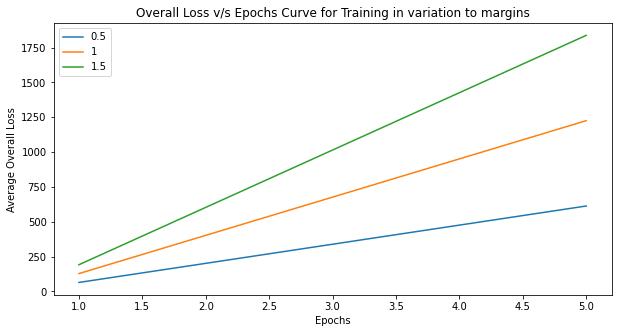

In [24]:
plt.figure(figsize=(10,5))
plt.plot([j for j in range(1,6)],[output_train_triplet_1[i][1] for i in range(0,5)])
plt.plot([j for j in range(1,6)],[output_train_triplet_2[i][1] for i in range(0,5)])
plt.plot([j for j in range(1,6)],[output_train_triplet_3[i][1] for i in range(0,5)])
plt.xlabel("Epochs")
plt.ylabel("Average Overall Loss")
plt.title("Overall Loss v/s Epochs Curve for Training in variation to margins")
plt.legend(["0.5","1","1.5"])
plt.show()

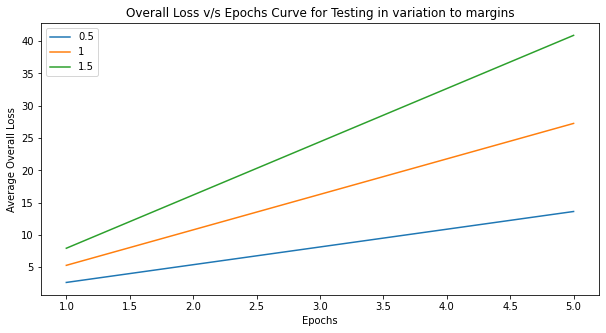

In [25]:
plt.figure(figsize=(10,5))
plt.plot([j for j in range(1,6)],[output_val_triplet_1[i][1] for i in range(0,5)])
plt.plot([j for j in range(1,6)],[output_val_triplet_2[i][1] for i in range(0,5)])
plt.plot([j for j in range(1,6)],[output_val_triplet_3[i][1] for i in range(0,5)])
plt.xlabel("Epochs")
plt.ylabel("Average Overall Loss")
plt.title("Overall Loss v/s Epochs Curve for Testing in variation to margins")
plt.legend(["0.5","1","1.5"])
plt.show()

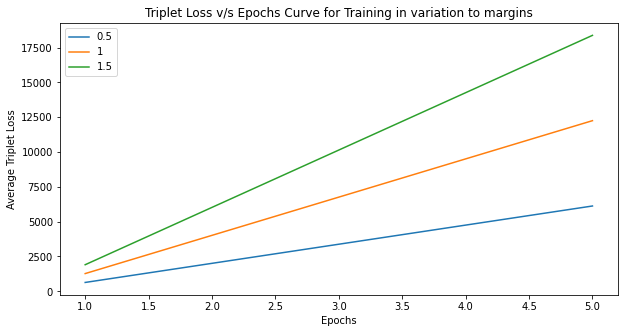

In [32]:
plt.figure(figsize=(10,5))
plt.plot([j for j in range(1,6)],[output_train_triplet_1[i][2] for i in range(0,5)])
plt.plot([j for j in range(1,6)],[output_train_triplet_2[i][2] for i in range(0,5)])
plt.plot([j for j in range(1,6)],[output_train_triplet_3[i][2] for i in range(0,5)])
plt.xlabel("Epochs")
plt.ylabel("Average Triplet Loss")
plt.title("Triplet Loss v/s Epochs Curve for Training in variation to margins")
plt.legend(["0.5","1","1.5"])
plt.show()

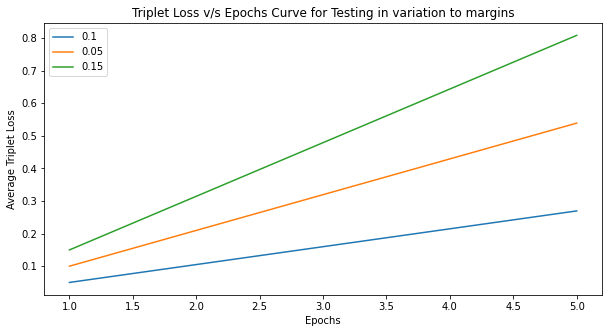

In [33]:
plt.figure(figsize=(10,5))
plt.plot([j for j in range(1,6)],[output_val_triplet_1[i][2] for i in range(0,5)])
plt.plot([j for j in range(1,6)],[output_val_triplet_2[i][2] for i in range(0,5)])
plt.plot([j for j in range(1,6)],[output_val_triplet_3[i][2] for i in range(0,5)])
plt.xlabel("Epochs")
plt.ylabel("Average Triplet Loss")
plt.title("Triplet Loss v/s Epochs Curve for Testing in variation to margins")
plt.legend(["0.1","0.05","0.15"])
plt.show()

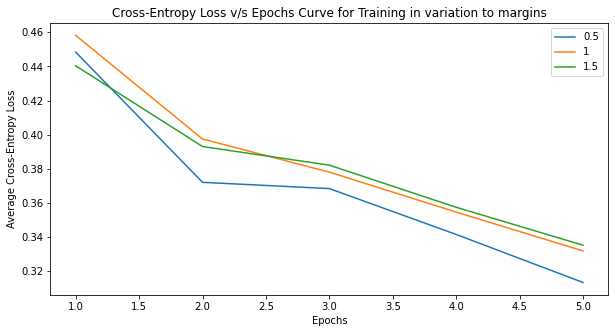

In [28]:
plt.figure(figsize=(10,5))
plt.plot([j for j in range(1,6)],[output_train_triplet_1[i][3] for i in range(0,5)])
plt.plot([j for j in range(1,6)],[output_train_triplet_2[i][3] for i in range(0,5)])
plt.plot([j for j in range(1,6)],[output_train_triplet_3[i][3] for i in range(0,5)])
plt.xlabel("Epochs")
plt.ylabel("Average Cross-Entropy Loss")
plt.title("Cross-Entropy Loss v/s Epochs Curve for Training in variation to margins")
plt.legend(["0.5","1","1.5"])
plt.show()

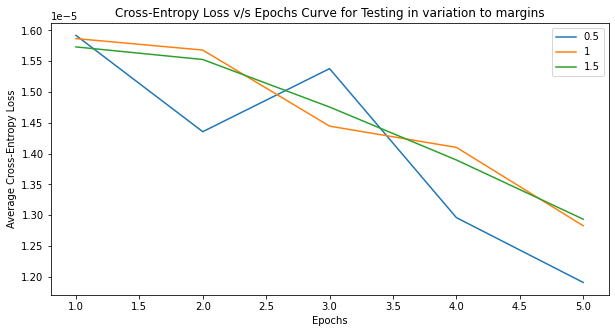

In [29]:
plt.figure(figsize=(10,5))
plt.plot([j for j in range(1,6)],[output_val_triplet_1[i][3] for i in range(0,5)])
plt.plot([j for j in range(1,6)],[output_val_triplet_2[i][3] for i in range(0,5)])
plt.plot([j for j in range(1,6)],[output_val_triplet_3[i][3] for i in range(0,5)])
plt.xlabel("Epochs")
plt.ylabel("Average Cross-Entropy Loss")
plt.title("Cross-Entropy Loss v/s Epochs Curve for Testing in variation to margins")
plt.legend(["0.5","1","1.5"])
plt.show()

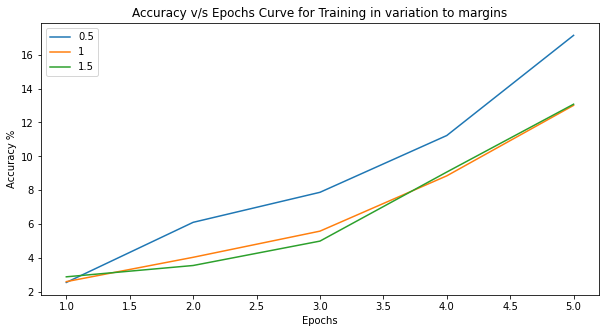

In [30]:
plt.figure(figsize=(10,5))
plt.plot([j for j in range(1,6)],[output_train_triplet_1[i][4].cpu().numpy() for i in range(0,5)])
plt.plot([j for j in range(1,6)],[output_train_triplet_2[i][4].cpu().numpy() for i in range(0,5)])
plt.plot([j for j in range(1,6)],[output_train_triplet_3[i][4].cpu().numpy() for i in range(0,5)])
plt.xlabel("Epochs")
plt.ylabel("Accuracy %")
plt.title("Accuracy v/s Epochs Curve for Training in variation to margins")
plt.legend(["0.5","1","1.5"])
plt.show()

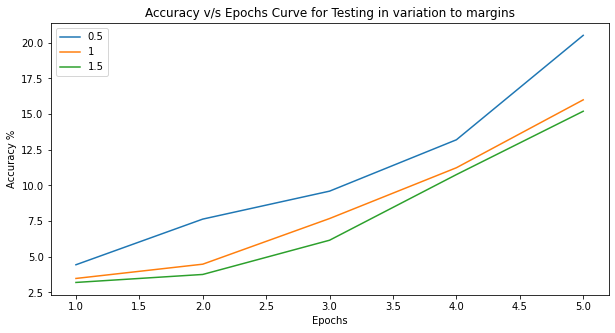

In [31]:
plt.figure(figsize=(10,5))
plt.plot([j for j in range(1,6)],[output_val_triplet_1[i][4].cpu().numpy() for i in range(0,5)])
plt.plot([j for j in range(1,6)],[output_val_triplet_2[i][4].cpu().numpy() for i in range(0,5)])
plt.plot([j for j in range(1,6)],[output_val_triplet_3[i][4].cpu().numpy() for i in range(0,5)])
plt.xlabel("Epochs")
plt.ylabel("Accuracy %")
plt.title("Accuracy v/s Epochs Curve for Testing in variation to margins")
plt.legend(["0.5","1","1.5"])
plt.show()